In [ ]:
!pip install diffusers

In [ ]:
!pip install datasets

In [ ]:
!pip install --upgrade transformers
!pip install --upgrade diffusers

In [ ]:
!pip install gputil

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=fd4c07d1011792646b175db2930a551603c4e425145a2524468865e3f8cefc60
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [ ]:
!git clone https://github.com/uclanlp/visualbert.git
%cd visualbert
!pip install -r requirements.txt

Cloning into 'visualbert'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 229 (delta 35), reused 113 (delta 19), pack-reused 88 (from 1)
Receiving objects: 100% (229/229), 18.24 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/visualbert
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:

import collections
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import sentence_transformers
from sentence_transformers import util
from sentence_transformers import SentenceTransformer
from torch.cuda.amp import autocast
import json
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from collections import Counter
import torch
import gc
import random
from torch.utils.data import Dataset, DataLoader, random_split
from diffusers import StableDiffusionPipeline
from transformers import BlipProcessor, BlipForConditionalGeneration, GPTNeoForCausalLM, GPT2Tokenizer
from PIL import Image
from tqdm import tqdm
from difflib import SequenceMatcher
from torchvision import models, transforms, datasets
from torchvision.datasets import OxfordIIITPet
import numpy as np
import os
from transformers import BlipProcessor, BlipForConditionalGeneration, BertTokenizer, BertModel
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import ImageFile
import GPUtil
from google.colab import drive
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import shutil
from google.colab import files
import zipfile


In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=88a4ae07c4d19e47221fc4d49443663e99e9bc8a72f39e8d0d089f8c69d04358
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
# Retrieve all available GPUs
gpus = GPUtil.getGPUs()

# Display the memory status of each GPU
for gpu in gpus:
    print(f"GPU: {gpu.name}")
    print(f"  Total memory: {gpu.memoryTotal}MB")
    print(f"  Memory used: {gpu.memoryUsed}MB")
    print(f"  Memory free: {gpu.memoryFree}MB")
    print(f"  Memory usage percentage: {gpu.memoryUtil * 100:.2f}%")
    print(f"  GPU utilization percentage: {gpu.load * 100:.2f}%")
    print(f"  Temperature: {gpu.temperature}°C")
    print("-" * 50)

GPU: Tesla T4
  Memoria totale: 15360.0MB
  Memoria occupata: 7115.0MB
  Memoria libera: 7987.0MB
  Percentuale di memoria occupata: 46.32%
  Percentuale di utilizzo della GPU: 0.00%
  Temperatura: 72.0°C
--------------------------------------------------


In [ ]:
# 1. verifying if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# 2. Image conversion for capptiong by Blip
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensionamento delle immagini
    transforms.ToTensor(),          # Converte l'immagine in un tensore
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione per ImageNet
])

# Load the dataset without transformations
trainval_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=None)
test_dataset = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=None)
dataset = trainval_dataset + test_dataset
print(f"Dataset successfully loaded: {len(dataset)} immagini.")

# 3. Initialize the BLIP model
print("Inizialization of BLIP...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# 4.  i create Function to generate captions in batches
def generate_captions_batch(images):
    pil_images = [transforms.ToPILImage()(image).convert("RGB") for image in images]
    inputs = processor(images=pil_images, return_tensors="pt", padding=True).to(device)
    out = blip_model.generate(**inputs)
    captions = [processor.decode(out[i], skip_special_tokens=True) for i in range(len(out))]
    return captions

# 5. creation of Collate_fn function to convert images into tensors and resize them
def collate_fn(batch):
    images, labels = zip(*batch)
    resize = transforms.Resize((224, 224))  # Ridimensiona tutte le immagini alla stessa dimensione
    images = [resize(image) for image in images]  # Applica il ridimensionamento
    images = [transforms.ToTensor()(image) for image in images]
    return torch.stack(images), torch.tensor(labels)

# 6. Preparation of Dataloader
print("Preparation of Dataloader...")
batch_size = 16
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# 7. Creation of the main folder for saved images
output_images_dir = '/content/saved_images'
os.makedirs(output_images_dir, exist_ok=True)

# 8.  Creation of  Function to create a folder by breed and save the image in its original format
def save_image_by_breed(image, label_name, image_id):
    try:
        breed_dir = os.path.join(output_images_dir, label_name)  # Cartella per la razza
        os.makedirs(breed_dir, exist_ok=True)  # Crea la cartella per la razza se non esiste
        image_path = os.path.join(breed_dir, f"{image_id}_original.jpg")  # Salva l'immagine
        original_pil_image = image.convert("RGB")  # Immagine originale senza trasformazioni
        original_pil_image.save(image_path)
        print(f"Image saved: {image_path}")
        return image_path
    except Exception as e:
        print(f"Error saving image {image_id} for breed {label_name}: {e}")
        return None

# 9. Save the images and captions for the entire dataset
data_list = []  # Lista per salvare tutte le informazioni
processed_batches = 0
total_batches = len(data_loader)
successful_saves = 0
image_save_errors = 0

# Creation of Update  in order to save JSON file progressively
json_output_file = '/content/captions_dataset_blip.json'

# Creation of Load the JSON file if it exists for progressive update
if os.path.exists(json_output_file):
    with open(json_output_file, 'r') as json_file:
        data_list = json.load(json_file)  # Carica la lista di dati precedenti

for idx, (images, labels) in tqdm(enumerate(data_loader), desc="Generating captions", unit="batch", total=total_batches):
    images = images.to(device)
    captions_batch = generate_captions_batch(images)

    for i, caption in enumerate(captions_batch):
        image_id = idx * batch_size + i


        label = labels[i].item()
        label_name = trainval_dataset.classes[label]

        # Recupera l'immagine originale dal dataset senza trasformazioni
        original_image = dataset[idx * batch_size + i][0]

        # Salvataggio dell'immagine nel formato originale (senza trasformazioni)
        original_image_path = save_image_by_breed(original_image, label_name, image_id)

        if original_image_path:

            data_list.append({
                "image": original_image_path,   # Path of the saved image in original format
                "caption": caption,             # Generated caption
                "label": label_name             # Original breed label
            })
            successful_saves += 1
        else:
            image_save_errors += 1

    # Progressive save of the JSON file after each batch
    try:
        with open(json_output_file, 'w') as json_file:
            json.dump(data_list, json_file, indent=4)
        print(f"File JSON aggiornato: {json_output_file}.")
    except Exception as e:
        print(f"Errore nel salvataggio progressivo del file JSON: {e}")

    processed_batches += 1

# 10. Puttig in off  the BLIP model and free GPU memory
del blip_model
torch.cuda.empty_cache()
print("Off of Blip in order to Free GPU.")

# 11. report
print(f"\nProcess completed!")
print(f"Total batches processed: {processed_batches}/{total_batches}")
print(f"Total images saved successfully: {successful_saves}")
print(f"Error in saving images: {image_save_errors}")



# 12. Download the JSON file and images at the end
files.download(json_output_file)


shutil.make_archive(output_images_dir, 'zip', output_images_dir)
files.download(f"{output_images_dir}.zip")

Utilizzando il dispositivo: cuda
Dataset caricato con successo: 7349 immagini.
Inizializzazione del modello BLIP...
Preparazione del DataLoader...


Generazione didascalie:   0%|          | 1/460 [00:02<15:54,  2.08s/batch]

Immagine salvata: /content/saved_images/Abyssinian/0_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/2_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/4_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/5_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/6_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/7_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/8_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/9_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/10_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/11_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/12_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/13_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/14_original.jpg
Immag

Generazione didascalie:   0%|          | 2/460 [00:04<19:32,  2.56s/batch]

Immagine salvata: /content/saved_images/Abyssinian/24_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/25_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/26_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/27_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/28_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/29_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/30_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/31_original.jpg
File JSON aggiornato: /content/captions_dataset_blip.json.
Immagine salvata: /content/saved_images/Abyssinian/32_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/33_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/34_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/35_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/36_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/37_original.jpg
Imm

Generazione didascalie:   1%|          | 3/460 [00:08<23:43,  3.12s/batch]

File JSON aggiornato: /content/captions_dataset_blip.json.
Immagine salvata: /content/saved_images/Abyssinian/48_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/49_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/50_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/51_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/52_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/53_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/54_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/55_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/56_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/57_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/58_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/59_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/60_original.jpg
Imma

Generazione didascalie:   1%|          | 4/460 [00:11<22:00,  2.89s/batch]

Immagine salvata: /content/saved_images/American Bulldog/62_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/63_original.jpg
File JSON aggiornato: /content/captions_dataset_blip.json.


Generazione didascalie:   1%|          | 5/460 [00:13<19:34,  2.58s/batch]

Immagine salvata: /content/saved_images/American Bulldog/64_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/65_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/66_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/67_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/68_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/69_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/70_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/71_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/72_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/73_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/74_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/75_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/76_original.jpg
Immagine salvata: /content/saved_images/American Bu

Generazione didascalie:   1%|▏         | 6/460 [00:15<17:47,  2.35s/batch]

Immagine salvata: /content/saved_images/American Bulldog/80_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/81_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/82_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/83_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/84_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/85_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/86_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/87_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/88_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/89_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/90_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/91_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/92_original.jpg
Immagine salvata: /content/saved_images/American Bu

Generazione didascalie:   2%|▏         | 7/460 [00:17<16:28,  2.18s/batch]

Immagine salvata: /content/saved_images/American Bulldog/96_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/97_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/98_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/99_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/100_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/101_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/102_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/103_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/104_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/105_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/106_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/107_original.jpg
Immagine salvata: /content/saved_images/Amer

Generazione didascalie:   2%|▏         | 8/460 [00:18<15:25,  2.05s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/112_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/113_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/114_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/115_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/116_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/117_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/118_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/119_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/120_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/121_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/122_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/123_original.jpg
Imma

Generazione didascalie:   2%|▏         | 9/460 [00:20<15:09,  2.02s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/128_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/129_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/130_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/131_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/132_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/133_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/134_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/135_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/136_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/137_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/138_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/139_original.jpg
Imma

Generazione didascalie:   2%|▏         | 10/460 [00:22<14:39,  1.95s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/144_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/145_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/146_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/147_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/148_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/149_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/150_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/151_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/152_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/153_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/154_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/155_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/156_original.jpg
Immagine sal

Generazione didascalie:   2%|▏         | 11/460 [00:24<14:34,  1.95s/batch]

Immagine salvata: /content/saved_images/Basset Hound/160_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/161_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/162_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/163_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/164_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/165_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/166_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/167_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/168_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/169_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/170_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/171_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/172_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/173_original.jpg
Immagine salvata: /c

Generazione didascalie:   3%|▎         | 12/460 [00:26<14:34,  1.95s/batch]

Immagine salvata: /content/saved_images/Basset Hound/176_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/177_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/178_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/179_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/180_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/181_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/182_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/183_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/184_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/185_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/186_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/187_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/188_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/189_original.jpg
Immagine salvata: /c

Generazione didascalie:   3%|▎         | 13/460 [00:28<14:28,  1.94s/batch]

Immagine salvata: /content/saved_images/Basset Hound/192_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/193_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/194_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/195_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/196_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/197_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/198_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/199_original.jpg
Immagine salvata: /content/saved_images/Beagle/200_original.jpg
Immagine salvata: /content/saved_images/Beagle/201_original.jpg
Immagine salvata: /content/saved_images/Beagle/202_original.jpg
Immagine salvata: /content/saved_images/Beagle/203_original.jpg
Immagine salvata: /content/saved_images/Beagle/204_original.jpg
Immagine salvata: /content/saved_images/Beagle/205_original.jpg
Immagine salvata: /content/saved_images/Beagle/206_origi

Generazione didascalie:   3%|▎         | 14/460 [00:30<14:37,  1.97s/batch]

Immagine salvata: /content/saved_images/Beagle/208_original.jpg
Immagine salvata: /content/saved_images/Beagle/209_original.jpg
Immagine salvata: /content/saved_images/Beagle/210_original.jpg
Immagine salvata: /content/saved_images/Beagle/211_original.jpg
Immagine salvata: /content/saved_images/Beagle/212_original.jpg
Immagine salvata: /content/saved_images/Beagle/213_original.jpg
Immagine salvata: /content/saved_images/Beagle/214_original.jpg
Immagine salvata: /content/saved_images/Beagle/215_original.jpg
Immagine salvata: /content/saved_images/Beagle/216_original.jpg
Immagine salvata: /content/saved_images/Beagle/217_original.jpg
Immagine salvata: /content/saved_images/Beagle/218_original.jpg
Immagine salvata: /content/saved_images/Beagle/219_original.jpg
Immagine salvata: /content/saved_images/Beagle/220_original.jpg
Immagine salvata: /content/saved_images/Beagle/221_original.jpg
Immagine salvata: /content/saved_images/Beagle/222_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   3%|▎         | 15/460 [00:32<14:35,  1.97s/batch]

Immagine salvata: /content/saved_images/Beagle/224_original.jpg
Immagine salvata: /content/saved_images/Beagle/225_original.jpg
Immagine salvata: /content/saved_images/Beagle/226_original.jpg
Immagine salvata: /content/saved_images/Beagle/227_original.jpg
Immagine salvata: /content/saved_images/Beagle/228_original.jpg
Immagine salvata: /content/saved_images/Beagle/229_original.jpg
Immagine salvata: /content/saved_images/Beagle/230_original.jpg
Immagine salvata: /content/saved_images/Beagle/231_original.jpg
Immagine salvata: /content/saved_images/Beagle/232_original.jpg
Immagine salvata: /content/saved_images/Beagle/233_original.jpg
Immagine salvata: /content/saved_images/Beagle/234_original.jpg
Immagine salvata: /content/saved_images/Beagle/235_original.jpg
Immagine salvata: /content/saved_images/Beagle/236_original.jpg
Immagine salvata: /content/saved_images/Beagle/237_original.jpg
Immagine salvata: /content/saved_images/Beagle/238_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   3%|▎         | 16/460 [00:34<14:36,  1.97s/batch]

Immagine salvata: /content/saved_images/Beagle/240_original.jpg
Immagine salvata: /content/saved_images/Beagle/241_original.jpg
Immagine salvata: /content/saved_images/Beagle/242_original.jpg
Immagine salvata: /content/saved_images/Beagle/243_original.jpg
Immagine salvata: /content/saved_images/Beagle/244_original.jpg
Immagine salvata: /content/saved_images/Beagle/245_original.jpg
Immagine salvata: /content/saved_images/Beagle/246_original.jpg
Immagine salvata: /content/saved_images/Beagle/247_original.jpg
Immagine salvata: /content/saved_images/Beagle/248_original.jpg
Immagine salvata: /content/saved_images/Beagle/249_original.jpg
Immagine salvata: /content/saved_images/Bengal/250_original.jpg
Immagine salvata: /content/saved_images/Bengal/251_original.jpg
Immagine salvata: /content/saved_images/Bengal/252_original.jpg
Immagine salvata: /content/saved_images/Bengal/253_original.jpg
Immagine salvata: /content/saved_images/Bengal/254_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   4%|▎         | 17/460 [00:36<14:10,  1.92s/batch]

Immagine salvata: /content/saved_images/Bengal/256_original.jpg
Immagine salvata: /content/saved_images/Bengal/257_original.jpg
Immagine salvata: /content/saved_images/Bengal/258_original.jpg
Immagine salvata: /content/saved_images/Bengal/259_original.jpg
Immagine salvata: /content/saved_images/Bengal/260_original.jpg
Immagine salvata: /content/saved_images/Bengal/261_original.jpg
Immagine salvata: /content/saved_images/Bengal/262_original.jpg
Immagine salvata: /content/saved_images/Bengal/263_original.jpg
Immagine salvata: /content/saved_images/Bengal/264_original.jpg
Immagine salvata: /content/saved_images/Bengal/265_original.jpg
Immagine salvata: /content/saved_images/Bengal/266_original.jpg
Immagine salvata: /content/saved_images/Bengal/267_original.jpg
Immagine salvata: /content/saved_images/Bengal/268_original.jpg
Immagine salvata: /content/saved_images/Bengal/269_original.jpg
Immagine salvata: /content/saved_images/Bengal/270_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   4%|▍         | 18/460 [00:38<15:24,  2.09s/batch]

Immagine salvata: /content/saved_images/Bengal/272_original.jpg
Immagine salvata: /content/saved_images/Bengal/273_original.jpg
Immagine salvata: /content/saved_images/Bengal/274_original.jpg
Immagine salvata: /content/saved_images/Bengal/275_original.jpg
Immagine salvata: /content/saved_images/Bengal/276_original.jpg
Immagine salvata: /content/saved_images/Bengal/277_original.jpg
Immagine salvata: /content/saved_images/Bengal/278_original.jpg
Immagine salvata: /content/saved_images/Bengal/279_original.jpg
Immagine salvata: /content/saved_images/Bengal/280_original.jpg
Immagine salvata: /content/saved_images/Bengal/281_original.jpg
Immagine salvata: /content/saved_images/Bengal/282_original.jpg
Immagine salvata: /content/saved_images/Bengal/283_original.jpg
Immagine salvata: /content/saved_images/Bengal/284_original.jpg
Immagine salvata: /content/saved_images/Bengal/285_original.jpg
Immagine salvata: /content/saved_images/Bengal/286_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   4%|▍         | 19/460 [00:40<14:31,  1.98s/batch]

Immagine salvata: /content/saved_images/Bengal/288_original.jpg
Immagine salvata: /content/saved_images/Bengal/289_original.jpg
Immagine salvata: /content/saved_images/Bengal/290_original.jpg
Immagine salvata: /content/saved_images/Bengal/291_original.jpg
Immagine salvata: /content/saved_images/Bengal/292_original.jpg
Immagine salvata: /content/saved_images/Bengal/293_original.jpg
Immagine salvata: /content/saved_images/Bengal/294_original.jpg
Immagine salvata: /content/saved_images/Bengal/295_original.jpg
Immagine salvata: /content/saved_images/Bengal/296_original.jpg
Immagine salvata: /content/saved_images/Bengal/297_original.jpg
Immagine salvata: /content/saved_images/Bengal/298_original.jpg
Immagine salvata: /content/saved_images/Bengal/299_original.jpg
Immagine salvata: /content/saved_images/Birman/300_original.jpg
Immagine salvata: /content/saved_images/Birman/301_original.jpg
Immagine salvata: /content/saved_images/Birman/302_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   4%|▍         | 20/460 [00:42<14:02,  1.92s/batch]

Immagine salvata: /content/saved_images/Birman/304_original.jpg
Immagine salvata: /content/saved_images/Birman/305_original.jpg
Immagine salvata: /content/saved_images/Birman/306_original.jpg
Immagine salvata: /content/saved_images/Birman/307_original.jpg
Immagine salvata: /content/saved_images/Birman/308_original.jpg
Immagine salvata: /content/saved_images/Birman/309_original.jpg
Immagine salvata: /content/saved_images/Birman/310_original.jpg
Immagine salvata: /content/saved_images/Birman/311_original.jpg
Immagine salvata: /content/saved_images/Birman/312_original.jpg
Immagine salvata: /content/saved_images/Birman/313_original.jpg
Immagine salvata: /content/saved_images/Birman/314_original.jpg
Immagine salvata: /content/saved_images/Birman/315_original.jpg
Immagine salvata: /content/saved_images/Birman/316_original.jpg
Immagine salvata: /content/saved_images/Birman/317_original.jpg
Immagine salvata: /content/saved_images/Birman/318_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   5%|▍         | 21/460 [00:44<14:08,  1.93s/batch]

Immagine salvata: /content/saved_images/Birman/320_original.jpg
Immagine salvata: /content/saved_images/Birman/321_original.jpg
Immagine salvata: /content/saved_images/Birman/322_original.jpg
Immagine salvata: /content/saved_images/Birman/323_original.jpg
Immagine salvata: /content/saved_images/Birman/324_original.jpg
Immagine salvata: /content/saved_images/Birman/325_original.jpg
Immagine salvata: /content/saved_images/Birman/326_original.jpg
Immagine salvata: /content/saved_images/Birman/327_original.jpg
Immagine salvata: /content/saved_images/Birman/328_original.jpg
Immagine salvata: /content/saved_images/Birman/329_original.jpg
Immagine salvata: /content/saved_images/Birman/330_original.jpg
Immagine salvata: /content/saved_images/Birman/331_original.jpg
Immagine salvata: /content/saved_images/Birman/332_original.jpg
Immagine salvata: /content/saved_images/Birman/333_original.jpg
Immagine salvata: /content/saved_images/Birman/334_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   5%|▍         | 22/460 [00:46<14:07,  1.94s/batch]

Immagine salvata: /content/saved_images/Birman/336_original.jpg
Immagine salvata: /content/saved_images/Birman/337_original.jpg
Immagine salvata: /content/saved_images/Birman/338_original.jpg
Immagine salvata: /content/saved_images/Birman/339_original.jpg
Immagine salvata: /content/saved_images/Birman/340_original.jpg
Immagine salvata: /content/saved_images/Birman/341_original.jpg
Immagine salvata: /content/saved_images/Birman/342_original.jpg
Immagine salvata: /content/saved_images/Birman/343_original.jpg
Immagine salvata: /content/saved_images/Birman/344_original.jpg
Immagine salvata: /content/saved_images/Birman/345_original.jpg
Immagine salvata: /content/saved_images/Birman/346_original.jpg
Immagine salvata: /content/saved_images/Birman/347_original.jpg
Immagine salvata: /content/saved_images/Birman/348_original.jpg
Immagine salvata: /content/saved_images/Birman/349_original.jpg
Immagine salvata: /content/saved_images/Bombay/350_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   5%|▌         | 23/460 [00:48<14:10,  1.95s/batch]

Immagine salvata: /content/saved_images/Bombay/352_original.jpg
Immagine salvata: /content/saved_images/Bombay/353_original.jpg
Immagine salvata: /content/saved_images/Bombay/354_original.jpg
Immagine salvata: /content/saved_images/Bombay/355_original.jpg
Immagine salvata: /content/saved_images/Bombay/356_original.jpg
Immagine salvata: /content/saved_images/Bombay/357_original.jpg
Immagine salvata: /content/saved_images/Bombay/358_original.jpg
Immagine salvata: /content/saved_images/Bombay/359_original.jpg
Immagine salvata: /content/saved_images/Bombay/360_original.jpg
Immagine salvata: /content/saved_images/Bombay/361_original.jpg
Immagine salvata: /content/saved_images/Bombay/362_original.jpg
Immagine salvata: /content/saved_images/Bombay/363_original.jpg
Immagine salvata: /content/saved_images/Bombay/364_original.jpg
Immagine salvata: /content/saved_images/Bombay/365_original.jpg
Immagine salvata: /content/saved_images/Bombay/366_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   5%|▌         | 24/460 [00:49<13:52,  1.91s/batch]

Immagine salvata: /content/saved_images/Bombay/368_original.jpg
Immagine salvata: /content/saved_images/Bombay/369_original.jpg
Immagine salvata: /content/saved_images/Bombay/370_original.jpg
Immagine salvata: /content/saved_images/Bombay/371_original.jpg
Immagine salvata: /content/saved_images/Bombay/372_original.jpg
Immagine salvata: /content/saved_images/Bombay/373_original.jpg
Immagine salvata: /content/saved_images/Bombay/374_original.jpg
Immagine salvata: /content/saved_images/Bombay/375_original.jpg
Immagine salvata: /content/saved_images/Bombay/376_original.jpg
Immagine salvata: /content/saved_images/Bombay/377_original.jpg
Immagine salvata: /content/saved_images/Bombay/378_original.jpg
Immagine salvata: /content/saved_images/Bombay/379_original.jpg
Immagine salvata: /content/saved_images/Bombay/380_original.jpg
Immagine salvata: /content/saved_images/Bombay/381_original.jpg
Immagine salvata: /content/saved_images/Bombay/382_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   5%|▌         | 25/460 [00:51<13:47,  1.90s/batch]

Immagine salvata: /content/saved_images/Bombay/384_original.jpg
Immagine salvata: /content/saved_images/Bombay/385_original.jpg
Immagine salvata: /content/saved_images/Bombay/386_original.jpg
Immagine salvata: /content/saved_images/Bombay/387_original.jpg
Immagine salvata: /content/saved_images/Bombay/388_original.jpg
Immagine salvata: /content/saved_images/Bombay/389_original.jpg
Immagine salvata: /content/saved_images/Bombay/390_original.jpg
Immagine salvata: /content/saved_images/Bombay/391_original.jpg
Immagine salvata: /content/saved_images/Bombay/392_original.jpg
Immagine salvata: /content/saved_images/Bombay/393_original.jpg
Immagine salvata: /content/saved_images/Bombay/394_original.jpg
Immagine salvata: /content/saved_images/Bombay/395_original.jpg
Immagine salvata: /content/saved_images/Bombay/396_original.jpg
Immagine salvata: /content/saved_images/Bombay/397_original.jpg
Immagine salvata: /content/saved_images/Bombay/398_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   6%|▌         | 26/460 [00:53<13:54,  1.92s/batch]

Immagine salvata: /content/saved_images/Boxer/400_original.jpg
Immagine salvata: /content/saved_images/Boxer/401_original.jpg
Immagine salvata: /content/saved_images/Boxer/402_original.jpg
Immagine salvata: /content/saved_images/Boxer/403_original.jpg
Immagine salvata: /content/saved_images/Boxer/404_original.jpg
Immagine salvata: /content/saved_images/Boxer/405_original.jpg
Immagine salvata: /content/saved_images/Boxer/406_original.jpg
Immagine salvata: /content/saved_images/Boxer/407_original.jpg
Immagine salvata: /content/saved_images/Boxer/408_original.jpg
Immagine salvata: /content/saved_images/Boxer/409_original.jpg
Immagine salvata: /content/saved_images/Boxer/410_original.jpg
Immagine salvata: /content/saved_images/Boxer/411_original.jpg
Immagine salvata: /content/saved_images/Boxer/412_original.jpg
Immagine salvata: /content/saved_images/Boxer/413_original.jpg
Immagine salvata: /content/saved_images/Boxer/414_original.jpg
Immagine salvata: /content/saved_images/Boxer/415_origi

Generazione didascalie:   6%|▌         | 27/460 [00:55<13:59,  1.94s/batch]

Immagine salvata: /content/saved_images/Boxer/416_original.jpg
Immagine salvata: /content/saved_images/Boxer/417_original.jpg
Immagine salvata: /content/saved_images/Boxer/418_original.jpg
Immagine salvata: /content/saved_images/Boxer/419_original.jpg
Immagine salvata: /content/saved_images/Boxer/420_original.jpg
Immagine salvata: /content/saved_images/Boxer/421_original.jpg
Immagine salvata: /content/saved_images/Boxer/422_original.jpg
Immagine salvata: /content/saved_images/Boxer/423_original.jpg
Immagine salvata: /content/saved_images/Boxer/424_original.jpg
Immagine salvata: /content/saved_images/Boxer/425_original.jpg
Immagine salvata: /content/saved_images/Boxer/426_original.jpg
Immagine salvata: /content/saved_images/Boxer/427_original.jpg
Immagine salvata: /content/saved_images/Boxer/428_original.jpg
Immagine salvata: /content/saved_images/Boxer/429_original.jpg
Immagine salvata: /content/saved_images/Boxer/430_original.jpg
Immagine salvata: /content/saved_images/Boxer/431_origi

Generazione didascalie:   6%|▌         | 28/460 [00:57<14:19,  1.99s/batch]

Immagine salvata: /content/saved_images/Boxer/432_original.jpg
Immagine salvata: /content/saved_images/Boxer/433_original.jpg
Immagine salvata: /content/saved_images/Boxer/434_original.jpg
Immagine salvata: /content/saved_images/Boxer/435_original.jpg
Immagine salvata: /content/saved_images/Boxer/436_original.jpg
Immagine salvata: /content/saved_images/Boxer/437_original.jpg
Immagine salvata: /content/saved_images/Boxer/438_original.jpg
Immagine salvata: /content/saved_images/Boxer/439_original.jpg
Immagine salvata: /content/saved_images/Boxer/440_original.jpg
Immagine salvata: /content/saved_images/Boxer/441_original.jpg
Immagine salvata: /content/saved_images/Boxer/442_original.jpg
Immagine salvata: /content/saved_images/Boxer/443_original.jpg
Immagine salvata: /content/saved_images/Boxer/444_original.jpg
Immagine salvata: /content/saved_images/Boxer/445_original.jpg
Immagine salvata: /content/saved_images/Boxer/446_original.jpg
Immagine salvata: /content/saved_images/Boxer/447_origi

Generazione didascalie:   6%|▋         | 29/460 [00:59<14:14,  1.98s/batch]

Immagine salvata: /content/saved_images/Boxer/448_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/449_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/450_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/451_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/452_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/453_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/454_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/455_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/456_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/457_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/458_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/459_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/460_original.jpg
Immagine salvata: /content/saved_imag

Generazione didascalie:   7%|▋         | 30/460 [01:01<14:35,  2.04s/batch]

Immagine salvata: /content/saved_images/British Shorthair/464_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/465_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/466_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/467_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/468_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/469_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/470_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/471_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/472_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/473_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/474_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/475_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/476_original.jpg
Immagine salvata: /conten

Generazione didascalie:   7%|▋         | 31/460 [01:03<14:03,  1.97s/batch]

Immagine salvata: /content/saved_images/British Shorthair/480_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/481_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/482_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/483_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/484_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/485_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/486_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/487_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/488_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/489_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/490_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/491_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/492_original.jpg
Immagine salvata: /conten

Generazione didascalie:   7%|▋         | 32/460 [01:05<14:12,  1.99s/batch]

Immagine salvata: /content/saved_images/British Shorthair/496_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/497_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/498_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/499_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/500_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/501_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/502_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/503_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/504_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/505_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/506_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/507_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/508_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/509_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:   7%|▋         | 33/460 [01:07<14:21,  2.02s/batch]

Immagine salvata: /content/saved_images/Chihuahua/512_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/513_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/514_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/515_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/516_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/517_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/518_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/519_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/520_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/521_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/522_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/523_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/524_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/525_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/526_original

Generazione didascalie:   7%|▋         | 34/460 [01:09<13:43,  1.93s/batch]

Immagine salvata: /content/saved_images/Chihuahua/528_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/529_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/530_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/531_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/532_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/533_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/534_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/535_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/536_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/537_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/538_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/539_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/540_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/541_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/542_original

Generazione didascalie:   8%|▊         | 35/460 [01:12<15:03,  2.12s/batch]

Immagine salvata: /content/saved_images/Chihuahua/544_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/545_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/546_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/547_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/548_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/549_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/550_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/551_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/552_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/553_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/554_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/555_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/556_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/557_original.jpg
Immagine salvata: /content/saved_im

Generazione didascalie:   8%|▊         | 36/460 [01:14<14:53,  2.11s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/560_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/561_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/562_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/563_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/564_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/565_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/566_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/567_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/568_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/569_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/570_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/571_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/572_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/573_original.jpg
Immagine salvata: /c

Generazione didascalie:   8%|▊         | 37/460 [01:16<14:26,  2.05s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/576_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/577_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/578_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/579_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/580_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/581_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/582_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/583_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/584_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/585_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/586_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/587_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/588_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/589_original.jpg
Immagine salvata: /c

Generazione didascalie:   8%|▊         | 38/460 [01:18<14:05,  2.00s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/592_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/593_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/594_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/595_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/596_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/597_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/598_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/599_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/600_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/601_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/602_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/603_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/604_original.jpg


Generazione didascalie:   8%|▊         | 39/460 [01:20<13:59,  1.99s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/608_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/609_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/610_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/611_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/612_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/613_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/614_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/615_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/616_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/617_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/618_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/619_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   9%|▊         | 40/460 [01:22<15:10,  2.17s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/624_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/625_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/626_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/627_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/628_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/629_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/630_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/631_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/632_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/633_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/634_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/635_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:   9%|▉         | 41/460 [01:24<14:42,  2.11s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/640_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/641_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/642_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/643_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/644_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/645_original.jpg
Immagine salvata: /content/saved_images/English Setter/646_original.jpg
Immagine salvata: /content/saved_images/English Setter/647_original.jpg
Immagine salvata: /content/saved_images/English Setter/648_original.jpg
Immagine salvata: /content/saved_images/English Setter/649_original.jpg
Immagine salvata: /content/saved_images/English Setter/650_original.jpg
Immagine salvata: /content/saved_images/English Setter/651_original.jpg
Immagine salvata: /content/saved_images/English Setter/652_original.jpg
Immagine salvata

Generazione didascalie:   9%|▉         | 42/460 [01:26<14:38,  2.10s/batch]

Immagine salvata: /content/saved_images/English Setter/656_original.jpg
Immagine salvata: /content/saved_images/English Setter/657_original.jpg
Immagine salvata: /content/saved_images/English Setter/658_original.jpg
Immagine salvata: /content/saved_images/English Setter/659_original.jpg
Immagine salvata: /content/saved_images/English Setter/660_original.jpg
Immagine salvata: /content/saved_images/English Setter/661_original.jpg
Immagine salvata: /content/saved_images/English Setter/662_original.jpg
Immagine salvata: /content/saved_images/English Setter/663_original.jpg
Immagine salvata: /content/saved_images/English Setter/664_original.jpg
Immagine salvata: /content/saved_images/English Setter/665_original.jpg
Immagine salvata: /content/saved_images/English Setter/666_original.jpg
Immagine salvata: /content/saved_images/English Setter/667_original.jpg
Immagine salvata: /content/saved_images/English Setter/668_original.jpg
Immagine salvata: /content/saved_images/English Setter/669_origi

Generazione didascalie:   9%|▉         | 43/460 [01:28<14:22,  2.07s/batch]

Immagine salvata: /content/saved_images/English Setter/672_original.jpg
Immagine salvata: /content/saved_images/English Setter/673_original.jpg
Immagine salvata: /content/saved_images/English Setter/674_original.jpg
Immagine salvata: /content/saved_images/English Setter/675_original.jpg
Immagine salvata: /content/saved_images/English Setter/676_original.jpg
Immagine salvata: /content/saved_images/English Setter/677_original.jpg
Immagine salvata: /content/saved_images/English Setter/678_original.jpg
Immagine salvata: /content/saved_images/English Setter/679_original.jpg
Immagine salvata: /content/saved_images/English Setter/680_original.jpg
Immagine salvata: /content/saved_images/English Setter/681_original.jpg
Immagine salvata: /content/saved_images/English Setter/682_original.jpg
Immagine salvata: /content/saved_images/English Setter/683_original.jpg
Immagine salvata: /content/saved_images/English Setter/684_original.jpg
Immagine salvata: /content/saved_images/English Setter/685_origi

Generazione didascalie:  10%|▉         | 44/460 [01:30<13:50,  2.00s/batch]

Immagine salvata: /content/saved_images/English Setter/688_original.jpg
Immagine salvata: /content/saved_images/English Setter/689_original.jpg
Immagine salvata: /content/saved_images/English Setter/690_original.jpg
Immagine salvata: /content/saved_images/English Setter/691_original.jpg
Immagine salvata: /content/saved_images/English Setter/692_original.jpg
Immagine salvata: /content/saved_images/English Setter/693_original.jpg
Immagine salvata: /content/saved_images/English Setter/694_original.jpg
Immagine salvata: /content/saved_images/English Setter/695_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/696_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/697_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/698_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/699_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/700_original.jpg
Immagine salvata: /content/saved_images/Germ

Generazione didascalie:  10%|▉         | 45/460 [01:32<13:59,  2.02s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/704_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/705_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/706_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/707_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/708_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/709_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/710_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/711_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/712_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/713_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/714_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/715_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/716_original.jpg
Immagine sal

Generazione didascalie:  10%|█         | 46/460 [01:34<13:52,  2.01s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/720_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/721_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/722_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/723_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/724_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/725_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/726_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/727_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/728_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/729_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/730_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/731_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/732_original.jpg
Immagine sal

Generazione didascalie:  10%|█         | 47/460 [01:36<14:06,  2.05s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/736_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/737_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/738_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/739_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/740_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/741_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/742_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/743_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/744_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/745_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/746_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/747_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/748_original.jpg
Immagine salvata: /conte

Generazione didascalie:  10%|█         | 48/460 [01:38<13:55,  2.03s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/752_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/753_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/754_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/755_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/756_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/757_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/758_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/759_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/760_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/761_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/762_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/763_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/764_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/765_origi

Generazione didascalie:  11%|█         | 49/460 [01:40<13:51,  2.02s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/768_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/769_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/770_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/771_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/772_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/773_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/774_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/775_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/776_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/777_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/778_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/779_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/780_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/781_origi

Generazione didascalie:  11%|█         | 50/460 [01:42<13:27,  1.97s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/784_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/785_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/786_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/787_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/788_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/789_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/790_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/791_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/792_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/793_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/794_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/795_original.jpg
Immagine salvata: /content/saved_images/Havanese/796_original.jpg
Immagine salvata: /content/saved_images/Havanese/797_original.jpg
Imma

Generazione didascalie:  11%|█         | 51/460 [01:44<13:05,  1.92s/batch]

Immagine salvata: /content/saved_images/Havanese/800_original.jpg
Immagine salvata: /content/saved_images/Havanese/801_original.jpg
Immagine salvata: /content/saved_images/Havanese/802_original.jpg
Immagine salvata: /content/saved_images/Havanese/803_original.jpg
Immagine salvata: /content/saved_images/Havanese/804_original.jpg
Immagine salvata: /content/saved_images/Havanese/805_original.jpg
Immagine salvata: /content/saved_images/Havanese/806_original.jpg
Immagine salvata: /content/saved_images/Havanese/807_original.jpg
Immagine salvata: /content/saved_images/Havanese/808_original.jpg
Immagine salvata: /content/saved_images/Havanese/809_original.jpg
Immagine salvata: /content/saved_images/Havanese/810_original.jpg
Immagine salvata: /content/saved_images/Havanese/811_original.jpg
Immagine salvata: /content/saved_images/Havanese/812_original.jpg
Immagine salvata: /content/saved_images/Havanese/813_original.jpg
Immagine salvata: /content/saved_images/Havanese/814_original.jpg
Immagine s

Generazione didascalie:  11%|█▏        | 52/460 [01:46<13:19,  1.96s/batch]

Immagine salvata: /content/saved_images/Havanese/816_original.jpg
Immagine salvata: /content/saved_images/Havanese/817_original.jpg
Immagine salvata: /content/saved_images/Havanese/818_original.jpg
Immagine salvata: /content/saved_images/Havanese/819_original.jpg
Immagine salvata: /content/saved_images/Havanese/820_original.jpg
Immagine salvata: /content/saved_images/Havanese/821_original.jpg
Immagine salvata: /content/saved_images/Havanese/822_original.jpg
Immagine salvata: /content/saved_images/Havanese/823_original.jpg
Immagine salvata: /content/saved_images/Havanese/824_original.jpg
Immagine salvata: /content/saved_images/Havanese/825_original.jpg
Immagine salvata: /content/saved_images/Havanese/826_original.jpg
Immagine salvata: /content/saved_images/Havanese/827_original.jpg
Immagine salvata: /content/saved_images/Havanese/828_original.jpg
Immagine salvata: /content/saved_images/Havanese/829_original.jpg
Immagine salvata: /content/saved_images/Havanese/830_original.jpg
Immagine s

Generazione didascalie:  12%|█▏        | 53/460 [01:48<13:08,  1.94s/batch]

Immagine salvata: /content/saved_images/Havanese/832_original.jpg
Immagine salvata: /content/saved_images/Havanese/833_original.jpg
Immagine salvata: /content/saved_images/Havanese/834_original.jpg
Immagine salvata: /content/saved_images/Havanese/835_original.jpg
Immagine salvata: /content/saved_images/Havanese/836_original.jpg
Immagine salvata: /content/saved_images/Havanese/837_original.jpg
Immagine salvata: /content/saved_images/Havanese/838_original.jpg
Immagine salvata: /content/saved_images/Havanese/839_original.jpg
Immagine salvata: /content/saved_images/Havanese/840_original.jpg
Immagine salvata: /content/saved_images/Havanese/841_original.jpg
Immagine salvata: /content/saved_images/Havanese/842_original.jpg
Immagine salvata: /content/saved_images/Havanese/843_original.jpg
Immagine salvata: /content/saved_images/Havanese/844_original.jpg
Immagine salvata: /content/saved_images/Havanese/845_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/846_original.jpg
Immag

Generazione didascalie:  12%|█▏        | 54/460 [01:50<13:26,  1.99s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/848_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/849_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/850_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/851_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/852_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/853_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/854_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/855_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/856_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/857_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/858_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/859_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/860_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/861_original.jpg
Immagi

Generazione didascalie:  12%|█▏        | 55/460 [01:52<14:09,  2.10s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/864_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/865_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/866_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/867_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/868_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/869_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/870_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/871_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/872_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/873_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/874_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/875_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/876_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/877_original.jpg
Immagi

Generazione didascalie:  12%|█▏        | 56/460 [01:54<14:14,  2.12s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/880_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/881_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/882_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/883_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/884_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/885_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/886_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/887_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/888_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/889_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/890_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/891_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/892_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/893_original.jpg
Immagi

Generazione didascalie:  12%|█▏        | 57/460 [01:56<14:10,  2.11s/batch]

Immagine salvata: /content/saved_images/Keeshond/896_original.jpg
Immagine salvata: /content/saved_images/Keeshond/897_original.jpg
Immagine salvata: /content/saved_images/Keeshond/898_original.jpg
Immagine salvata: /content/saved_images/Keeshond/899_original.jpg
Immagine salvata: /content/saved_images/Keeshond/900_original.jpg
Immagine salvata: /content/saved_images/Keeshond/901_original.jpg
Immagine salvata: /content/saved_images/Keeshond/902_original.jpg
Immagine salvata: /content/saved_images/Keeshond/903_original.jpg
Immagine salvata: /content/saved_images/Keeshond/904_original.jpg
Immagine salvata: /content/saved_images/Keeshond/905_original.jpg
Immagine salvata: /content/saved_images/Keeshond/906_original.jpg
Immagine salvata: /content/saved_images/Keeshond/907_original.jpg
Immagine salvata: /content/saved_images/Keeshond/908_original.jpg
Immagine salvata: /content/saved_images/Keeshond/909_original.jpg
Immagine salvata: /content/saved_images/Keeshond/910_original.jpg
Immagine s

Generazione didascalie:  13%|█▎        | 58/460 [01:58<13:48,  2.06s/batch]

Immagine salvata: /content/saved_images/Keeshond/912_original.jpg
Immagine salvata: /content/saved_images/Keeshond/913_original.jpg
Immagine salvata: /content/saved_images/Keeshond/914_original.jpg
Immagine salvata: /content/saved_images/Keeshond/915_original.jpg
Immagine salvata: /content/saved_images/Keeshond/916_original.jpg
Immagine salvata: /content/saved_images/Keeshond/917_original.jpg
Immagine salvata: /content/saved_images/Keeshond/918_original.jpg
Immagine salvata: /content/saved_images/Keeshond/919_original.jpg
Immagine salvata: /content/saved_images/Keeshond/920_original.jpg
Immagine salvata: /content/saved_images/Keeshond/921_original.jpg
Immagine salvata: /content/saved_images/Keeshond/922_original.jpg
Immagine salvata: /content/saved_images/Keeshond/923_original.jpg
Immagine salvata: /content/saved_images/Keeshond/924_original.jpg
Immagine salvata: /content/saved_images/Keeshond/925_original.jpg
Immagine salvata: /content/saved_images/Keeshond/926_original.jpg
Immagine s

Generazione didascalie:  13%|█▎        | 59/460 [02:00<13:37,  2.04s/batch]

Immagine salvata: /content/saved_images/Keeshond/928_original.jpg
Immagine salvata: /content/saved_images/Keeshond/929_original.jpg
Immagine salvata: /content/saved_images/Keeshond/930_original.jpg
Immagine salvata: /content/saved_images/Keeshond/931_original.jpg
Immagine salvata: /content/saved_images/Keeshond/932_original.jpg
Immagine salvata: /content/saved_images/Keeshond/933_original.jpg
Immagine salvata: /content/saved_images/Keeshond/934_original.jpg
Immagine salvata: /content/saved_images/Keeshond/935_original.jpg
Immagine salvata: /content/saved_images/Keeshond/936_original.jpg
Immagine salvata: /content/saved_images/Keeshond/937_original.jpg
Immagine salvata: /content/saved_images/Keeshond/938_original.jpg
Immagine salvata: /content/saved_images/Keeshond/939_original.jpg
Immagine salvata: /content/saved_images/Keeshond/940_original.jpg
Immagine salvata: /content/saved_images/Keeshond/941_original.jpg
Immagine salvata: /content/saved_images/Keeshond/942_original.jpg
Immagine s

Generazione didascalie:  13%|█▎        | 60/460 [02:02<13:17,  1.99s/batch]

Immagine salvata: /content/saved_images/Keeshond/944_original.jpg
Immagine salvata: /content/saved_images/Keeshond/945_original.jpg
Immagine salvata: /content/saved_images/Leonberger/946_original.jpg
Immagine salvata: /content/saved_images/Leonberger/947_original.jpg
Immagine salvata: /content/saved_images/Leonberger/948_original.jpg
Immagine salvata: /content/saved_images/Leonberger/949_original.jpg
Immagine salvata: /content/saved_images/Leonberger/950_original.jpg
Immagine salvata: /content/saved_images/Leonberger/951_original.jpg
Immagine salvata: /content/saved_images/Leonberger/952_original.jpg
Immagine salvata: /content/saved_images/Leonberger/953_original.jpg
Immagine salvata: /content/saved_images/Leonberger/954_original.jpg
Immagine salvata: /content/saved_images/Leonberger/955_original.jpg
Immagine salvata: /content/saved_images/Leonberger/956_original.jpg
Immagine salvata: /content/saved_images/Leonberger/957_original.jpg
Immagine salvata: /content/saved_images/Leonberger/9

Generazione didascalie:  13%|█▎        | 61/460 [02:04<13:09,  1.98s/batch]

Immagine salvata: /content/saved_images/Leonberger/960_original.jpg
Immagine salvata: /content/saved_images/Leonberger/961_original.jpg
Immagine salvata: /content/saved_images/Leonberger/962_original.jpg
Immagine salvata: /content/saved_images/Leonberger/963_original.jpg
Immagine salvata: /content/saved_images/Leonberger/964_original.jpg
Immagine salvata: /content/saved_images/Leonberger/965_original.jpg
Immagine salvata: /content/saved_images/Leonberger/966_original.jpg
Immagine salvata: /content/saved_images/Leonberger/967_original.jpg
Immagine salvata: /content/saved_images/Leonberger/968_original.jpg
Immagine salvata: /content/saved_images/Leonberger/969_original.jpg
Immagine salvata: /content/saved_images/Leonberger/970_original.jpg
Immagine salvata: /content/saved_images/Leonberger/971_original.jpg
Immagine salvata: /content/saved_images/Leonberger/972_original.jpg
Immagine salvata: /content/saved_images/Leonberger/973_original.jpg
Immagine salvata: /content/saved_images/Leonberg

Generazione didascalie:  13%|█▎        | 62/460 [02:06<13:20,  2.01s/batch]

Immagine salvata: /content/saved_images/Leonberger/976_original.jpg
Immagine salvata: /content/saved_images/Leonberger/977_original.jpg
Immagine salvata: /content/saved_images/Leonberger/978_original.jpg
Immagine salvata: /content/saved_images/Leonberger/979_original.jpg
Immagine salvata: /content/saved_images/Leonberger/980_original.jpg
Immagine salvata: /content/saved_images/Leonberger/981_original.jpg
Immagine salvata: /content/saved_images/Leonberger/982_original.jpg
Immagine salvata: /content/saved_images/Leonberger/983_original.jpg
Immagine salvata: /content/saved_images/Leonberger/984_original.jpg
Immagine salvata: /content/saved_images/Leonberger/985_original.jpg
Immagine salvata: /content/saved_images/Leonberger/986_original.jpg
Immagine salvata: /content/saved_images/Leonberger/987_original.jpg
Immagine salvata: /content/saved_images/Leonberger/988_original.jpg
Immagine salvata: /content/saved_images/Leonberger/989_original.jpg
Immagine salvata: /content/saved_images/Leonberg

Generazione didascalie:  14%|█▎        | 63/460 [02:08<13:05,  1.98s/batch]

Immagine salvata: /content/saved_images/Leonberger/992_original.jpg
Immagine salvata: /content/saved_images/Leonberger/993_original.jpg
Immagine salvata: /content/saved_images/Leonberger/994_original.jpg
Immagine salvata: /content/saved_images/Leonberger/995_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/996_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/997_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/998_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/999_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1000_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1001_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1002_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1003_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1004_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1005_original.jpg
Immagine salvata: /content/saved_images/Ma

Generazione didascalie:  14%|█▍        | 64/460 [02:10<12:52,  1.95s/batch]

Immagine salvata: /content/saved_images/Maine Coon/1008_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1009_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1010_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1011_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1012_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1013_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1014_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1015_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1016_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1017_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1018_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1019_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1020_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1021_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  14%|█▍        | 65/460 [02:12<12:44,  1.93s/batch]

Immagine salvata: /content/saved_images/Maine Coon/1024_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1025_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1026_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1027_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1028_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1029_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1030_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1031_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1032_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1033_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1034_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1035_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1036_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1037_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  14%|█▍        | 66/460 [02:14<12:56,  1.97s/batch]

Immagine salvata: /content/saved_images/Maine Coon/1040_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1041_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1042_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1043_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1044_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/1045_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1046_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1047_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1048_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1049_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1050_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1051_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1052_original.jpg
Immagine salvata: /content/saved_images/Miniatu

Generazione didascalie:  15%|█▍        | 67/460 [02:16<12:25,  1.90s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/1056_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1057_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1058_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1059_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1060_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1061_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1062_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1063_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1064_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1065_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1066_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1067_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1068_original.jpg

Generazione didascalie:  15%|█▍        | 68/460 [02:18<12:33,  1.92s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/1072_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1073_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1074_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1075_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1076_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1077_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1078_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1079_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1080_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1081_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1082_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1083_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1084_original.jpg

Generazione didascalie:  15%|█▌        | 69/460 [02:20<12:36,  1.93s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/1088_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1089_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1090_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1091_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1092_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1093_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1094_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/1095_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1096_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1097_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1098_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1099_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1100_original.jpg
Immagine salvata: /content/sa

Generazione didascalie:  15%|█▌        | 70/460 [02:22<12:30,  1.92s/batch]

Immagine salvata: /content/saved_images/Newfoundland/1104_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1105_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1106_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1107_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1108_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1109_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1110_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1111_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1112_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1113_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1114_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1115_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1116_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1117_original.jpg
Immagi

Generazione didascalie:  15%|█▌        | 71/460 [02:24<12:26,  1.92s/batch]

Immagine salvata: /content/saved_images/Newfoundland/1120_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1121_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1122_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1123_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1124_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1125_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1126_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1127_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1128_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1129_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1130_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1131_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1132_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1133_original.jpg
Immagi

Generazione didascalie:  16%|█▌        | 72/460 [02:25<12:19,  1.91s/batch]

Immagine salvata: /content/saved_images/Newfoundland/1136_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1137_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1138_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1139_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1140_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1141_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1142_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1143_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1144_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/1145_original.jpg
Immagine salvata: /content/saved_images/Persian/1146_original.jpg
Immagine salvata: /content/saved_images/Persian/1147_original.jpg
Immagine salvata: /content/saved_images/Persian/1148_original.jpg
Immagine salvata: /content/saved_images/Persian/1149_original.jpg
Immagine salvata: /content

Generazione didascalie:  16%|█▌        | 73/460 [02:27<12:06,  1.88s/batch]

Immagine salvata: /content/saved_images/Persian/1152_original.jpg
Immagine salvata: /content/saved_images/Persian/1153_original.jpg
Immagine salvata: /content/saved_images/Persian/1154_original.jpg
Immagine salvata: /content/saved_images/Persian/1155_original.jpg
Immagine salvata: /content/saved_images/Persian/1156_original.jpg
Immagine salvata: /content/saved_images/Persian/1157_original.jpg
Immagine salvata: /content/saved_images/Persian/1158_original.jpg
Immagine salvata: /content/saved_images/Persian/1159_original.jpg
Immagine salvata: /content/saved_images/Persian/1160_original.jpg
Immagine salvata: /content/saved_images/Persian/1161_original.jpg
Immagine salvata: /content/saved_images/Persian/1162_original.jpg
Immagine salvata: /content/saved_images/Persian/1163_original.jpg
Immagine salvata: /content/saved_images/Persian/1164_original.jpg
Immagine salvata: /content/saved_images/Persian/1165_original.jpg
Immagine salvata: /content/saved_images/Persian/1166_original.jpg
Immagine s

Generazione didascalie:  16%|█▌        | 74/460 [02:29<11:54,  1.85s/batch]

Immagine salvata: /content/saved_images/Persian/1168_original.jpg
Immagine salvata: /content/saved_images/Persian/1169_original.jpg
Immagine salvata: /content/saved_images/Persian/1170_original.jpg
Immagine salvata: /content/saved_images/Persian/1171_original.jpg
Immagine salvata: /content/saved_images/Persian/1172_original.jpg
Immagine salvata: /content/saved_images/Persian/1173_original.jpg
Immagine salvata: /content/saved_images/Persian/1174_original.jpg
Immagine salvata: /content/saved_images/Persian/1175_original.jpg
Immagine salvata: /content/saved_images/Persian/1176_original.jpg
Immagine salvata: /content/saved_images/Persian/1177_original.jpg
Immagine salvata: /content/saved_images/Persian/1178_original.jpg
Immagine salvata: /content/saved_images/Persian/1179_original.jpg
Immagine salvata: /content/saved_images/Persian/1180_original.jpg
Immagine salvata: /content/saved_images/Persian/1181_original.jpg
Immagine salvata: /content/saved_images/Persian/1182_original.jpg
Immagine s

Generazione didascalie:  16%|█▋        | 75/460 [02:31<12:03,  1.88s/batch]

Immagine salvata: /content/saved_images/Persian/1184_original.jpg
Immagine salvata: /content/saved_images/Persian/1185_original.jpg
Immagine salvata: /content/saved_images/Persian/1186_original.jpg
Immagine salvata: /content/saved_images/Persian/1187_original.jpg
Immagine salvata: /content/saved_images/Persian/1188_original.jpg
Immagine salvata: /content/saved_images/Persian/1189_original.jpg
Immagine salvata: /content/saved_images/Persian/1190_original.jpg
Immagine salvata: /content/saved_images/Persian/1191_original.jpg
Immagine salvata: /content/saved_images/Persian/1192_original.jpg
Immagine salvata: /content/saved_images/Persian/1193_original.jpg
Immagine salvata: /content/saved_images/Persian/1194_original.jpg
Immagine salvata: /content/saved_images/Persian/1195_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1196_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1197_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1198_original.jpg
I

Generazione didascalie:  17%|█▋        | 76/460 [02:33<12:29,  1.95s/batch]

Immagine salvata: /content/saved_images/Pomeranian/1200_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1201_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1202_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1203_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1204_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1205_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1206_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1207_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1208_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1209_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1210_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1211_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1212_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1213_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  17%|█▋        | 77/460 [02:35<12:20,  1.93s/batch]

Immagine salvata: /content/saved_images/Pomeranian/1216_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1217_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1218_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1219_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1220_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1221_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1222_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1223_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1224_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1225_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1226_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1227_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1228_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1229_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  17%|█▋        | 78/460 [02:37<13:24,  2.11s/batch]

Immagine salvata: /content/saved_images/Pomeranian/1232_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1233_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1234_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1235_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1236_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1237_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1238_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1239_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1240_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1241_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1242_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1243_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1244_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/1245_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  17%|█▋        | 79/460 [02:39<12:49,  2.02s/batch]

Immagine salvata: /content/saved_images/Pug/1248_original.jpg
Immagine salvata: /content/saved_images/Pug/1249_original.jpg
Immagine salvata: /content/saved_images/Pug/1250_original.jpg
Immagine salvata: /content/saved_images/Pug/1251_original.jpg
Immagine salvata: /content/saved_images/Pug/1252_original.jpg
Immagine salvata: /content/saved_images/Pug/1253_original.jpg
Immagine salvata: /content/saved_images/Pug/1254_original.jpg
Immagine salvata: /content/saved_images/Pug/1255_original.jpg
Immagine salvata: /content/saved_images/Pug/1256_original.jpg
Immagine salvata: /content/saved_images/Pug/1257_original.jpg
Immagine salvata: /content/saved_images/Pug/1258_original.jpg
Immagine salvata: /content/saved_images/Pug/1259_original.jpg
Immagine salvata: /content/saved_images/Pug/1260_original.jpg
Immagine salvata: /content/saved_images/Pug/1261_original.jpg
Immagine salvata: /content/saved_images/Pug/1262_original.jpg
Immagine salvata: /content/saved_images/Pug/1263_original.jpg
File JSO

Generazione didascalie:  17%|█▋        | 80/460 [02:41<12:43,  2.01s/batch]

Immagine salvata: /content/saved_images/Pug/1264_original.jpg
Immagine salvata: /content/saved_images/Pug/1265_original.jpg
Immagine salvata: /content/saved_images/Pug/1266_original.jpg
Immagine salvata: /content/saved_images/Pug/1267_original.jpg
Immagine salvata: /content/saved_images/Pug/1268_original.jpg
Immagine salvata: /content/saved_images/Pug/1269_original.jpg
Immagine salvata: /content/saved_images/Pug/1270_original.jpg
Immagine salvata: /content/saved_images/Pug/1271_original.jpg
Immagine salvata: /content/saved_images/Pug/1272_original.jpg
Immagine salvata: /content/saved_images/Pug/1273_original.jpg
Immagine salvata: /content/saved_images/Pug/1274_original.jpg
Immagine salvata: /content/saved_images/Pug/1275_original.jpg
Immagine salvata: /content/saved_images/Pug/1276_original.jpg
Immagine salvata: /content/saved_images/Pug/1277_original.jpg
Immagine salvata: /content/saved_images/Pug/1278_original.jpg
Immagine salvata: /content/saved_images/Pug/1279_original.jpg
File JSO

Generazione didascalie:  18%|█▊        | 81/460 [02:43<12:29,  1.98s/batch]

Immagine salvata: /content/saved_images/Pug/1280_original.jpg
Immagine salvata: /content/saved_images/Pug/1281_original.jpg
Immagine salvata: /content/saved_images/Pug/1282_original.jpg
Immagine salvata: /content/saved_images/Pug/1283_original.jpg
Immagine salvata: /content/saved_images/Pug/1284_original.jpg
Immagine salvata: /content/saved_images/Pug/1285_original.jpg
Immagine salvata: /content/saved_images/Pug/1286_original.jpg
Immagine salvata: /content/saved_images/Pug/1287_original.jpg
Immagine salvata: /content/saved_images/Pug/1288_original.jpg
Immagine salvata: /content/saved_images/Pug/1289_original.jpg
Immagine salvata: /content/saved_images/Pug/1290_original.jpg
Immagine salvata: /content/saved_images/Pug/1291_original.jpg
Immagine salvata: /content/saved_images/Pug/1292_original.jpg
Immagine salvata: /content/saved_images/Pug/1293_original.jpg
Immagine salvata: /content/saved_images/Pug/1294_original.jpg
Immagine salvata: /content/saved_images/Pug/1295_original.jpg
File JSO

Generazione didascalie:  18%|█▊        | 82/460 [02:45<12:25,  1.97s/batch]

Immagine salvata: /content/saved_images/Ragdoll/1296_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1297_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1298_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1299_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1300_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1301_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1302_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1303_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1304_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1305_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1306_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1307_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1308_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1309_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1310_original.jpg
Immagine s

Generazione didascalie:  18%|█▊        | 83/460 [02:47<12:26,  1.98s/batch]

Immagine salvata: /content/saved_images/Ragdoll/1312_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1313_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1314_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1315_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1316_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1317_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1318_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1319_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1320_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1321_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1322_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1323_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1324_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1325_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1326_original.jpg
Immagine s

Generazione didascalie:  18%|█▊        | 84/460 [02:49<12:21,  1.97s/batch]

Immagine salvata: /content/saved_images/Ragdoll/1328_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1329_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1330_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1331_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1332_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1333_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1334_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1335_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1336_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1337_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1338_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1339_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1340_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1341_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1342_original.jpg
Immagine s

Generazione didascalie:  18%|█▊        | 85/460 [02:51<12:00,  1.92s/batch]

Immagine salvata: /content/saved_images/Ragdoll/1344_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/1345_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1346_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1347_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1348_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1349_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1350_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1351_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1352_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1353_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1354_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1355_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1356_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1357_original.jpg
Immagine salvata

Generazione didascalie:  19%|█▊        | 86/460 [02:53<11:46,  1.89s/batch]

Immagine salvata: /content/saved_images/Russian Blue/1360_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1361_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1362_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1363_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1364_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1365_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1366_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1367_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1368_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1369_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1370_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1371_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1372_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1373_original.jpg
Immagi

Generazione didascalie:  19%|█▉        | 87/460 [02:55<11:36,  1.87s/batch]

Immagine salvata: /content/saved_images/Russian Blue/1376_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1377_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1378_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1379_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1380_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1381_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1382_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1383_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1384_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1385_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1386_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1387_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1388_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1389_original.jpg
Immagi

Generazione didascalie:  19%|█▉        | 88/460 [02:57<11:51,  1.91s/batch]

Immagine salvata: /content/saved_images/Russian Blue/1392_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1393_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1394_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/1395_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1396_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1397_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1398_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1399_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1400_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1401_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1402_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1403_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1404_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1405_original.

Generazione didascalie:  19%|█▉        | 89/460 [02:59<12:06,  1.96s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/1408_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1409_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1410_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1411_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1412_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1413_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1414_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1415_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1416_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1417_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1418_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1419_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1420_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1421_origi

Generazione didascalie:  20%|█▉        | 90/460 [03:01<12:15,  1.99s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/1424_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1425_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1426_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1427_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1428_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1429_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1430_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1431_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1432_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1433_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1434_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1435_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1436_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1437_origi

Generazione didascalie:  20%|█▉        | 91/460 [03:03<12:04,  1.96s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/1440_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1441_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1442_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1443_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1444_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/1445_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1446_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1447_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1448_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1449_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1450_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1451_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1452_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1453_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  20%|██        | 92/460 [03:05<12:04,  1.97s/batch]

Immagine salvata: /content/saved_images/Samoyed/1456_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1457_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1458_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1459_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1460_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1461_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1462_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1463_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1464_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1465_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1466_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1467_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1468_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1469_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1470_original.jpg
Immagine s

Generazione didascalie:  20%|██        | 93/460 [03:06<11:53,  1.94s/batch]

Immagine salvata: /content/saved_images/Samoyed/1472_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1473_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1474_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1475_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1476_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1477_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1478_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1479_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1480_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1481_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1482_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1483_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1484_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1485_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1486_original.jpg
Immagine s

Generazione didascalie:  20%|██        | 94/460 [03:08<11:54,  1.95s/batch]

Immagine salvata: /content/saved_images/Samoyed/1488_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1489_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1490_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1491_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1492_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1493_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1494_original.jpg
Immagine salvata: /content/saved_images/Samoyed/1495_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1496_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1497_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1498_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1499_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1500_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1501_original.jpg
Immagine salvata: /con

Generazione didascalie:  21%|██        | 95/460 [03:10<11:50,  1.95s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/1504_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1505_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1506_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1507_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1508_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1509_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1510_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1511_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1512_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1513_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1514_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1515_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1516_original.jpg
Immagine salvata: /conten

Generazione didascalie:  21%|██        | 96/460 [03:12<12:04,  1.99s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/1520_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1521_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1522_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1523_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1524_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1525_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1526_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1527_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1528_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1529_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1530_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1531_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1532_original.jpg
Immagine salvata: /conten

Generazione didascalie:  21%|██        | 97/460 [03:14<11:51,  1.96s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/1536_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1537_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1538_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1539_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1540_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1541_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1542_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1543_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1544_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/1545_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1546_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1547_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1548_original.jpg
Immagine salvata: /content/saved_images/Shiba 

Generazione didascalie:  21%|██▏       | 98/460 [03:16<11:50,  1.96s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/1552_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1553_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1554_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1555_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1556_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1557_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1558_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1559_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1560_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1561_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1562_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1563_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1564_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1565_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  22%|██▏       | 99/460 [03:18<11:39,  1.94s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/1568_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1569_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1570_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1571_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1572_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1573_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1574_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1575_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1576_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1577_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1578_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1579_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1580_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1581_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  22%|██▏       | 100/460 [03:20<11:33,  1.93s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/1584_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1585_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1586_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1587_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1588_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1589_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1590_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1591_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1592_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1593_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1594_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/1595_original.jpg
Immagine salvata: /content/saved_images/Siamese/1596_original.jpg
Immagine salvata: /content/saved_images/Siamese/1597_original.jpg
Immagine salvata: /content/saved_images/Siamese/1598

Generazione didascalie:  22%|██▏       | 101/460 [03:22<11:36,  1.94s/batch]

Immagine salvata: /content/saved_images/Siamese/1600_original.jpg
Immagine salvata: /content/saved_images/Siamese/1601_original.jpg
Immagine salvata: /content/saved_images/Siamese/1602_original.jpg
Immagine salvata: /content/saved_images/Siamese/1603_original.jpg
Immagine salvata: /content/saved_images/Siamese/1604_original.jpg
Immagine salvata: /content/saved_images/Siamese/1605_original.jpg
Immagine salvata: /content/saved_images/Siamese/1606_original.jpg
Immagine salvata: /content/saved_images/Siamese/1607_original.jpg
Immagine salvata: /content/saved_images/Siamese/1608_original.jpg
Immagine salvata: /content/saved_images/Siamese/1609_original.jpg
Immagine salvata: /content/saved_images/Siamese/1610_original.jpg
Immagine salvata: /content/saved_images/Siamese/1611_original.jpg
Immagine salvata: /content/saved_images/Siamese/1612_original.jpg
Immagine salvata: /content/saved_images/Siamese/1613_original.jpg
Immagine salvata: /content/saved_images/Siamese/1614_original.jpg
Immagine s

Generazione didascalie:  22%|██▏       | 102/460 [03:24<11:46,  1.97s/batch]

Immagine salvata: /content/saved_images/Siamese/1616_original.jpg
Immagine salvata: /content/saved_images/Siamese/1617_original.jpg
Immagine salvata: /content/saved_images/Siamese/1618_original.jpg
Immagine salvata: /content/saved_images/Siamese/1619_original.jpg
Immagine salvata: /content/saved_images/Siamese/1620_original.jpg
Immagine salvata: /content/saved_images/Siamese/1621_original.jpg
Immagine salvata: /content/saved_images/Siamese/1622_original.jpg
Immagine salvata: /content/saved_images/Siamese/1623_original.jpg
Immagine salvata: /content/saved_images/Siamese/1624_original.jpg
Immagine salvata: /content/saved_images/Siamese/1625_original.jpg
Immagine salvata: /content/saved_images/Siamese/1626_original.jpg
Immagine salvata: /content/saved_images/Siamese/1627_original.jpg
Immagine salvata: /content/saved_images/Siamese/1628_original.jpg
Immagine salvata: /content/saved_images/Siamese/1629_original.jpg
Immagine salvata: /content/saved_images/Siamese/1630_original.jpg
Immagine s

Generazione didascalie:  22%|██▏       | 103/460 [03:27<12:56,  2.18s/batch]

Immagine salvata: /content/saved_images/Siamese/1632_original.jpg
Immagine salvata: /content/saved_images/Siamese/1633_original.jpg
Immagine salvata: /content/saved_images/Siamese/1634_original.jpg
Immagine salvata: /content/saved_images/Siamese/1635_original.jpg
Immagine salvata: /content/saved_images/Siamese/1636_original.jpg
Immagine salvata: /content/saved_images/Siamese/1637_original.jpg
Immagine salvata: /content/saved_images/Siamese/1638_original.jpg
Immagine salvata: /content/saved_images/Siamese/1639_original.jpg
Immagine salvata: /content/saved_images/Siamese/1640_original.jpg
Immagine salvata: /content/saved_images/Siamese/1641_original.jpg
Immagine salvata: /content/saved_images/Siamese/1642_original.jpg
Immagine salvata: /content/saved_images/Siamese/1643_original.jpg
Immagine salvata: /content/saved_images/Siamese/1644_original.jpg
Immagine salvata: /content/saved_images/Siamese/1645_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1646_original.jpg
Immagine sa

Generazione didascalie:  23%|██▎       | 104/460 [03:29<13:34,  2.29s/batch]

Immagine salvata: /content/saved_images/Sphynx/1648_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1649_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1650_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1651_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1652_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1653_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1654_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1655_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1656_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1657_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1658_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1659_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1660_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1661_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1662_original.jpg
Immagine salvata: /conten

Generazione didascalie:  23%|██▎       | 105/460 [03:32<13:58,  2.36s/batch]

Immagine salvata: /content/saved_images/Sphynx/1664_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1665_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1666_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1667_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1668_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1669_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1670_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1671_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1672_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1673_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1674_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1675_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1676_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1677_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1678_original.jpg
Immagine salvata: /conten

Generazione didascalie:  23%|██▎       | 106/460 [03:34<14:18,  2.43s/batch]

Immagine salvata: /content/saved_images/Sphynx/1680_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1681_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1682_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1683_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1684_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1685_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1686_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1687_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1688_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1689_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1690_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1691_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1692_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1693_original.jpg
Immagine salvata: /content/saved_images/Sphynx/1694_original.jpg
Immagine salvata: /conten

Generazione didascalie:  23%|██▎       | 107/460 [03:37<13:42,  2.33s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1696_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1697_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1698_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1699_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1700_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1701_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1702_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1703_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1704_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1705_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1706_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  23%|██▎       | 108/460 [03:39<13:21,  2.28s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1712_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1713_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1714_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1715_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1716_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1717_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1718_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1719_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1720_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1721_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1722_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  24%|██▎       | 109/460 [03:41<12:47,  2.19s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1728_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1729_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1730_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1731_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1732_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1733_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1734_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1735_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1736_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1737_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1738_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  24%|██▍       | 110/460 [03:43<12:22,  2.12s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1744_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/1745_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1746_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1747_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1748_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1749_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1750_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1751_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1752_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1753_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1754_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1755_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1756_original.jpg
Immagine salvata

Generazione didascalie:  24%|██▍       | 111/460 [03:44<11:55,  2.05s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/1760_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1761_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1762_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1763_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1764_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1765_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1766_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1767_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1768_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1769_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1770_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1771_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1772_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  24%|██▍       | 112/460 [03:46<11:44,  2.03s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/1776_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1777_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1778_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1779_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1780_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1781_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1782_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1783_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1784_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1785_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1786_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1787_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1788_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  25%|██▍       | 113/460 [03:48<11:29,  1.99s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/1792_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1793_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1794_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/1795_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1796_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1797_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1798_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1799_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1800_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1801_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1802_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1803_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1804_original.jpg
Immagine salvata: /c

Generazione didascalie:  25%|██▍       | 114/460 [03:50<11:02,  1.92s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/1808_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1809_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1810_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1811_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1812_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1813_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1814_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1815_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1816_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1817_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1818_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1819_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1820_original.jpg
Immagine sal

Generazione didascalie:  25%|██▌       | 115/460 [03:52<11:01,  1.92s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/1824_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1825_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1826_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1827_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1828_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1829_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1830_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1831_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1832_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1833_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1834_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1835_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1836_original.jpg
Immagine sal

Generazione didascalie:  25%|██▌       | 116/460 [03:54<11:08,  1.94s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/1840_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1841_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1842_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1843_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1844_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/1845_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1846_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1847_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1848_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1849_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1850_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1851_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1852_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1853_origi

Generazione didascalie:  25%|██▌       | 117/460 [03:56<11:11,  1.96s/batch]

Immagine salvata: /content/saved_images/Abyssinian/1856_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1857_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1858_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1859_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1860_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1861_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1862_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1863_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1864_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1865_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1866_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1867_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1868_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1869_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  26%|██▌       | 118/460 [03:58<10:47,  1.89s/batch]

Immagine salvata: /content/saved_images/Abyssinian/1872_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1873_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1874_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1875_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1876_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1877_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1878_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1879_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1880_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1881_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1882_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1883_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1884_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1885_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  26%|██▌       | 119/460 [04:00<10:32,  1.85s/batch]

Immagine salvata: /content/saved_images/Abyssinian/1888_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1889_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1890_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1891_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1892_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1893_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1894_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/1895_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1896_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1897_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1898_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1899_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1900_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1901_original.jp

Generazione didascalie:  26%|██▌       | 120/460 [04:02<10:57,  1.93s/batch]

Immagine salvata: /content/saved_images/American Bulldog/1904_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1905_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1906_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1907_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1908_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1909_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1910_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1911_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1912_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1913_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1914_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1915_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1916_original.jpg
Immagine salvata: /conten

Generazione didascalie:  26%|██▋       | 121/460 [04:04<11:04,  1.96s/batch]

Immagine salvata: /content/saved_images/American Bulldog/1920_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1921_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1922_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1923_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1924_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1925_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1926_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1927_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1928_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1929_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1930_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1931_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1932_original.jpg
Immagine salvata: /conten

Generazione didascalie:  27%|██▋       | 122/460 [04:06<11:19,  2.01s/batch]

Immagine salvata: /content/saved_images/American Bulldog/1936_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1937_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1938_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1939_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1940_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1941_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1942_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1943_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1944_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/1945_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1946_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1947_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1948_original.jp

Generazione didascalie:  27%|██▋       | 123/460 [04:08<11:12,  2.00s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/1952_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1953_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1954_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1955_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1956_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1957_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1958_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1959_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1960_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1961_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1962_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1963_origi

Generazione didascalie:  27%|██▋       | 124/460 [04:10<11:07,  1.99s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/1968_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1969_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1970_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1971_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1972_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1973_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1974_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1975_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1976_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1977_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1978_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1979_origi

Generazione didascalie:  27%|██▋       | 125/460 [04:12<10:49,  1.94s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/1984_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1985_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1986_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1987_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1988_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1989_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1990_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1991_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1992_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1993_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1994_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/1995_origi

Generazione didascalie:  27%|██▋       | 126/460 [04:14<10:50,  1.95s/batch]

Immagine salvata: /content/saved_images/Basset Hound/2000_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2001_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2002_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2003_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2004_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2005_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2006_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2007_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2008_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2009_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2010_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2011_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2012_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2013_original.jpg
Immagi

Generazione didascalie:  28%|██▊       | 127/460 [04:16<10:54,  1.97s/batch]

Immagine salvata: /content/saved_images/Basset Hound/2016_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2017_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2018_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2019_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2020_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2021_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2022_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2023_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2024_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2025_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2026_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2027_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2028_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2029_original.jpg
Immagi

Generazione didascalie:  28%|██▊       | 128/460 [04:18<11:00,  1.99s/batch]

Immagine salvata: /content/saved_images/Basset Hound/2032_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2033_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2034_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2035_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2036_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2037_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2038_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2039_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2040_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2041_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2042_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2043_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2044_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/2045_original.jpg
Immagi

Generazione didascalie:  28%|██▊       | 129/460 [04:20<11:02,  2.00s/batch]

Immagine salvata: /content/saved_images/Beagle/2048_original.jpg
Immagine salvata: /content/saved_images/Beagle/2049_original.jpg
Immagine salvata: /content/saved_images/Beagle/2050_original.jpg
Immagine salvata: /content/saved_images/Beagle/2051_original.jpg
Immagine salvata: /content/saved_images/Beagle/2052_original.jpg
Immagine salvata: /content/saved_images/Beagle/2053_original.jpg
Immagine salvata: /content/saved_images/Beagle/2054_original.jpg
Immagine salvata: /content/saved_images/Beagle/2055_original.jpg
Immagine salvata: /content/saved_images/Beagle/2056_original.jpg
Immagine salvata: /content/saved_images/Beagle/2057_original.jpg
Immagine salvata: /content/saved_images/Beagle/2058_original.jpg
Immagine salvata: /content/saved_images/Beagle/2059_original.jpg
Immagine salvata: /content/saved_images/Beagle/2060_original.jpg
Immagine salvata: /content/saved_images/Beagle/2061_original.jpg
Immagine salvata: /content/saved_images/Beagle/2062_original.jpg
Immagine salvata: /conten

Generazione didascalie:  28%|██▊       | 130/460 [04:22<11:05,  2.02s/batch]

Immagine salvata: /content/saved_images/Beagle/2064_original.jpg
Immagine salvata: /content/saved_images/Beagle/2065_original.jpg
Immagine salvata: /content/saved_images/Beagle/2066_original.jpg
Immagine salvata: /content/saved_images/Beagle/2067_original.jpg
Immagine salvata: /content/saved_images/Beagle/2068_original.jpg
Immagine salvata: /content/saved_images/Beagle/2069_original.jpg
Immagine salvata: /content/saved_images/Beagle/2070_original.jpg
Immagine salvata: /content/saved_images/Beagle/2071_original.jpg
Immagine salvata: /content/saved_images/Beagle/2072_original.jpg
Immagine salvata: /content/saved_images/Beagle/2073_original.jpg
Immagine salvata: /content/saved_images/Beagle/2074_original.jpg
Immagine salvata: /content/saved_images/Beagle/2075_original.jpg
Immagine salvata: /content/saved_images/Beagle/2076_original.jpg
Immagine salvata: /content/saved_images/Beagle/2077_original.jpg
Immagine salvata: /content/saved_images/Beagle/2078_original.jpg
Immagine salvata: /conten

Generazione didascalie:  28%|██▊       | 131/460 [04:24<10:49,  1.97s/batch]

Immagine salvata: /content/saved_images/Beagle/2080_original.jpg
Immagine salvata: /content/saved_images/Beagle/2081_original.jpg
Immagine salvata: /content/saved_images/Beagle/2082_original.jpg
Immagine salvata: /content/saved_images/Beagle/2083_original.jpg
Immagine salvata: /content/saved_images/Beagle/2084_original.jpg
Immagine salvata: /content/saved_images/Beagle/2085_original.jpg
Immagine salvata: /content/saved_images/Beagle/2086_original.jpg
Immagine salvata: /content/saved_images/Beagle/2087_original.jpg
Immagine salvata: /content/saved_images/Beagle/2088_original.jpg
Immagine salvata: /content/saved_images/Beagle/2089_original.jpg
Immagine salvata: /content/saved_images/Beagle/2090_original.jpg
Immagine salvata: /content/saved_images/Beagle/2091_original.jpg
Immagine salvata: /content/saved_images/Beagle/2092_original.jpg
Immagine salvata: /content/saved_images/Beagle/2093_original.jpg
Immagine salvata: /content/saved_images/Beagle/2094_original.jpg
Immagine salvata: /conten

Generazione didascalie:  29%|██▊       | 132/460 [04:25<10:29,  1.92s/batch]

Immagine salvata: /content/saved_images/Bengal/2096_original.jpg
Immagine salvata: /content/saved_images/Bengal/2097_original.jpg
Immagine salvata: /content/saved_images/Bengal/2098_original.jpg
Immagine salvata: /content/saved_images/Bengal/2099_original.jpg
Immagine salvata: /content/saved_images/Bengal/2100_original.jpg
Immagine salvata: /content/saved_images/Bengal/2101_original.jpg
Immagine salvata: /content/saved_images/Bengal/2102_original.jpg
Immagine salvata: /content/saved_images/Bengal/2103_original.jpg
Immagine salvata: /content/saved_images/Bengal/2104_original.jpg
Immagine salvata: /content/saved_images/Bengal/2105_original.jpg
Immagine salvata: /content/saved_images/Bengal/2106_original.jpg
Immagine salvata: /content/saved_images/Bengal/2107_original.jpg
Immagine salvata: /content/saved_images/Bengal/2108_original.jpg
Immagine salvata: /content/saved_images/Bengal/2109_original.jpg
Immagine salvata: /content/saved_images/Bengal/2110_original.jpg
Immagine salvata: /conten

Generazione didascalie:  29%|██▉       | 133/460 [04:27<10:07,  1.86s/batch]

Immagine salvata: /content/saved_images/Bengal/2112_original.jpg
Immagine salvata: /content/saved_images/Bengal/2113_original.jpg
Immagine salvata: /content/saved_images/Bengal/2114_original.jpg
Immagine salvata: /content/saved_images/Bengal/2115_original.jpg
Immagine salvata: /content/saved_images/Bengal/2116_original.jpg
Immagine salvata: /content/saved_images/Bengal/2117_original.jpg
Immagine salvata: /content/saved_images/Bengal/2118_original.jpg
Immagine salvata: /content/saved_images/Bengal/2119_original.jpg
Immagine salvata: /content/saved_images/Bengal/2120_original.jpg
Immagine salvata: /content/saved_images/Bengal/2121_original.jpg
Immagine salvata: /content/saved_images/Bengal/2122_original.jpg
Immagine salvata: /content/saved_images/Bengal/2123_original.jpg
Immagine salvata: /content/saved_images/Bengal/2124_original.jpg
Immagine salvata: /content/saved_images/Bengal/2125_original.jpg
Immagine salvata: /content/saved_images/Bengal/2126_original.jpg
Immagine salvata: /conten

Generazione didascalie:  29%|██▉       | 134/460 [04:30<11:14,  2.07s/batch]

Immagine salvata: /content/saved_images/Bengal/2128_original.jpg
Immagine salvata: /content/saved_images/Bengal/2129_original.jpg
Immagine salvata: /content/saved_images/Bengal/2130_original.jpg
Immagine salvata: /content/saved_images/Bengal/2131_original.jpg
Immagine salvata: /content/saved_images/Bengal/2132_original.jpg
Immagine salvata: /content/saved_images/Bengal/2133_original.jpg
Immagine salvata: /content/saved_images/Bengal/2134_original.jpg
Immagine salvata: /content/saved_images/Bengal/2135_original.jpg
Immagine salvata: /content/saved_images/Bengal/2136_original.jpg
Immagine salvata: /content/saved_images/Bengal/2137_original.jpg
Immagine salvata: /content/saved_images/Bengal/2138_original.jpg
Immagine salvata: /content/saved_images/Bengal/2139_original.jpg
Immagine salvata: /content/saved_images/Bengal/2140_original.jpg
Immagine salvata: /content/saved_images/Bengal/2141_original.jpg
Immagine salvata: /content/saved_images/Bengal/2142_original.jpg
Immagine salvata: /conten

Generazione didascalie:  29%|██▉       | 135/460 [04:32<11:14,  2.08s/batch]

Immagine salvata: /content/saved_images/Bengal/2144_original.jpg
Immagine salvata: /content/saved_images/Bengal/2145_original.jpg
Immagine salvata: /content/saved_images/Birman/2146_original.jpg
Immagine salvata: /content/saved_images/Birman/2147_original.jpg
Immagine salvata: /content/saved_images/Birman/2148_original.jpg
Immagine salvata: /content/saved_images/Birman/2149_original.jpg
Immagine salvata: /content/saved_images/Birman/2150_original.jpg
Immagine salvata: /content/saved_images/Birman/2151_original.jpg
Immagine salvata: /content/saved_images/Birman/2152_original.jpg
Immagine salvata: /content/saved_images/Birman/2153_original.jpg
Immagine salvata: /content/saved_images/Birman/2154_original.jpg
Immagine salvata: /content/saved_images/Birman/2155_original.jpg
Immagine salvata: /content/saved_images/Birman/2156_original.jpg
Immagine salvata: /content/saved_images/Birman/2157_original.jpg
Immagine salvata: /content/saved_images/Birman/2158_original.jpg
Immagine salvata: /conten

Generazione didascalie:  30%|██▉       | 136/460 [04:34<10:53,  2.02s/batch]

Immagine salvata: /content/saved_images/Birman/2160_original.jpg
Immagine salvata: /content/saved_images/Birman/2161_original.jpg
Immagine salvata: /content/saved_images/Birman/2162_original.jpg
Immagine salvata: /content/saved_images/Birman/2163_original.jpg
Immagine salvata: /content/saved_images/Birman/2164_original.jpg
Immagine salvata: /content/saved_images/Birman/2165_original.jpg
Immagine salvata: /content/saved_images/Birman/2166_original.jpg
Immagine salvata: /content/saved_images/Birman/2167_original.jpg
Immagine salvata: /content/saved_images/Birman/2168_original.jpg
Immagine salvata: /content/saved_images/Birman/2169_original.jpg
Immagine salvata: /content/saved_images/Birman/2170_original.jpg
Immagine salvata: /content/saved_images/Birman/2171_original.jpg
Immagine salvata: /content/saved_images/Birman/2172_original.jpg
Immagine salvata: /content/saved_images/Birman/2173_original.jpg
Immagine salvata: /content/saved_images/Birman/2174_original.jpg
Immagine salvata: /conten

Generazione didascalie:  30%|██▉       | 137/460 [04:35<10:29,  1.95s/batch]

Immagine salvata: /content/saved_images/Birman/2176_original.jpg
Immagine salvata: /content/saved_images/Birman/2177_original.jpg
Immagine salvata: /content/saved_images/Birman/2178_original.jpg
Immagine salvata: /content/saved_images/Birman/2179_original.jpg
Immagine salvata: /content/saved_images/Birman/2180_original.jpg
Immagine salvata: /content/saved_images/Birman/2181_original.jpg
Immagine salvata: /content/saved_images/Birman/2182_original.jpg
Immagine salvata: /content/saved_images/Birman/2183_original.jpg
Immagine salvata: /content/saved_images/Birman/2184_original.jpg
Immagine salvata: /content/saved_images/Birman/2185_original.jpg
Immagine salvata: /content/saved_images/Birman/2186_original.jpg
Immagine salvata: /content/saved_images/Birman/2187_original.jpg
Immagine salvata: /content/saved_images/Birman/2188_original.jpg
Immagine salvata: /content/saved_images/Birman/2189_original.jpg
Immagine salvata: /content/saved_images/Birman/2190_original.jpg
Immagine salvata: /conten

Generazione didascalie:  30%|███       | 138/460 [04:37<10:19,  1.93s/batch]

Immagine salvata: /content/saved_images/Birman/2192_original.jpg
Immagine salvata: /content/saved_images/Birman/2193_original.jpg
Immagine salvata: /content/saved_images/Birman/2194_original.jpg
Immagine salvata: /content/saved_images/Birman/2195_original.jpg
Immagine salvata: /content/saved_images/Bombay/2196_original.jpg
Immagine salvata: /content/saved_images/Bombay/2197_original.jpg
Immagine salvata: /content/saved_images/Bombay/2198_original.jpg
Immagine salvata: /content/saved_images/Bombay/2199_original.jpg
Immagine salvata: /content/saved_images/Bombay/2200_original.jpg
Immagine salvata: /content/saved_images/Bombay/2201_original.jpg
Immagine salvata: /content/saved_images/Bombay/2202_original.jpg
Immagine salvata: /content/saved_images/Bombay/2203_original.jpg
Immagine salvata: /content/saved_images/Bombay/2204_original.jpg
Immagine salvata: /content/saved_images/Bombay/2205_original.jpg
Immagine salvata: /content/saved_images/Bombay/2206_original.jpg
Immagine salvata: /conten

Generazione didascalie:  30%|███       | 139/460 [04:39<10:05,  1.88s/batch]

Immagine salvata: /content/saved_images/Bombay/2208_original.jpg
Immagine salvata: /content/saved_images/Bombay/2209_original.jpg
Immagine salvata: /content/saved_images/Bombay/2210_original.jpg
Immagine salvata: /content/saved_images/Bombay/2211_original.jpg
Immagine salvata: /content/saved_images/Bombay/2212_original.jpg
Immagine salvata: /content/saved_images/Bombay/2213_original.jpg
Immagine salvata: /content/saved_images/Bombay/2214_original.jpg
Immagine salvata: /content/saved_images/Bombay/2215_original.jpg
Immagine salvata: /content/saved_images/Bombay/2216_original.jpg
Immagine salvata: /content/saved_images/Bombay/2217_original.jpg
Immagine salvata: /content/saved_images/Bombay/2218_original.jpg
Immagine salvata: /content/saved_images/Bombay/2219_original.jpg
Immagine salvata: /content/saved_images/Bombay/2220_original.jpg
Immagine salvata: /content/saved_images/Bombay/2221_original.jpg
Immagine salvata: /content/saved_images/Bombay/2222_original.jpg
Immagine salvata: /conten

Generazione didascalie:  30%|███       | 140/460 [04:41<10:04,  1.89s/batch]

Immagine salvata: /content/saved_images/Bombay/2224_original.jpg
Immagine salvata: /content/saved_images/Bombay/2225_original.jpg
Immagine salvata: /content/saved_images/Bombay/2226_original.jpg
Immagine salvata: /content/saved_images/Bombay/2227_original.jpg
Immagine salvata: /content/saved_images/Bombay/2228_original.jpg
Immagine salvata: /content/saved_images/Bombay/2229_original.jpg
Immagine salvata: /content/saved_images/Bombay/2230_original.jpg
Immagine salvata: /content/saved_images/Bombay/2231_original.jpg
Immagine salvata: /content/saved_images/Bombay/2232_original.jpg
Immagine salvata: /content/saved_images/Bombay/2233_original.jpg
Immagine salvata: /content/saved_images/Bombay/2234_original.jpg
Immagine salvata: /content/saved_images/Bombay/2235_original.jpg
Immagine salvata: /content/saved_images/Bombay/2236_original.jpg
Immagine salvata: /content/saved_images/Bombay/2237_original.jpg
Immagine salvata: /content/saved_images/Bombay/2238_original.jpg
Immagine salvata: /conten

Generazione didascalie:  31%|███       | 141/460 [04:43<10:30,  1.98s/batch]

Immagine salvata: /content/saved_images/Bombay/2240_original.jpg
Immagine salvata: /content/saved_images/Bombay/2241_original.jpg
Immagine salvata: /content/saved_images/Bombay/2242_original.jpg
Immagine salvata: /content/saved_images/Boxer/2243_original.jpg
Immagine salvata: /content/saved_images/Boxer/2244_original.jpg
Immagine salvata: /content/saved_images/Boxer/2245_original.jpg
Immagine salvata: /content/saved_images/Boxer/2246_original.jpg
Immagine salvata: /content/saved_images/Boxer/2247_original.jpg
Immagine salvata: /content/saved_images/Boxer/2248_original.jpg
Immagine salvata: /content/saved_images/Boxer/2249_original.jpg
Immagine salvata: /content/saved_images/Boxer/2250_original.jpg
Immagine salvata: /content/saved_images/Boxer/2251_original.jpg
Immagine salvata: /content/saved_images/Boxer/2252_original.jpg
Immagine salvata: /content/saved_images/Boxer/2253_original.jpg
Immagine salvata: /content/saved_images/Boxer/2254_original.jpg
Immagine salvata: /content/saved_imag

Generazione didascalie:  31%|███       | 142/460 [04:45<10:49,  2.04s/batch]

Immagine salvata: /content/saved_images/Boxer/2256_original.jpg
Immagine salvata: /content/saved_images/Boxer/2257_original.jpg
Immagine salvata: /content/saved_images/Boxer/2258_original.jpg
Immagine salvata: /content/saved_images/Boxer/2259_original.jpg
Immagine salvata: /content/saved_images/Boxer/2260_original.jpg
Immagine salvata: /content/saved_images/Boxer/2261_original.jpg
Immagine salvata: /content/saved_images/Boxer/2262_original.jpg
Immagine salvata: /content/saved_images/Boxer/2263_original.jpg
Immagine salvata: /content/saved_images/Boxer/2264_original.jpg
Immagine salvata: /content/saved_images/Boxer/2265_original.jpg
Immagine salvata: /content/saved_images/Boxer/2266_original.jpg
Immagine salvata: /content/saved_images/Boxer/2267_original.jpg
Immagine salvata: /content/saved_images/Boxer/2268_original.jpg
Immagine salvata: /content/saved_images/Boxer/2269_original.jpg
Immagine salvata: /content/saved_images/Boxer/2270_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  31%|███       | 143/460 [04:47<10:48,  2.05s/batch]

Immagine salvata: /content/saved_images/Boxer/2272_original.jpg
Immagine salvata: /content/saved_images/Boxer/2273_original.jpg
Immagine salvata: /content/saved_images/Boxer/2274_original.jpg
Immagine salvata: /content/saved_images/Boxer/2275_original.jpg
Immagine salvata: /content/saved_images/Boxer/2276_original.jpg
Immagine salvata: /content/saved_images/Boxer/2277_original.jpg
Immagine salvata: /content/saved_images/Boxer/2278_original.jpg
Immagine salvata: /content/saved_images/Boxer/2279_original.jpg
Immagine salvata: /content/saved_images/Boxer/2280_original.jpg
Immagine salvata: /content/saved_images/Boxer/2281_original.jpg
Immagine salvata: /content/saved_images/Boxer/2282_original.jpg
Immagine salvata: /content/saved_images/Boxer/2283_original.jpg
Immagine salvata: /content/saved_images/Boxer/2284_original.jpg
Immagine salvata: /content/saved_images/Boxer/2285_original.jpg
Immagine salvata: /content/saved_images/Boxer/2286_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  31%|███▏      | 144/460 [04:49<10:37,  2.02s/batch]

Immagine salvata: /content/saved_images/Boxer/2288_original.jpg
Immagine salvata: /content/saved_images/Boxer/2289_original.jpg
Immagine salvata: /content/saved_images/Boxer/2290_original.jpg
Immagine salvata: /content/saved_images/Boxer/2291_original.jpg
Immagine salvata: /content/saved_images/Boxer/2292_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2293_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2294_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2295_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2296_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2297_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2298_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2299_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2300_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2301_original.

Generazione didascalie:  32%|███▏      | 145/460 [04:51<10:30,  2.00s/batch]

Immagine salvata: /content/saved_images/British Shorthair/2304_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2305_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2306_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2307_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2308_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2309_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2310_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2311_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2312_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2313_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2314_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2315_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2316_original.jpg
Immagine sal

Generazione didascalie:  32%|███▏      | 146/460 [04:53<10:26,  2.00s/batch]

Immagine salvata: /content/saved_images/British Shorthair/2320_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2321_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2322_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2323_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2324_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2325_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2326_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2327_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2328_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2329_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2330_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2331_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2332_original.jpg
Immagine sal

Generazione didascalie:  32%|███▏      | 147/460 [04:55<10:30,  2.02s/batch]

Immagine salvata: /content/saved_images/British Shorthair/2336_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2337_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2338_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2339_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2340_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2341_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/2342_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2343_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2344_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2345_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2346_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2347_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2348_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2349_origi

Generazione didascalie:  32%|███▏      | 148/460 [04:57<10:08,  1.95s/batch]

Immagine salvata: /content/saved_images/Chihuahua/2352_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2353_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2354_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2355_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2356_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2357_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2358_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2359_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2360_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2361_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2362_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2363_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2364_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2365_original.jpg
Immagine salvata: /content/saved_images/Chihuahu

Generazione didascalie:  32%|███▏      | 149/460 [04:59<10:10,  1.96s/batch]

Immagine salvata: /content/saved_images/Chihuahua/2368_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2369_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2370_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2371_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2372_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2373_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2374_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2375_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2376_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2377_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2378_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2379_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2380_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2381_original.jpg
Immagine salvata: /content/saved_images/Chihuahu

Generazione didascalie:  33%|███▎      | 150/460 [05:01<09:57,  1.93s/batch]

Immagine salvata: /content/saved_images/Chihuahua/2384_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2385_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2386_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2387_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2388_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2389_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2390_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2391_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/2392_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2393_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2394_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2395_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2396_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2397_original.jpg
Immagine salvata: /content/saved_

Generazione didascalie:  33%|███▎      | 151/460 [05:03<10:23,  2.02s/batch]

File JSON aggiornato: /content/captions_dataset_blip.json.


Generazione didascalie:  33%|███▎      | 152/460 [05:05<10:25,  2.03s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/2416_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2417_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2418_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2419_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2420_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2421_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2422_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2423_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2424_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2425_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2426_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2427_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2428_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2429_original.jpg
Immagi

Generazione didascalie:  33%|███▎      | 153/460 [05:07<10:31,  2.06s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/2432_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2433_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2434_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2435_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2436_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2437_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/2438_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2439_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2440_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2441_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2442_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2443_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2444_original.jpg
Immagine salvata:

Generazione didascalie:  33%|███▎      | 154/460 [05:10<10:46,  2.11s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/2448_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2449_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2450_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2451_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2452_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2453_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2454_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2455_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2456_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2457_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2458_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2459_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  34%|███▎      | 155/460 [05:12<10:47,  2.12s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/2464_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2465_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2466_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2467_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2468_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2469_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2470_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2471_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2472_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2473_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2474_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2475_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  34%|███▍      | 156/460 [05:14<10:41,  2.11s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/2480_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2481_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2482_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2483_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/2484_original.jpg
Immagine salvata: /content/saved_images/English Setter/2485_original.jpg
Immagine salvata: /content/saved_images/English Setter/2486_original.jpg
Immagine salvata: /content/saved_images/English Setter/2487_original.jpg
Immagine salvata: /content/saved_images/English Setter/2488_original.jpg
Immagine salvata: /content/saved_images/English Setter/2489_original.jpg
Immagine salvata: /content/saved_images/English Setter/2490_original.jpg
Immagine salvata: /content/saved_images/English Setter/2491_original.jpg
Immagine salvata: /content/saved_images/English Setter/2492_original.jpg
Immagine sa

Generazione didascalie:  34%|███▍      | 157/460 [05:16<10:33,  2.09s/batch]

Immagine salvata: /content/saved_images/English Setter/2496_original.jpg
Immagine salvata: /content/saved_images/English Setter/2497_original.jpg
Immagine salvata: /content/saved_images/English Setter/2498_original.jpg
Immagine salvata: /content/saved_images/English Setter/2499_original.jpg
Immagine salvata: /content/saved_images/English Setter/2500_original.jpg
Immagine salvata: /content/saved_images/English Setter/2501_original.jpg
Immagine salvata: /content/saved_images/English Setter/2502_original.jpg
Immagine salvata: /content/saved_images/English Setter/2503_original.jpg
Immagine salvata: /content/saved_images/English Setter/2504_original.jpg
Immagine salvata: /content/saved_images/English Setter/2505_original.jpg
Immagine salvata: /content/saved_images/English Setter/2506_original.jpg
Immagine salvata: /content/saved_images/English Setter/2507_original.jpg
Immagine salvata: /content/saved_images/English Setter/2508_original.jpg
Immagine salvata: /content/saved_images/English Set

Generazione didascalie:  34%|███▍      | 158/460 [05:18<10:13,  2.03s/batch]

Immagine salvata: /content/saved_images/English Setter/2512_original.jpg
Immagine salvata: /content/saved_images/English Setter/2513_original.jpg
Immagine salvata: /content/saved_images/English Setter/2514_original.jpg
Immagine salvata: /content/saved_images/English Setter/2515_original.jpg
Immagine salvata: /content/saved_images/English Setter/2516_original.jpg
Immagine salvata: /content/saved_images/English Setter/2517_original.jpg
Immagine salvata: /content/saved_images/English Setter/2518_original.jpg
Immagine salvata: /content/saved_images/English Setter/2519_original.jpg
Immagine salvata: /content/saved_images/English Setter/2520_original.jpg
Immagine salvata: /content/saved_images/English Setter/2521_original.jpg
Immagine salvata: /content/saved_images/English Setter/2522_original.jpg
Immagine salvata: /content/saved_images/English Setter/2523_original.jpg
Immagine salvata: /content/saved_images/English Setter/2524_original.jpg
Immagine salvata: /content/saved_images/English Set

Generazione didascalie:  35%|███▍      | 159/460 [05:20<10:07,  2.02s/batch]

Immagine salvata: /content/saved_images/English Setter/2528_original.jpg
Immagine salvata: /content/saved_images/English Setter/2529_original.jpg
Immagine salvata: /content/saved_images/English Setter/2530_original.jpg
Immagine salvata: /content/saved_images/English Setter/2531_original.jpg
Immagine salvata: /content/saved_images/English Setter/2532_original.jpg
Immagine salvata: /content/saved_images/English Setter/2533_original.jpg
Immagine salvata: /content/saved_images/English Setter/2534_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2535_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2536_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2537_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2538_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2539_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2540_original.jpg
Immagine salvata: /content/

Generazione didascalie:  35%|███▍      | 160/460 [05:22<09:59,  2.00s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/2544_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2545_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2546_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2547_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2548_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2549_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2550_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2551_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2552_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2553_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2554_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2555_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2556_original.jpg

Generazione didascalie:  35%|███▌      | 161/460 [05:24<10:07,  2.03s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/2560_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2561_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2562_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2563_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2564_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2565_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2566_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2567_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2568_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2569_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2570_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2571_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2572_original.jpg

Generazione didascalie:  35%|███▌      | 162/460 [05:26<10:00,  2.01s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/2576_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2577_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2578_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2579_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2580_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2581_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2582_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2583_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/2584_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2585_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2586_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2587_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2588_original.jpg
Immagine salvat

Generazione didascalie:  35%|███▌      | 163/460 [05:28<09:37,  1.94s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/2592_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2593_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2594_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2595_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2596_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2597_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2598_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2599_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2600_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2601_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2602_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2603_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2604_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  36%|███▌      | 164/460 [05:30<09:36,  1.95s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/2608_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2609_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2610_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2611_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2612_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2613_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2614_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2615_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2616_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2617_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2618_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2619_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2620_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  36%|███▌      | 165/460 [05:31<09:21,  1.90s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/2624_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2625_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2626_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2627_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2628_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2629_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2630_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2631_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2632_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2633_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/2634_original.jpg
Immagine salvata: /content/saved_images/Havanese/2635_original.jpg
Immagine salvata: /content/saved_images/Havanese/2636_original.jpg
Immagine salvata: /content/saved_images/Havanese/2637_original.

Generazione didascalie:  36%|███▌      | 166/460 [05:33<09:30,  1.94s/batch]

Immagine salvata: /content/saved_images/Havanese/2640_original.jpg
Immagine salvata: /content/saved_images/Havanese/2641_original.jpg
Immagine salvata: /content/saved_images/Havanese/2642_original.jpg
Immagine salvata: /content/saved_images/Havanese/2643_original.jpg
Immagine salvata: /content/saved_images/Havanese/2644_original.jpg
Immagine salvata: /content/saved_images/Havanese/2645_original.jpg
Immagine salvata: /content/saved_images/Havanese/2646_original.jpg
Immagine salvata: /content/saved_images/Havanese/2647_original.jpg
Immagine salvata: /content/saved_images/Havanese/2648_original.jpg
Immagine salvata: /content/saved_images/Havanese/2649_original.jpg
Immagine salvata: /content/saved_images/Havanese/2650_original.jpg
Immagine salvata: /content/saved_images/Havanese/2651_original.jpg
Immagine salvata: /content/saved_images/Havanese/2652_original.jpg
Immagine salvata: /content/saved_images/Havanese/2653_original.jpg
Immagine salvata: /content/saved_images/Havanese/2654_original

Generazione didascalie:  36%|███▋      | 167/460 [05:36<09:48,  2.01s/batch]

Immagine salvata: /content/saved_images/Havanese/2656_original.jpg
Immagine salvata: /content/saved_images/Havanese/2657_original.jpg
Immagine salvata: /content/saved_images/Havanese/2658_original.jpg
Immagine salvata: /content/saved_images/Havanese/2659_original.jpg
Immagine salvata: /content/saved_images/Havanese/2660_original.jpg
Immagine salvata: /content/saved_images/Havanese/2661_original.jpg
Immagine salvata: /content/saved_images/Havanese/2662_original.jpg
Immagine salvata: /content/saved_images/Havanese/2663_original.jpg
Immagine salvata: /content/saved_images/Havanese/2664_original.jpg
Immagine salvata: /content/saved_images/Havanese/2665_original.jpg
Immagine salvata: /content/saved_images/Havanese/2666_original.jpg
Immagine salvata: /content/saved_images/Havanese/2667_original.jpg
Immagine salvata: /content/saved_images/Havanese/2668_original.jpg
Immagine salvata: /content/saved_images/Havanese/2669_original.jpg
Immagine salvata: /content/saved_images/Havanese/2670_original

Generazione didascalie:  37%|███▋      | 168/460 [05:38<09:46,  2.01s/batch]

Immagine salvata: /content/saved_images/Havanese/2672_original.jpg
Immagine salvata: /content/saved_images/Havanese/2673_original.jpg
Immagine salvata: /content/saved_images/Havanese/2674_original.jpg
Immagine salvata: /content/saved_images/Havanese/2675_original.jpg
Immagine salvata: /content/saved_images/Havanese/2676_original.jpg
Immagine salvata: /content/saved_images/Havanese/2677_original.jpg
Immagine salvata: /content/saved_images/Havanese/2678_original.jpg
Immagine salvata: /content/saved_images/Havanese/2679_original.jpg
Immagine salvata: /content/saved_images/Havanese/2680_original.jpg
Immagine salvata: /content/saved_images/Havanese/2681_original.jpg
Immagine salvata: /content/saved_images/Havanese/2682_original.jpg
Immagine salvata: /content/saved_images/Havanese/2683_original.jpg
Immagine salvata: /content/saved_images/Havanese/2684_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2685_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/268

Generazione didascalie:  37%|███▋      | 169/460 [05:39<09:41,  2.00s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/2688_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2689_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2690_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2691_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2692_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2693_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2694_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2695_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2696_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2697_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2698_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2699_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2700_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2701_origi

Generazione didascalie:  37%|███▋      | 170/460 [05:42<09:44,  2.01s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/2704_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2705_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2706_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2707_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2708_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2709_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2710_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2711_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2712_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2713_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2714_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2715_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2716_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2717_origi

Generazione didascalie:  37%|███▋      | 171/460 [05:43<09:31,  1.98s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/2720_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2721_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2722_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2723_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2724_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2725_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2726_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2727_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2728_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2729_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2730_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2731_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2732_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/2733_origi

Generazione didascalie:  37%|███▋      | 172/460 [05:45<09:23,  1.96s/batch]

Immagine salvata: /content/saved_images/Keeshond/2736_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2737_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2738_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2739_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2740_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2741_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2742_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2743_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2744_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2745_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2746_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2747_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2748_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2749_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2750_original

Generazione didascalie:  38%|███▊      | 173/460 [05:47<09:28,  1.98s/batch]

Immagine salvata: /content/saved_images/Keeshond/2752_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2753_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2754_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2755_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2756_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2757_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2758_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2759_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2760_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2761_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2762_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2763_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2764_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2765_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2766_original

Generazione didascalie:  38%|███▊      | 174/460 [05:49<09:38,  2.02s/batch]

Immagine salvata: /content/saved_images/Keeshond/2768_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2769_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2770_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2771_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2772_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2773_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2774_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2775_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2776_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2777_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2778_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2779_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2780_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2781_original.jpg
Immagine salvata: /content/saved_images/Keeshond/2782_original

Generazione didascalie:  38%|███▊      | 175/460 [05:51<09:25,  1.99s/batch]

Immagine salvata: /content/saved_images/Keeshond/2784_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2785_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2786_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2787_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2788_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2789_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2790_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2791_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2792_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2793_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2794_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2795_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2796_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2797_original.jpg
Immagine salvata: /content/saved_ima

Generazione didascalie:  38%|███▊      | 176/460 [05:53<09:16,  1.96s/batch]

Immagine salvata: /content/saved_images/Leonberger/2800_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2801_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2802_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2803_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2804_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2805_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2806_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2807_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2808_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2809_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2810_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2811_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2812_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2813_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  38%|███▊      | 177/460 [05:55<09:22,  1.99s/batch]

Immagine salvata: /content/saved_images/Leonberger/2816_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2817_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2818_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2819_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2820_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2821_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2822_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2823_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2824_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2825_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2826_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2827_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2828_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2829_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  39%|███▊      | 178/460 [05:57<09:18,  1.98s/batch]

Immagine salvata: /content/saved_images/Leonberger/2832_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2833_original.jpg
Immagine salvata: /content/saved_images/Leonberger/2834_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2835_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2836_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2837_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2838_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2839_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2840_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2841_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2842_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2843_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2844_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2845_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  39%|███▉      | 179/460 [05:59<09:13,  1.97s/batch]

Immagine salvata: /content/saved_images/Maine Coon/2848_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2849_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2850_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2851_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2852_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2853_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2854_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2855_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2856_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2857_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2858_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2859_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2860_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2861_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  39%|███▉      | 180/460 [06:01<09:11,  1.97s/batch]

Immagine salvata: /content/saved_images/Maine Coon/2864_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2865_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2866_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2867_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2868_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2869_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2870_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2871_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2872_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2873_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2874_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2875_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2876_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2877_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  39%|███▉      | 181/460 [06:03<09:03,  1.95s/batch]

Immagine salvata: /content/saved_images/Maine Coon/2880_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2881_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2882_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2883_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/2884_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2885_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2886_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2887_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2888_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2889_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2890_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2891_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2892_original.jpg
Immagine salvata: /content/saved_images

Generazione didascalie:  40%|███▉      | 182/460 [06:05<08:57,  1.93s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/2896_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2897_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2898_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2899_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2900_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2901_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2902_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2903_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2904_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2905_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2906_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2907_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2908_original.jpg

Generazione didascalie:  40%|███▉      | 183/460 [06:07<08:37,  1.87s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/2912_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2913_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2914_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2915_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2916_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2917_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2918_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2919_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2920_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2921_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2922_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2923_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2924_original.jpg

Generazione didascalie:  40%|████      | 184/460 [06:09<08:34,  1.86s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/2928_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2929_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2930_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2931_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2932_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2933_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/2934_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2935_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2936_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2937_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2938_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2939_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2940_original.jpg
Immagine salvata: /content/saved_im

Generazione didascalie:  40%|████      | 185/460 [06:10<08:34,  1.87s/batch]

Immagine salvata: /content/saved_images/Newfoundland/2944_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2945_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2946_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2947_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2948_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2949_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2950_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2951_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2952_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2953_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2954_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2955_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2956_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2957_original.jpg
Immagi

Generazione didascalie:  40%|████      | 186/460 [06:13<08:48,  1.93s/batch]

Immagine salvata: /content/saved_images/Newfoundland/2960_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2961_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2962_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2963_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2964_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2965_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2966_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2967_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2968_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2969_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2970_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2971_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2972_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2973_original.jpg
Immagi

Generazione didascalie:  41%|████      | 187/460 [06:15<09:11,  2.02s/batch]

Immagine salvata: /content/saved_images/Newfoundland/2976_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2977_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2978_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2979_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/2980_original.jpg
Immagine salvata: /content/saved_images/Persian/2981_original.jpg
Immagine salvata: /content/saved_images/Persian/2982_original.jpg
Immagine salvata: /content/saved_images/Persian/2983_original.jpg
Immagine salvata: /content/saved_images/Persian/2984_original.jpg
Immagine salvata: /content/saved_images/Persian/2985_original.jpg
Immagine salvata: /content/saved_images/Persian/2986_original.jpg
Immagine salvata: /content/saved_images/Persian/2987_original.jpg
Immagine salvata: /content/saved_images/Persian/2988_original.jpg
Immagine salvata: /content/saved_images/Persian/2989_original.jpg
Immagine salvata: /content/saved_images/Persian/299

Generazione didascalie:  41%|████      | 188/460 [06:17<09:13,  2.03s/batch]

Immagine salvata: /content/saved_images/Persian/2992_original.jpg
Immagine salvata: /content/saved_images/Persian/2993_original.jpg
Immagine salvata: /content/saved_images/Persian/2994_original.jpg
Immagine salvata: /content/saved_images/Persian/2995_original.jpg
Immagine salvata: /content/saved_images/Persian/2996_original.jpg
Immagine salvata: /content/saved_images/Persian/2997_original.jpg
Immagine salvata: /content/saved_images/Persian/2998_original.jpg
Immagine salvata: /content/saved_images/Persian/2999_original.jpg
Immagine salvata: /content/saved_images/Persian/3000_original.jpg
Immagine salvata: /content/saved_images/Persian/3001_original.jpg
Immagine salvata: /content/saved_images/Persian/3002_original.jpg
Immagine salvata: /content/saved_images/Persian/3003_original.jpg
Immagine salvata: /content/saved_images/Persian/3004_original.jpg
Immagine salvata: /content/saved_images/Persian/3005_original.jpg
Immagine salvata: /content/saved_images/Persian/3006_original.jpg
Immagine s

Generazione didascalie:  41%|████      | 189/460 [06:19<08:59,  1.99s/batch]

Immagine salvata: /content/saved_images/Persian/3008_original.jpg
Immagine salvata: /content/saved_images/Persian/3009_original.jpg
Immagine salvata: /content/saved_images/Persian/3010_original.jpg
Immagine salvata: /content/saved_images/Persian/3011_original.jpg
Immagine salvata: /content/saved_images/Persian/3012_original.jpg
Immagine salvata: /content/saved_images/Persian/3013_original.jpg
Immagine salvata: /content/saved_images/Persian/3014_original.jpg
Immagine salvata: /content/saved_images/Persian/3015_original.jpg
Immagine salvata: /content/saved_images/Persian/3016_original.jpg
Immagine salvata: /content/saved_images/Persian/3017_original.jpg
Immagine salvata: /content/saved_images/Persian/3018_original.jpg
Immagine salvata: /content/saved_images/Persian/3019_original.jpg
Immagine salvata: /content/saved_images/Persian/3020_original.jpg
Immagine salvata: /content/saved_images/Persian/3021_original.jpg
Immagine salvata: /content/saved_images/Persian/3022_original.jpg
Immagine s

Generazione didascalie:  41%|████▏     | 190/460 [06:21<08:50,  1.96s/batch]

Immagine salvata: /content/saved_images/Persian/3024_original.jpg
Immagine salvata: /content/saved_images/Persian/3025_original.jpg
Immagine salvata: /content/saved_images/Persian/3026_original.jpg
Immagine salvata: /content/saved_images/Persian/3027_original.jpg
Immagine salvata: /content/saved_images/Persian/3028_original.jpg
Immagine salvata: /content/saved_images/Persian/3029_original.jpg
Immagine salvata: /content/saved_images/Persian/3030_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3031_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3032_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3033_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3034_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3035_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3036_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3037_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3038

Generazione didascalie:  42%|████▏     | 191/460 [06:22<08:35,  1.92s/batch]

Immagine salvata: /content/saved_images/Pomeranian/3040_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3041_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3042_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3043_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3044_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3045_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3046_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3047_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3048_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3049_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3050_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3051_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3052_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3053_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  42%|████▏     | 192/460 [06:24<08:24,  1.88s/batch]

Immagine salvata: /content/saved_images/Pomeranian/3056_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3057_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3058_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3059_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3060_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3061_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3062_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3063_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3064_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3065_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3066_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3067_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3068_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3069_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  42%|████▏     | 193/460 [06:26<08:19,  1.87s/batch]

Immagine salvata: /content/saved_images/Pomeranian/3072_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3073_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3074_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3075_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3076_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3077_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3078_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3079_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/3080_original.jpg
Immagine salvata: /content/saved_images/Pug/3081_original.jpg
Immagine salvata: /content/saved_images/Pug/3082_original.jpg
Immagine salvata: /content/saved_images/Pug/3083_original.jpg
Immagine salvata: /content/saved_images/Pug/3084_original.jpg
Immagine salvata: /content/saved_images/Pug/3085_original.jpg
Immagine salvata: /content/saved_images/Pug/3086_original.jpg
Immagin

Generazione didascalie:  42%|████▏     | 194/460 [06:28<08:24,  1.90s/batch]

Immagine salvata: /content/saved_images/Pug/3088_original.jpg
Immagine salvata: /content/saved_images/Pug/3089_original.jpg
Immagine salvata: /content/saved_images/Pug/3090_original.jpg
Immagine salvata: /content/saved_images/Pug/3091_original.jpg
Immagine salvata: /content/saved_images/Pug/3092_original.jpg
Immagine salvata: /content/saved_images/Pug/3093_original.jpg
Immagine salvata: /content/saved_images/Pug/3094_original.jpg
Immagine salvata: /content/saved_images/Pug/3095_original.jpg
Immagine salvata: /content/saved_images/Pug/3096_original.jpg
Immagine salvata: /content/saved_images/Pug/3097_original.jpg
Immagine salvata: /content/saved_images/Pug/3098_original.jpg
Immagine salvata: /content/saved_images/Pug/3099_original.jpg
Immagine salvata: /content/saved_images/Pug/3100_original.jpg
Immagine salvata: /content/saved_images/Pug/3101_original.jpg
Immagine salvata: /content/saved_images/Pug/3102_original.jpg
Immagine salvata: /content/saved_images/Pug/3103_original.jpg
File JSO

Generazione didascalie:  42%|████▏     | 195/460 [06:30<08:22,  1.90s/batch]

Immagine salvata: /content/saved_images/Pug/3104_original.jpg
Immagine salvata: /content/saved_images/Pug/3105_original.jpg
Immagine salvata: /content/saved_images/Pug/3106_original.jpg
Immagine salvata: /content/saved_images/Pug/3107_original.jpg
Immagine salvata: /content/saved_images/Pug/3108_original.jpg
Immagine salvata: /content/saved_images/Pug/3109_original.jpg
Immagine salvata: /content/saved_images/Pug/3110_original.jpg
Immagine salvata: /content/saved_images/Pug/3111_original.jpg
Immagine salvata: /content/saved_images/Pug/3112_original.jpg
Immagine salvata: /content/saved_images/Pug/3113_original.jpg
Immagine salvata: /content/saved_images/Pug/3114_original.jpg
Immagine salvata: /content/saved_images/Pug/3115_original.jpg
Immagine salvata: /content/saved_images/Pug/3116_original.jpg
Immagine salvata: /content/saved_images/Pug/3117_original.jpg
Immagine salvata: /content/saved_images/Pug/3118_original.jpg
Immagine salvata: /content/saved_images/Pug/3119_original.jpg
File JSO

Generazione didascalie:  43%|████▎     | 196/460 [06:32<08:17,  1.88s/batch]

Immagine salvata: /content/saved_images/Pug/3120_original.jpg
Immagine salvata: /content/saved_images/Pug/3121_original.jpg
Immagine salvata: /content/saved_images/Pug/3122_original.jpg
Immagine salvata: /content/saved_images/Pug/3123_original.jpg
Immagine salvata: /content/saved_images/Pug/3124_original.jpg
Immagine salvata: /content/saved_images/Pug/3125_original.jpg
Immagine salvata: /content/saved_images/Pug/3126_original.jpg
Immagine salvata: /content/saved_images/Pug/3127_original.jpg
Immagine salvata: /content/saved_images/Pug/3128_original.jpg
Immagine salvata: /content/saved_images/Pug/3129_original.jpg
Immagine salvata: /content/saved_images/Pug/3130_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3131_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3132_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3133_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3134_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3135_o

Generazione didascalie:  43%|████▎     | 197/460 [06:34<08:22,  1.91s/batch]

Immagine salvata: /content/saved_images/Ragdoll/3136_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3137_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3138_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3139_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3140_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3141_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3142_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3143_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3144_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3145_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3146_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3147_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3148_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3149_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3150_original.jpg
Immagine s

Generazione didascalie:  43%|████▎     | 198/460 [06:36<08:17,  1.90s/batch]

Immagine salvata: /content/saved_images/Ragdoll/3152_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3153_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3154_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3155_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3156_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3157_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3158_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3159_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3160_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3161_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3162_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3163_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3164_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3165_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3166_original.jpg
Immagine s

Generazione didascalie:  43%|████▎     | 199/460 [06:38<08:19,  1.92s/batch]

Immagine salvata: /content/saved_images/Ragdoll/3168_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3169_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3170_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3171_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3172_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3173_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3174_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3175_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3176_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3177_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3178_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3179_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/3180_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3181_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3182_original.jpg


Generazione didascalie:  43%|████▎     | 200/460 [06:40<08:26,  1.95s/batch]

Immagine salvata: /content/saved_images/Russian Blue/3184_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3185_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3186_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3187_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3188_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3189_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3190_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3191_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3192_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3193_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3194_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3195_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3196_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3197_original.jpg
Immagi

Generazione didascalie:  44%|████▎     | 201/460 [06:42<08:34,  1.99s/batch]

Immagine salvata: /content/saved_images/Russian Blue/3200_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3201_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3202_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3203_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3204_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3205_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3206_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3207_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3208_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3209_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3210_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3211_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3212_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3213_original.jpg
Immagi

Generazione didascalie:  44%|████▍     | 202/460 [06:44<08:23,  1.95s/batch]

Immagine salvata: /content/saved_images/Russian Blue/3216_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3217_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3218_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3219_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3220_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3221_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3222_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3223_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3224_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3225_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3226_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3227_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3228_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/3229_original.jpg
Immagi

Generazione didascalie:  44%|████▍     | 203/460 [06:45<08:10,  1.91s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/3232_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3233_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3234_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3235_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3236_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3237_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3238_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3239_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3240_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3241_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3242_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3243_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3244_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3245_origi

Generazione didascalie:  44%|████▍     | 204/460 [06:47<08:14,  1.93s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/3248_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3249_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3250_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3251_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3252_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3253_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3254_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3255_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3256_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3257_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3258_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3259_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3260_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3261_origi

Generazione didascalie:  45%|████▍     | 205/460 [06:49<08:15,  1.94s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/3264_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3265_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3266_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3267_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3268_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3269_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3270_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3271_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3272_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3273_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3274_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3275_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3276_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/3277_origi

Generazione didascalie:  45%|████▍     | 206/460 [06:51<08:26,  1.99s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/3280_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3281_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3282_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3283_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3284_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3285_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3286_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3287_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3288_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3289_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3290_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3291_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3292_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3293_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3294_original.jpg
Imma

Generazione didascalie:  45%|████▌     | 207/460 [06:53<08:08,  1.93s/batch]

Immagine salvata: /content/saved_images/Samoyed/3296_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3297_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3298_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3299_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3300_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3301_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3302_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3303_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3304_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3305_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3306_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3307_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3308_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3309_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3310_original.jpg
Immagine s

Generazione didascalie:  45%|████▌     | 208/460 [06:55<08:11,  1.95s/batch]

Immagine salvata: /content/saved_images/Samoyed/3312_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3313_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3314_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3315_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3316_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3317_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3318_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3319_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3320_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3321_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3322_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3323_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3324_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3325_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3326_original.jpg
Immagine s

Generazione didascalie:  45%|████▌     | 209/460 [06:57<08:05,  1.93s/batch]

Immagine salvata: /content/saved_images/Samoyed/3328_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3329_original.jpg
Immagine salvata: /content/saved_images/Samoyed/3330_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3331_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3332_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3333_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3334_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3335_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3336_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3337_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3338_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3339_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3340_original.jpg
Immagine salvata: /content/saved_images/Scottish Ter

Generazione didascalie:  46%|████▌     | 210/460 [06:59<08:01,  1.93s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/3344_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3345_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3346_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3347_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3348_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3349_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3350_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3351_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3352_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3353_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3354_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3355_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3356_original.jpg
Immagine salvata: /conten

Generazione didascalie:  46%|████▌     | 211/460 [07:02<08:49,  2.13s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/3360_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3361_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3362_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3363_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3364_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3365_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3366_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3367_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3368_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3369_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3370_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3371_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3372_original.jpg
Immagine salvata: /conten

Generazione didascalie:  46%|████▌     | 212/460 [07:04<08:35,  2.08s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/3376_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3377_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3378_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3379_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/3380_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3381_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3382_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3383_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3384_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3385_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3386_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3387_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3388_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3389_original.jpg
Immagine salv

Generazione didascalie:  46%|████▋     | 213/460 [07:06<08:43,  2.12s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/3392_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3393_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3394_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3395_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3396_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3397_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3398_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3399_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3400_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3401_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3402_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3403_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3404_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3405_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  47%|████▋     | 214/460 [07:08<08:37,  2.10s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/3408_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3409_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3410_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3411_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3412_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3413_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3414_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3415_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3416_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3417_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3418_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3419_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3420_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3421_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  47%|████▋     | 215/460 [07:10<08:26,  2.07s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/3424_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3425_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3426_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3427_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3428_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3429_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/3430_original.jpg
Immagine salvata: /content/saved_images/Siamese/3431_original.jpg
Immagine salvata: /content/saved_images/Siamese/3432_original.jpg
Immagine salvata: /content/saved_images/Siamese/3433_original.jpg
Immagine salvata: /content/saved_images/Siamese/3434_original.jpg
Immagine salvata: /content/saved_images/Siamese/3435_original.jpg
Immagine salvata: /content/saved_images/Siamese/3436_original.jpg
Immagine salvata: /content/saved_images/Siamese/3437_original.jpg
Immagine salvata: /content/saved_images/Siamese/3438_original.

Generazione didascalie:  47%|████▋     | 216/460 [07:12<08:24,  2.07s/batch]

Immagine salvata: /content/saved_images/Siamese/3440_original.jpg
Immagine salvata: /content/saved_images/Siamese/3441_original.jpg
Immagine salvata: /content/saved_images/Siamese/3442_original.jpg
Immagine salvata: /content/saved_images/Siamese/3443_original.jpg
Immagine salvata: /content/saved_images/Siamese/3444_original.jpg
Immagine salvata: /content/saved_images/Siamese/3445_original.jpg
Immagine salvata: /content/saved_images/Siamese/3446_original.jpg
Immagine salvata: /content/saved_images/Siamese/3447_original.jpg
Immagine salvata: /content/saved_images/Siamese/3448_original.jpg
Immagine salvata: /content/saved_images/Siamese/3449_original.jpg
Immagine salvata: /content/saved_images/Siamese/3450_original.jpg
Immagine salvata: /content/saved_images/Siamese/3451_original.jpg
Immagine salvata: /content/saved_images/Siamese/3452_original.jpg
Immagine salvata: /content/saved_images/Siamese/3453_original.jpg
Immagine salvata: /content/saved_images/Siamese/3454_original.jpg
Immagine s

Generazione didascalie:  47%|████▋     | 217/460 [07:14<08:15,  2.04s/batch]

Immagine salvata: /content/saved_images/Siamese/3456_original.jpg
Immagine salvata: /content/saved_images/Siamese/3457_original.jpg
Immagine salvata: /content/saved_images/Siamese/3458_original.jpg
Immagine salvata: /content/saved_images/Siamese/3459_original.jpg
Immagine salvata: /content/saved_images/Siamese/3460_original.jpg
Immagine salvata: /content/saved_images/Siamese/3461_original.jpg
Immagine salvata: /content/saved_images/Siamese/3462_original.jpg
Immagine salvata: /content/saved_images/Siamese/3463_original.jpg
Immagine salvata: /content/saved_images/Siamese/3464_original.jpg
Immagine salvata: /content/saved_images/Siamese/3465_original.jpg
Immagine salvata: /content/saved_images/Siamese/3466_original.jpg
Immagine salvata: /content/saved_images/Siamese/3467_original.jpg
Immagine salvata: /content/saved_images/Siamese/3468_original.jpg
Immagine salvata: /content/saved_images/Siamese/3469_original.jpg
Immagine salvata: /content/saved_images/Siamese/3470_original.jpg
Immagine s

Generazione didascalie:  47%|████▋     | 218/460 [07:16<08:51,  2.20s/batch]

Immagine salvata: /content/saved_images/Siamese/3472_original.jpg
Immagine salvata: /content/saved_images/Siamese/3473_original.jpg
Immagine salvata: /content/saved_images/Siamese/3474_original.jpg
Immagine salvata: /content/saved_images/Siamese/3475_original.jpg
Immagine salvata: /content/saved_images/Siamese/3476_original.jpg
Immagine salvata: /content/saved_images/Siamese/3477_original.jpg
Immagine salvata: /content/saved_images/Siamese/3478_original.jpg
Immagine salvata: /content/saved_images/Siamese/3479_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3480_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3481_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3482_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3483_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3484_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3485_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3486_original.jpg
Immagine salvata:

Generazione didascalie:  48%|████▊     | 219/460 [07:19<08:42,  2.17s/batch]

Immagine salvata: /content/saved_images/Sphynx/3488_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3489_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3490_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3491_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3492_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3493_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3494_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3495_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3496_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3497_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3498_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3499_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3500_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3501_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3502_original.jpg
Immagine salvata: /conten

Generazione didascalie:  48%|████▊     | 220/460 [07:21<08:35,  2.15s/batch]

Immagine salvata: /content/saved_images/Sphynx/3504_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3505_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3506_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3507_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3508_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3509_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3510_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3511_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3512_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3513_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3514_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3515_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3516_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3517_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3518_original.jpg
Immagine salvata: /conten

Generazione didascalie:  48%|████▊     | 221/460 [07:23<09:03,  2.28s/batch]

Immagine salvata: /content/saved_images/Sphynx/3520_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3521_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3522_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3523_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3524_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3525_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3526_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3527_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3528_original.jpg
Immagine salvata: /content/saved_images/Sphynx/3529_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3530_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3531_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3532_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3533_original.jpg
Immagine s

Generazione didascalie:  48%|████▊     | 222/460 [07:25<08:41,  2.19s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3536_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3537_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3538_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3539_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3540_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3541_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3542_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3543_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3544_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3545_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3546_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  48%|████▊     | 223/460 [07:27<08:18,  2.10s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3552_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3553_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3554_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3555_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3556_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3557_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3558_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3559_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3560_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3561_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3562_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  49%|████▊     | 224/460 [07:29<08:19,  2.12s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3568_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3569_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3570_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3571_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3572_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3573_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3574_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3575_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3576_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3577_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/3578_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  49%|████▉     | 225/460 [07:31<08:24,  2.14s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/3584_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3585_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3586_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3587_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3588_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3589_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3590_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3591_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3592_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3593_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3594_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3595_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3596_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  49%|████▉     | 226/460 [07:33<08:11,  2.10s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/3600_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3601_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3602_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3603_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3604_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3605_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3606_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3607_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3608_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3609_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3610_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3611_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3612_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  49%|████▉     | 227/460 [07:35<07:48,  2.01s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/3616_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3617_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3618_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3619_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3620_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3621_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3622_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3623_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3624_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3625_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3626_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3627_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/3628_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  50%|████▉     | 228/460 [07:37<07:46,  2.01s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/3632_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3633_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3634_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3635_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3636_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3637_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3638_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3639_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3640_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3641_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3642_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3643_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3644_original.jpg
Immagine sal

Generazione didascalie:  50%|████▉     | 229/460 [07:39<07:43,  2.00s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/3648_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3649_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3650_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3651_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3652_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3653_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3654_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3655_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3656_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3657_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3658_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3659_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3660_original.jpg
Immagine sal

Generazione didascalie:  50%|█████     | 230/460 [07:41<07:39,  2.00s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/3664_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3665_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3666_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3667_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3668_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3669_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3670_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3671_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3672_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3673_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3674_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3675_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/3676_original.jpg
Immagine sal

Generazione didascalie:  50%|█████     | 231/460 [07:43<07:39,  2.01s/batch]

Immagine salvata: /content/saved_images/Abyssinian/3680_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3681_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3682_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3683_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3684_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3685_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3686_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3687_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3688_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3689_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3690_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3691_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3692_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3693_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  50%|█████     | 232/460 [07:45<07:35,  2.00s/batch]

Immagine salvata: /content/saved_images/Abyssinian/3696_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3697_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3698_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3699_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3700_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3701_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3702_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3703_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3704_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3705_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3706_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3707_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3708_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3709_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  51%|█████     | 233/460 [07:47<07:44,  2.04s/batch]

Immagine salvata: /content/saved_images/Abyssinian/3712_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3713_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3714_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3715_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3716_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3717_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3718_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3719_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3720_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3721_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3722_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3723_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3724_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3725_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  51%|█████     | 234/460 [07:49<07:24,  1.97s/batch]

Immagine salvata: /content/saved_images/Abyssinian/3728_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3729_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3730_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3731_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3732_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3733_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3734_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3735_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3736_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3737_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3738_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3739_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3740_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3741_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  51%|█████     | 235/460 [07:51<07:11,  1.92s/batch]

Immagine salvata: /content/saved_images/Abyssinian/3744_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3745_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3746_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3747_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3748_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3749_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3750_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3751_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3752_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3753_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3754_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3755_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3756_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3757_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  51%|█████▏    | 236/460 [07:53<07:24,  1.98s/batch]

Immagine salvata: /content/saved_images/Abyssinian/3760_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3761_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3762_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3763_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3764_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3765_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3766_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3767_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3768_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3769_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3770_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3771_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3772_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3773_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  52%|█████▏    | 237/460 [07:55<07:15,  1.95s/batch]

Immagine salvata: /content/saved_images/Abyssinian/3776_original.jpg
Immagine salvata: /content/saved_images/Abyssinian/3777_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3778_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3779_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3780_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3781_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3782_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3783_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3784_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3785_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3786_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3787_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3788_original.jpg
Immagine salvata: /content/saved_imag

Generazione didascalie:  52%|█████▏    | 238/460 [07:57<07:18,  1.97s/batch]

Immagine salvata: /content/saved_images/American Bulldog/3792_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3793_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3794_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3795_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3796_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3797_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3798_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3799_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3800_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3801_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3802_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3803_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3804_original.jpg
Immagine salvata: /conten

Generazione didascalie:  52%|█████▏    | 239/460 [07:59<07:28,  2.03s/batch]

Immagine salvata: /content/saved_images/American Bulldog/3808_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3809_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3810_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3811_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3812_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3813_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3814_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3815_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3816_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3817_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3818_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3819_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3820_original.jpg
Immagine salvata: /conten

Generazione didascalie:  52%|█████▏    | 240/460 [08:01<07:23,  2.02s/batch]

Immagine salvata: /content/saved_images/American Bulldog/3824_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3825_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3826_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3827_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3828_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3829_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3830_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3831_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3832_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3833_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3834_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3835_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3836_original.jpg
Immagine salvata: /conten

Generazione didascalie:  52%|█████▏    | 241/460 [08:03<07:18,  2.00s/batch]

Immagine salvata: /content/saved_images/American Bulldog/3840_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3841_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3842_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3843_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3844_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3845_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3846_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3847_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3848_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3849_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3850_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3851_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3852_original.jpg
Immagine salvata: /conten

Generazione didascalie:  53%|█████▎    | 242/460 [08:05<07:15,  2.00s/batch]

Immagine salvata: /content/saved_images/American Bulldog/3856_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3857_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3858_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3859_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3860_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3861_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3862_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3863_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3864_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3865_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3866_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3867_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3868_original.jpg
Immagine salvata: /conten

Generazione didascalie:  53%|█████▎    | 243/460 [08:07<06:57,  1.92s/batch]

Immagine salvata: /content/saved_images/American Bulldog/3872_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3873_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3874_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3875_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3876_original.jpg
Immagine salvata: /content/saved_images/American Bulldog/3877_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3878_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3879_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3880_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3881_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3882_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3883_original.jpg
Immagine salvata: /content/saved_images/Americ

Generazione didascalie:  53%|█████▎    | 244/460 [08:09<06:53,  1.91s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/3888_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3889_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3890_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3891_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3892_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3893_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3894_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3895_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3896_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3897_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3898_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3899_origi

Generazione didascalie:  53%|█████▎    | 245/460 [08:11<07:05,  1.98s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/3904_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3905_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3906_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3907_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3908_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3909_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3910_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3911_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3912_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3913_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3914_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3915_origi

Generazione didascalie:  53%|█████▎    | 246/460 [08:13<07:11,  2.01s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/3920_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3921_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3922_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3923_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3924_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3925_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3926_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3927_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3928_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3929_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3930_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3931_origi

Generazione didascalie:  54%|█████▎    | 247/460 [08:15<07:05,  2.00s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/3936_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3937_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3938_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3939_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3940_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3941_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3942_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3943_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3944_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3945_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3946_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3947_origi

Generazione didascalie:  54%|█████▍    | 248/460 [08:17<07:08,  2.02s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/3952_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3953_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3954_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3955_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3956_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3957_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3958_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3959_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3960_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3961_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3962_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3963_origi

Generazione didascalie:  54%|█████▍    | 249/460 [08:19<07:15,  2.06s/batch]

Immagine salvata: /content/saved_images/American Pit Bull Terrier/3968_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3969_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3970_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3971_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3972_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3973_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3974_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3975_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3976_original.jpg
Immagine salvata: /content/saved_images/American Pit Bull Terrier/3977_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3978_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3979_original.jpg
Immagine salvata: 

Generazione didascalie:  54%|█████▍    | 250/460 [08:21<07:03,  2.02s/batch]

Immagine salvata: /content/saved_images/Basset Hound/3984_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3985_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3986_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3987_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3988_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3989_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3990_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3991_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3992_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3993_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3994_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3995_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3996_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/3997_original.jpg
Immagi

Generazione didascalie:  55%|█████▍    | 251/460 [08:23<06:52,  1.97s/batch]

Immagine salvata: /content/saved_images/Basset Hound/4000_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4001_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4002_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4003_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4004_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4005_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4006_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4007_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4008_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4009_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4010_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4011_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4012_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4013_original.jpg
Immagi

Generazione didascalie:  55%|█████▍    | 252/460 [08:25<07:01,  2.03s/batch]

Immagine salvata: /content/saved_images/Basset Hound/4016_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4017_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4018_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4019_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4020_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4021_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4022_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4023_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4024_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4025_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4026_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4027_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4028_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4029_original.jpg
Immagi

Generazione didascalie:  55%|█████▌    | 253/460 [08:27<07:01,  2.04s/batch]

Immagine salvata: /content/saved_images/Basset Hound/4032_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4033_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4034_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4035_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4036_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4037_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4038_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4039_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4040_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4041_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4042_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4043_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4044_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4045_original.jpg
Immagi

Generazione didascalie:  55%|█████▌    | 254/460 [08:29<06:55,  2.02s/batch]

Immagine salvata: /content/saved_images/Basset Hound/4048_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4049_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4050_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4051_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4052_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4053_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4054_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4055_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4056_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4057_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4058_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4059_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4060_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4061_original.jpg
Immagi

Generazione didascalie:  55%|█████▌    | 255/460 [08:31<06:45,  1.98s/batch]

Immagine salvata: /content/saved_images/Basset Hound/4064_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4065_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4066_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4067_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4068_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4069_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4070_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4071_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4072_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4073_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4074_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4075_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4076_original.jpg
Immagine salvata: /content/saved_images/Basset Hound/4077_original.jpg
Immagi

Generazione didascalie:  56%|█████▌    | 256/460 [08:33<06:33,  1.93s/batch]

Immagine salvata: /content/saved_images/Beagle/4080_original.jpg
Immagine salvata: /content/saved_images/Beagle/4081_original.jpg
Immagine salvata: /content/saved_images/Beagle/4082_original.jpg
Immagine salvata: /content/saved_images/Beagle/4083_original.jpg
Immagine salvata: /content/saved_images/Beagle/4084_original.jpg
Immagine salvata: /content/saved_images/Beagle/4085_original.jpg
Immagine salvata: /content/saved_images/Beagle/4086_original.jpg
Immagine salvata: /content/saved_images/Beagle/4087_original.jpg
Immagine salvata: /content/saved_images/Beagle/4088_original.jpg
Immagine salvata: /content/saved_images/Beagle/4089_original.jpg
Immagine salvata: /content/saved_images/Beagle/4090_original.jpg
Immagine salvata: /content/saved_images/Beagle/4091_original.jpg
Immagine salvata: /content/saved_images/Beagle/4092_original.jpg
Immagine salvata: /content/saved_images/Beagle/4093_original.jpg
Immagine salvata: /content/saved_images/Beagle/4094_original.jpg
Immagine salvata: /conten

Generazione didascalie:  56%|█████▌    | 257/460 [08:35<06:34,  1.94s/batch]

Immagine salvata: /content/saved_images/Beagle/4096_original.jpg
Immagine salvata: /content/saved_images/Beagle/4097_original.jpg
Immagine salvata: /content/saved_images/Beagle/4098_original.jpg
Immagine salvata: /content/saved_images/Beagle/4099_original.jpg
Immagine salvata: /content/saved_images/Beagle/4100_original.jpg
Immagine salvata: /content/saved_images/Beagle/4101_original.jpg
Immagine salvata: /content/saved_images/Beagle/4102_original.jpg
Immagine salvata: /content/saved_images/Beagle/4103_original.jpg
Immagine salvata: /content/saved_images/Beagle/4104_original.jpg
Immagine salvata: /content/saved_images/Beagle/4105_original.jpg
Immagine salvata: /content/saved_images/Beagle/4106_original.jpg
Immagine salvata: /content/saved_images/Beagle/4107_original.jpg
Immagine salvata: /content/saved_images/Beagle/4108_original.jpg
Immagine salvata: /content/saved_images/Beagle/4109_original.jpg
Immagine salvata: /content/saved_images/Beagle/4110_original.jpg
Immagine salvata: /conten

Generazione didascalie:  56%|█████▌    | 258/460 [08:37<06:29,  1.93s/batch]

Immagine salvata: /content/saved_images/Beagle/4112_original.jpg
Immagine salvata: /content/saved_images/Beagle/4113_original.jpg
Immagine salvata: /content/saved_images/Beagle/4114_original.jpg
Immagine salvata: /content/saved_images/Beagle/4115_original.jpg
Immagine salvata: /content/saved_images/Beagle/4116_original.jpg
Immagine salvata: /content/saved_images/Beagle/4117_original.jpg
Immagine salvata: /content/saved_images/Beagle/4118_original.jpg
Immagine salvata: /content/saved_images/Beagle/4119_original.jpg
Immagine salvata: /content/saved_images/Beagle/4120_original.jpg
Immagine salvata: /content/saved_images/Beagle/4121_original.jpg
Immagine salvata: /content/saved_images/Beagle/4122_original.jpg
Immagine salvata: /content/saved_images/Beagle/4123_original.jpg
Immagine salvata: /content/saved_images/Beagle/4124_original.jpg
Immagine salvata: /content/saved_images/Beagle/4125_original.jpg
Immagine salvata: /content/saved_images/Beagle/4126_original.jpg
Immagine salvata: /conten

Generazione didascalie:  56%|█████▋    | 259/460 [08:39<06:38,  1.98s/batch]

Immagine salvata: /content/saved_images/Beagle/4128_original.jpg
Immagine salvata: /content/saved_images/Beagle/4129_original.jpg
Immagine salvata: /content/saved_images/Beagle/4130_original.jpg
Immagine salvata: /content/saved_images/Beagle/4131_original.jpg
Immagine salvata: /content/saved_images/Beagle/4132_original.jpg
Immagine salvata: /content/saved_images/Beagle/4133_original.jpg
Immagine salvata: /content/saved_images/Beagle/4134_original.jpg
Immagine salvata: /content/saved_images/Beagle/4135_original.jpg
Immagine salvata: /content/saved_images/Beagle/4136_original.jpg
Immagine salvata: /content/saved_images/Beagle/4137_original.jpg
Immagine salvata: /content/saved_images/Beagle/4138_original.jpg
Immagine salvata: /content/saved_images/Beagle/4139_original.jpg
Immagine salvata: /content/saved_images/Beagle/4140_original.jpg
Immagine salvata: /content/saved_images/Beagle/4141_original.jpg
Immagine salvata: /content/saved_images/Beagle/4142_original.jpg
Immagine salvata: /conten

Generazione didascalie:  57%|█████▋    | 260/460 [08:41<06:42,  2.01s/batch]

Immagine salvata: /content/saved_images/Beagle/4144_original.jpg
Immagine salvata: /content/saved_images/Beagle/4145_original.jpg
Immagine salvata: /content/saved_images/Beagle/4146_original.jpg
Immagine salvata: /content/saved_images/Beagle/4147_original.jpg
Immagine salvata: /content/saved_images/Beagle/4148_original.jpg
Immagine salvata: /content/saved_images/Beagle/4149_original.jpg
Immagine salvata: /content/saved_images/Beagle/4150_original.jpg
Immagine salvata: /content/saved_images/Beagle/4151_original.jpg
Immagine salvata: /content/saved_images/Beagle/4152_original.jpg
Immagine salvata: /content/saved_images/Beagle/4153_original.jpg
Immagine salvata: /content/saved_images/Beagle/4154_original.jpg
Immagine salvata: /content/saved_images/Beagle/4155_original.jpg
Immagine salvata: /content/saved_images/Beagle/4156_original.jpg
Immagine salvata: /content/saved_images/Beagle/4157_original.jpg
Immagine salvata: /content/saved_images/Beagle/4158_original.jpg
Immagine salvata: /conten

Generazione didascalie:  57%|█████▋    | 261/460 [08:43<06:32,  1.97s/batch]

Immagine salvata: /content/saved_images/Beagle/4160_original.jpg
Immagine salvata: /content/saved_images/Beagle/4161_original.jpg
Immagine salvata: /content/saved_images/Beagle/4162_original.jpg
Immagine salvata: /content/saved_images/Beagle/4163_original.jpg
Immagine salvata: /content/saved_images/Beagle/4164_original.jpg
Immagine salvata: /content/saved_images/Beagle/4165_original.jpg
Immagine salvata: /content/saved_images/Beagle/4166_original.jpg
Immagine salvata: /content/saved_images/Beagle/4167_original.jpg
Immagine salvata: /content/saved_images/Beagle/4168_original.jpg
Immagine salvata: /content/saved_images/Beagle/4169_original.jpg
Immagine salvata: /content/saved_images/Beagle/4170_original.jpg
Immagine salvata: /content/saved_images/Beagle/4171_original.jpg
Immagine salvata: /content/saved_images/Beagle/4172_original.jpg
Immagine salvata: /content/saved_images/Beagle/4173_original.jpg
Immagine salvata: /content/saved_images/Beagle/4174_original.jpg
Immagine salvata: /conten

Generazione didascalie:  57%|█████▋    | 262/460 [08:45<06:28,  1.96s/batch]

Immagine salvata: /content/saved_images/Beagle/4176_original.jpg
Immagine salvata: /content/saved_images/Beagle/4177_original.jpg
Immagine salvata: /content/saved_images/Bengal/4178_original.jpg
Immagine salvata: /content/saved_images/Bengal/4179_original.jpg
Immagine salvata: /content/saved_images/Bengal/4180_original.jpg
Immagine salvata: /content/saved_images/Bengal/4181_original.jpg
Immagine salvata: /content/saved_images/Bengal/4182_original.jpg
Immagine salvata: /content/saved_images/Bengal/4183_original.jpg
Immagine salvata: /content/saved_images/Bengal/4184_original.jpg
Immagine salvata: /content/saved_images/Bengal/4185_original.jpg
Immagine salvata: /content/saved_images/Bengal/4186_original.jpg
Immagine salvata: /content/saved_images/Bengal/4187_original.jpg
Immagine salvata: /content/saved_images/Bengal/4188_original.jpg
Immagine salvata: /content/saved_images/Bengal/4189_original.jpg
Immagine salvata: /content/saved_images/Bengal/4190_original.jpg
Immagine salvata: /conten

Generazione didascalie:  57%|█████▋    | 263/460 [08:47<06:32,  1.99s/batch]

Immagine salvata: /content/saved_images/Bengal/4192_original.jpg
Immagine salvata: /content/saved_images/Bengal/4193_original.jpg
Immagine salvata: /content/saved_images/Bengal/4194_original.jpg
Immagine salvata: /content/saved_images/Bengal/4195_original.jpg
Immagine salvata: /content/saved_images/Bengal/4196_original.jpg
Immagine salvata: /content/saved_images/Bengal/4197_original.jpg
Immagine salvata: /content/saved_images/Bengal/4198_original.jpg
Immagine salvata: /content/saved_images/Bengal/4199_original.jpg
Immagine salvata: /content/saved_images/Bengal/4200_original.jpg
Immagine salvata: /content/saved_images/Bengal/4201_original.jpg
Immagine salvata: /content/saved_images/Bengal/4202_original.jpg
Immagine salvata: /content/saved_images/Bengal/4203_original.jpg
Immagine salvata: /content/saved_images/Bengal/4204_original.jpg
Immagine salvata: /content/saved_images/Bengal/4205_original.jpg
Immagine salvata: /content/saved_images/Bengal/4206_original.jpg
Immagine salvata: /conten

Generazione didascalie:  57%|█████▋    | 264/460 [08:49<06:24,  1.96s/batch]

Immagine salvata: /content/saved_images/Bengal/4208_original.jpg
Immagine salvata: /content/saved_images/Bengal/4209_original.jpg
Immagine salvata: /content/saved_images/Bengal/4210_original.jpg
Immagine salvata: /content/saved_images/Bengal/4211_original.jpg
Immagine salvata: /content/saved_images/Bengal/4212_original.jpg
Immagine salvata: /content/saved_images/Bengal/4213_original.jpg
Immagine salvata: /content/saved_images/Bengal/4214_original.jpg
Immagine salvata: /content/saved_images/Bengal/4215_original.jpg
Immagine salvata: /content/saved_images/Bengal/4216_original.jpg
Immagine salvata: /content/saved_images/Bengal/4217_original.jpg
Immagine salvata: /content/saved_images/Bengal/4218_original.jpg
Immagine salvata: /content/saved_images/Bengal/4219_original.jpg
Immagine salvata: /content/saved_images/Bengal/4220_original.jpg
Immagine salvata: /content/saved_images/Bengal/4221_original.jpg
Immagine salvata: /content/saved_images/Bengal/4222_original.jpg
Immagine salvata: /conten

Generazione didascalie:  58%|█████▊    | 265/460 [08:52<07:11,  2.21s/batch]

File JSON aggiornato: /content/captions_dataset_blip.json.


Generazione didascalie:  58%|█████▊    | 266/460 [08:54<07:16,  2.25s/batch]

Immagine salvata: /content/saved_images/Bengal/4240_original.jpg
Immagine salvata: /content/saved_images/Bengal/4241_original.jpg
Immagine salvata: /content/saved_images/Bengal/4242_original.jpg
Immagine salvata: /content/saved_images/Bengal/4243_original.jpg
Immagine salvata: /content/saved_images/Bengal/4244_original.jpg
Immagine salvata: /content/saved_images/Bengal/4245_original.jpg
Immagine salvata: /content/saved_images/Bengal/4246_original.jpg
Immagine salvata: /content/saved_images/Bengal/4247_original.jpg
Immagine salvata: /content/saved_images/Bengal/4248_original.jpg
Immagine salvata: /content/saved_images/Bengal/4249_original.jpg
Immagine salvata: /content/saved_images/Bengal/4250_original.jpg
Immagine salvata: /content/saved_images/Bengal/4251_original.jpg
Immagine salvata: /content/saved_images/Bengal/4252_original.jpg
Immagine salvata: /content/saved_images/Bengal/4253_original.jpg
Immagine salvata: /content/saved_images/Bengal/4254_original.jpg
Immagine salvata: /conten

Generazione didascalie:  58%|█████▊    | 267/460 [08:56<06:58,  2.17s/batch]

Immagine salvata: /content/saved_images/Bengal/4256_original.jpg
Immagine salvata: /content/saved_images/Bengal/4257_original.jpg
Immagine salvata: /content/saved_images/Bengal/4258_original.jpg
Immagine salvata: /content/saved_images/Bengal/4259_original.jpg
Immagine salvata: /content/saved_images/Bengal/4260_original.jpg
Immagine salvata: /content/saved_images/Bengal/4261_original.jpg
Immagine salvata: /content/saved_images/Bengal/4262_original.jpg
Immagine salvata: /content/saved_images/Bengal/4263_original.jpg
Immagine salvata: /content/saved_images/Bengal/4264_original.jpg
Immagine salvata: /content/saved_images/Bengal/4265_original.jpg
Immagine salvata: /content/saved_images/Bengal/4266_original.jpg
Immagine salvata: /content/saved_images/Bengal/4267_original.jpg
Immagine salvata: /content/saved_images/Bengal/4268_original.jpg
Immagine salvata: /content/saved_images/Bengal/4269_original.jpg
Immagine salvata: /content/saved_images/Bengal/4270_original.jpg
Immagine salvata: /conten

Generazione didascalie:  58%|█████▊    | 268/460 [08:58<06:34,  2.06s/batch]

Immagine salvata: /content/saved_images/Bengal/4272_original.jpg
Immagine salvata: /content/saved_images/Bengal/4273_original.jpg
Immagine salvata: /content/saved_images/Bengal/4274_original.jpg
Immagine salvata: /content/saved_images/Bengal/4275_original.jpg
Immagine salvata: /content/saved_images/Bengal/4276_original.jpg
Immagine salvata: /content/saved_images/Bengal/4277_original.jpg
Immagine salvata: /content/saved_images/Birman/4278_original.jpg
Immagine salvata: /content/saved_images/Birman/4279_original.jpg
Immagine salvata: /content/saved_images/Birman/4280_original.jpg
Immagine salvata: /content/saved_images/Birman/4281_original.jpg
Immagine salvata: /content/saved_images/Birman/4282_original.jpg
Immagine salvata: /content/saved_images/Birman/4283_original.jpg
Immagine salvata: /content/saved_images/Birman/4284_original.jpg
Immagine salvata: /content/saved_images/Birman/4285_original.jpg
Immagine salvata: /content/saved_images/Birman/4286_original.jpg
Immagine salvata: /conten

Generazione didascalie:  58%|█████▊    | 269/460 [09:00<07:02,  2.21s/batch]

Immagine salvata: /content/saved_images/Birman/4288_original.jpg
Immagine salvata: /content/saved_images/Birman/4289_original.jpg
Immagine salvata: /content/saved_images/Birman/4290_original.jpg
Immagine salvata: /content/saved_images/Birman/4291_original.jpg
Immagine salvata: /content/saved_images/Birman/4292_original.jpg
Immagine salvata: /content/saved_images/Birman/4293_original.jpg
Immagine salvata: /content/saved_images/Birman/4294_original.jpg
Immagine salvata: /content/saved_images/Birman/4295_original.jpg
Immagine salvata: /content/saved_images/Birman/4296_original.jpg
Immagine salvata: /content/saved_images/Birman/4297_original.jpg
Immagine salvata: /content/saved_images/Birman/4298_original.jpg
Immagine salvata: /content/saved_images/Birman/4299_original.jpg
Immagine salvata: /content/saved_images/Birman/4300_original.jpg
Immagine salvata: /content/saved_images/Birman/4301_original.jpg
Immagine salvata: /content/saved_images/Birman/4302_original.jpg
Immagine salvata: /conten

Generazione didascalie:  59%|█████▊    | 270/460 [09:02<06:50,  2.16s/batch]

Immagine salvata: /content/saved_images/Birman/4304_original.jpg
Immagine salvata: /content/saved_images/Birman/4305_original.jpg
Immagine salvata: /content/saved_images/Birman/4306_original.jpg
Immagine salvata: /content/saved_images/Birman/4307_original.jpg
Immagine salvata: /content/saved_images/Birman/4308_original.jpg
Immagine salvata: /content/saved_images/Birman/4309_original.jpg
Immagine salvata: /content/saved_images/Birman/4310_original.jpg
Immagine salvata: /content/saved_images/Birman/4311_original.jpg
Immagine salvata: /content/saved_images/Birman/4312_original.jpg
Immagine salvata: /content/saved_images/Birman/4313_original.jpg
Immagine salvata: /content/saved_images/Birman/4314_original.jpg
Immagine salvata: /content/saved_images/Birman/4315_original.jpg
Immagine salvata: /content/saved_images/Birman/4316_original.jpg
Immagine salvata: /content/saved_images/Birman/4317_original.jpg
Immagine salvata: /content/saved_images/Birman/4318_original.jpg
Immagine salvata: /conten

Generazione didascalie:  59%|█████▉    | 271/460 [09:04<06:42,  2.13s/batch]

Immagine salvata: /content/saved_images/Birman/4320_original.jpg
Immagine salvata: /content/saved_images/Birman/4321_original.jpg
Immagine salvata: /content/saved_images/Birman/4322_original.jpg
Immagine salvata: /content/saved_images/Birman/4323_original.jpg
Immagine salvata: /content/saved_images/Birman/4324_original.jpg
Immagine salvata: /content/saved_images/Birman/4325_original.jpg
Immagine salvata: /content/saved_images/Birman/4326_original.jpg
Immagine salvata: /content/saved_images/Birman/4327_original.jpg
Immagine salvata: /content/saved_images/Birman/4328_original.jpg
Immagine salvata: /content/saved_images/Birman/4329_original.jpg
Immagine salvata: /content/saved_images/Birman/4330_original.jpg
Immagine salvata: /content/saved_images/Birman/4331_original.jpg
Immagine salvata: /content/saved_images/Birman/4332_original.jpg
Immagine salvata: /content/saved_images/Birman/4333_original.jpg
Immagine salvata: /content/saved_images/Birman/4334_original.jpg
Immagine salvata: /conten

Generazione didascalie:  59%|█████▉    | 272/460 [09:06<06:34,  2.10s/batch]

Immagine salvata: /content/saved_images/Birman/4336_original.jpg
Immagine salvata: /content/saved_images/Birman/4337_original.jpg
Immagine salvata: /content/saved_images/Birman/4338_original.jpg
Immagine salvata: /content/saved_images/Birman/4339_original.jpg
Immagine salvata: /content/saved_images/Birman/4340_original.jpg
Immagine salvata: /content/saved_images/Birman/4341_original.jpg
Immagine salvata: /content/saved_images/Birman/4342_original.jpg
Immagine salvata: /content/saved_images/Birman/4343_original.jpg
Immagine salvata: /content/saved_images/Birman/4344_original.jpg
Immagine salvata: /content/saved_images/Birman/4345_original.jpg
Immagine salvata: /content/saved_images/Birman/4346_original.jpg
Immagine salvata: /content/saved_images/Birman/4347_original.jpg
Immagine salvata: /content/saved_images/Birman/4348_original.jpg
Immagine salvata: /content/saved_images/Birman/4349_original.jpg
Immagine salvata: /content/saved_images/Birman/4350_original.jpg
Immagine salvata: /conten

Generazione didascalie:  59%|█████▉    | 273/460 [09:08<06:24,  2.06s/batch]

Immagine salvata: /content/saved_images/Birman/4352_original.jpg
Immagine salvata: /content/saved_images/Birman/4353_original.jpg
Immagine salvata: /content/saved_images/Birman/4354_original.jpg
Immagine salvata: /content/saved_images/Birman/4355_original.jpg
Immagine salvata: /content/saved_images/Birman/4356_original.jpg
Immagine salvata: /content/saved_images/Birman/4357_original.jpg
Immagine salvata: /content/saved_images/Birman/4358_original.jpg
Immagine salvata: /content/saved_images/Birman/4359_original.jpg
Immagine salvata: /content/saved_images/Birman/4360_original.jpg
Immagine salvata: /content/saved_images/Birman/4361_original.jpg
Immagine salvata: /content/saved_images/Birman/4362_original.jpg
Immagine salvata: /content/saved_images/Birman/4363_original.jpg
Immagine salvata: /content/saved_images/Birman/4364_original.jpg
Immagine salvata: /content/saved_images/Birman/4365_original.jpg
Immagine salvata: /content/saved_images/Birman/4366_original.jpg
Immagine salvata: /conten

Generazione didascalie:  60%|█████▉    | 274/460 [09:10<06:07,  1.98s/batch]

Immagine salvata: /content/saved_images/Birman/4368_original.jpg
Immagine salvata: /content/saved_images/Birman/4369_original.jpg
Immagine salvata: /content/saved_images/Birman/4370_original.jpg
Immagine salvata: /content/saved_images/Birman/4371_original.jpg
Immagine salvata: /content/saved_images/Birman/4372_original.jpg
Immagine salvata: /content/saved_images/Birman/4373_original.jpg
Immagine salvata: /content/saved_images/Birman/4374_original.jpg
Immagine salvata: /content/saved_images/Birman/4375_original.jpg
Immagine salvata: /content/saved_images/Birman/4376_original.jpg
Immagine salvata: /content/saved_images/Birman/4377_original.jpg
Immagine salvata: /content/saved_images/Bombay/4378_original.jpg
Immagine salvata: /content/saved_images/Bombay/4379_original.jpg
Immagine salvata: /content/saved_images/Bombay/4380_original.jpg
Immagine salvata: /content/saved_images/Bombay/4381_original.jpg
Immagine salvata: /content/saved_images/Bombay/4382_original.jpg
Immagine salvata: /conten

Generazione didascalie:  60%|█████▉    | 275/460 [09:12<06:01,  1.95s/batch]

Immagine salvata: /content/saved_images/Bombay/4384_original.jpg
Immagine salvata: /content/saved_images/Bombay/4385_original.jpg
Immagine salvata: /content/saved_images/Bombay/4386_original.jpg
Immagine salvata: /content/saved_images/Bombay/4387_original.jpg
Immagine salvata: /content/saved_images/Bombay/4388_original.jpg
Immagine salvata: /content/saved_images/Bombay/4389_original.jpg
Immagine salvata: /content/saved_images/Bombay/4390_original.jpg
Immagine salvata: /content/saved_images/Bombay/4391_original.jpg
Immagine salvata: /content/saved_images/Bombay/4392_original.jpg
Immagine salvata: /content/saved_images/Bombay/4393_original.jpg
Immagine salvata: /content/saved_images/Bombay/4394_original.jpg
Immagine salvata: /content/saved_images/Bombay/4395_original.jpg
Immagine salvata: /content/saved_images/Bombay/4396_original.jpg
Immagine salvata: /content/saved_images/Bombay/4397_original.jpg
Immagine salvata: /content/saved_images/Bombay/4398_original.jpg
Immagine salvata: /conten

Generazione didascalie:  60%|██████    | 276/460 [09:14<05:57,  1.94s/batch]

Immagine salvata: /content/saved_images/Bombay/4400_original.jpg
Immagine salvata: /content/saved_images/Bombay/4401_original.jpg
Immagine salvata: /content/saved_images/Bombay/4402_original.jpg
Immagine salvata: /content/saved_images/Bombay/4403_original.jpg
Immagine salvata: /content/saved_images/Bombay/4404_original.jpg
Immagine salvata: /content/saved_images/Bombay/4405_original.jpg
Immagine salvata: /content/saved_images/Bombay/4406_original.jpg
Immagine salvata: /content/saved_images/Bombay/4407_original.jpg
Immagine salvata: /content/saved_images/Bombay/4408_original.jpg
Immagine salvata: /content/saved_images/Bombay/4409_original.jpg
Immagine salvata: /content/saved_images/Bombay/4410_original.jpg
Immagine salvata: /content/saved_images/Bombay/4411_original.jpg
Immagine salvata: /content/saved_images/Bombay/4412_original.jpg
Immagine salvata: /content/saved_images/Bombay/4413_original.jpg
Immagine salvata: /content/saved_images/Bombay/4414_original.jpg
Immagine salvata: /conten

Generazione didascalie:  60%|██████    | 277/460 [09:16<05:53,  1.93s/batch]

Immagine salvata: /content/saved_images/Bombay/4416_original.jpg
Immagine salvata: /content/saved_images/Bombay/4417_original.jpg
Immagine salvata: /content/saved_images/Bombay/4418_original.jpg
Immagine salvata: /content/saved_images/Bombay/4419_original.jpg
Immagine salvata: /content/saved_images/Bombay/4420_original.jpg
Immagine salvata: /content/saved_images/Bombay/4421_original.jpg
Immagine salvata: /content/saved_images/Bombay/4422_original.jpg
Immagine salvata: /content/saved_images/Bombay/4423_original.jpg
Immagine salvata: /content/saved_images/Bombay/4424_original.jpg
Immagine salvata: /content/saved_images/Bombay/4425_original.jpg
Immagine salvata: /content/saved_images/Bombay/4426_original.jpg
Immagine salvata: /content/saved_images/Bombay/4427_original.jpg
Immagine salvata: /content/saved_images/Bombay/4428_original.jpg
Immagine salvata: /content/saved_images/Bombay/4429_original.jpg
Immagine salvata: /content/saved_images/Bombay/4430_original.jpg
Immagine salvata: /conten

Generazione didascalie:  60%|██████    | 278/460 [09:18<06:06,  2.01s/batch]

Immagine salvata: /content/saved_images/Bombay/4432_original.jpg
Immagine salvata: /content/saved_images/Bombay/4433_original.jpg
Immagine salvata: /content/saved_images/Bombay/4434_original.jpg
Immagine salvata: /content/saved_images/Bombay/4435_original.jpg
Immagine salvata: /content/saved_images/Bombay/4436_original.jpg
Immagine salvata: /content/saved_images/Bombay/4437_original.jpg
Immagine salvata: /content/saved_images/Bombay/4438_original.jpg
Immagine salvata: /content/saved_images/Bombay/4439_original.jpg
Immagine salvata: /content/saved_images/Bombay/4440_original.jpg
Immagine salvata: /content/saved_images/Bombay/4441_original.jpg
Immagine salvata: /content/saved_images/Bombay/4442_original.jpg
Immagine salvata: /content/saved_images/Bombay/4443_original.jpg
Immagine salvata: /content/saved_images/Bombay/4444_original.jpg
Immagine salvata: /content/saved_images/Bombay/4445_original.jpg
Immagine salvata: /content/saved_images/Bombay/4446_original.jpg
Immagine salvata: /conten

Generazione didascalie:  61%|██████    | 279/460 [09:20<05:58,  1.98s/batch]

Immagine salvata: /content/saved_images/Bombay/4448_original.jpg
Immagine salvata: /content/saved_images/Bombay/4449_original.jpg
Immagine salvata: /content/saved_images/Bombay/4450_original.jpg
Immagine salvata: /content/saved_images/Bombay/4451_original.jpg
Immagine salvata: /content/saved_images/Bombay/4452_original.jpg
Immagine salvata: /content/saved_images/Bombay/4453_original.jpg
Immagine salvata: /content/saved_images/Bombay/4454_original.jpg
Immagine salvata: /content/saved_images/Bombay/4455_original.jpg
Immagine salvata: /content/saved_images/Bombay/4456_original.jpg
Immagine salvata: /content/saved_images/Bombay/4457_original.jpg
Immagine salvata: /content/saved_images/Bombay/4458_original.jpg
Immagine salvata: /content/saved_images/Bombay/4459_original.jpg
Immagine salvata: /content/saved_images/Bombay/4460_original.jpg
Immagine salvata: /content/saved_images/Bombay/4461_original.jpg
Immagine salvata: /content/saved_images/Bombay/4462_original.jpg
Immagine salvata: /conten

Generazione didascalie:  61%|██████    | 280/460 [09:22<06:01,  2.01s/batch]

Immagine salvata: /content/saved_images/Bombay/4464_original.jpg
Immagine salvata: /content/saved_images/Bombay/4465_original.jpg
Immagine salvata: /content/saved_images/Boxer/4466_original.jpg
Immagine salvata: /content/saved_images/Boxer/4467_original.jpg
Immagine salvata: /content/saved_images/Boxer/4468_original.jpg
Immagine salvata: /content/saved_images/Boxer/4469_original.jpg
Immagine salvata: /content/saved_images/Boxer/4470_original.jpg
Immagine salvata: /content/saved_images/Boxer/4471_original.jpg
Immagine salvata: /content/saved_images/Boxer/4472_original.jpg
Immagine salvata: /content/saved_images/Boxer/4473_original.jpg
Immagine salvata: /content/saved_images/Boxer/4474_original.jpg
Immagine salvata: /content/saved_images/Boxer/4475_original.jpg
Immagine salvata: /content/saved_images/Boxer/4476_original.jpg
Immagine salvata: /content/saved_images/Boxer/4477_original.jpg
Immagine salvata: /content/saved_images/Boxer/4478_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  61%|██████    | 281/460 [09:24<06:01,  2.02s/batch]

Immagine salvata: /content/saved_images/Boxer/4480_original.jpg
Immagine salvata: /content/saved_images/Boxer/4481_original.jpg
Immagine salvata: /content/saved_images/Boxer/4482_original.jpg
Immagine salvata: /content/saved_images/Boxer/4483_original.jpg
Immagine salvata: /content/saved_images/Boxer/4484_original.jpg
Immagine salvata: /content/saved_images/Boxer/4485_original.jpg
Immagine salvata: /content/saved_images/Boxer/4486_original.jpg
Immagine salvata: /content/saved_images/Boxer/4487_original.jpg
Immagine salvata: /content/saved_images/Boxer/4488_original.jpg
Immagine salvata: /content/saved_images/Boxer/4489_original.jpg
Immagine salvata: /content/saved_images/Boxer/4490_original.jpg
Immagine salvata: /content/saved_images/Boxer/4491_original.jpg
Immagine salvata: /content/saved_images/Boxer/4492_original.jpg
Immagine salvata: /content/saved_images/Boxer/4493_original.jpg
Immagine salvata: /content/saved_images/Boxer/4494_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  61%|██████▏   | 282/460 [09:26<05:57,  2.01s/batch]

Immagine salvata: /content/saved_images/Boxer/4496_original.jpg
Immagine salvata: /content/saved_images/Boxer/4497_original.jpg
Immagine salvata: /content/saved_images/Boxer/4498_original.jpg
Immagine salvata: /content/saved_images/Boxer/4499_original.jpg
Immagine salvata: /content/saved_images/Boxer/4500_original.jpg
Immagine salvata: /content/saved_images/Boxer/4501_original.jpg
Immagine salvata: /content/saved_images/Boxer/4502_original.jpg
Immagine salvata: /content/saved_images/Boxer/4503_original.jpg
Immagine salvata: /content/saved_images/Boxer/4504_original.jpg
Immagine salvata: /content/saved_images/Boxer/4505_original.jpg
Immagine salvata: /content/saved_images/Boxer/4506_original.jpg
Immagine salvata: /content/saved_images/Boxer/4507_original.jpg
Immagine salvata: /content/saved_images/Boxer/4508_original.jpg
Immagine salvata: /content/saved_images/Boxer/4509_original.jpg
Immagine salvata: /content/saved_images/Boxer/4510_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  62%|██████▏   | 283/460 [09:28<05:49,  1.98s/batch]

Immagine salvata: /content/saved_images/Boxer/4512_original.jpg
Immagine salvata: /content/saved_images/Boxer/4513_original.jpg
Immagine salvata: /content/saved_images/Boxer/4514_original.jpg
Immagine salvata: /content/saved_images/Boxer/4515_original.jpg
Immagine salvata: /content/saved_images/Boxer/4516_original.jpg
Immagine salvata: /content/saved_images/Boxer/4517_original.jpg
Immagine salvata: /content/saved_images/Boxer/4518_original.jpg
Immagine salvata: /content/saved_images/Boxer/4519_original.jpg
Immagine salvata: /content/saved_images/Boxer/4520_original.jpg
Immagine salvata: /content/saved_images/Boxer/4521_original.jpg
Immagine salvata: /content/saved_images/Boxer/4522_original.jpg
Immagine salvata: /content/saved_images/Boxer/4523_original.jpg
Immagine salvata: /content/saved_images/Boxer/4524_original.jpg
Immagine salvata: /content/saved_images/Boxer/4525_original.jpg
Immagine salvata: /content/saved_images/Boxer/4526_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  62%|██████▏   | 284/460 [09:30<05:51,  2.00s/batch]

Immagine salvata: /content/saved_images/Boxer/4528_original.jpg
Immagine salvata: /content/saved_images/Boxer/4529_original.jpg
Immagine salvata: /content/saved_images/Boxer/4530_original.jpg
Immagine salvata: /content/saved_images/Boxer/4531_original.jpg
Immagine salvata: /content/saved_images/Boxer/4532_original.jpg
Immagine salvata: /content/saved_images/Boxer/4533_original.jpg
Immagine salvata: /content/saved_images/Boxer/4534_original.jpg
Immagine salvata: /content/saved_images/Boxer/4535_original.jpg
Immagine salvata: /content/saved_images/Boxer/4536_original.jpg
Immagine salvata: /content/saved_images/Boxer/4537_original.jpg
Immagine salvata: /content/saved_images/Boxer/4538_original.jpg
Immagine salvata: /content/saved_images/Boxer/4539_original.jpg
Immagine salvata: /content/saved_images/Boxer/4540_original.jpg
Immagine salvata: /content/saved_images/Boxer/4541_original.jpg
Immagine salvata: /content/saved_images/Boxer/4542_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  62%|██████▏   | 285/460 [09:32<05:54,  2.03s/batch]

Immagine salvata: /content/saved_images/Boxer/4544_original.jpg
Immagine salvata: /content/saved_images/Boxer/4545_original.jpg
Immagine salvata: /content/saved_images/Boxer/4546_original.jpg
Immagine salvata: /content/saved_images/Boxer/4547_original.jpg
Immagine salvata: /content/saved_images/Boxer/4548_original.jpg
Immagine salvata: /content/saved_images/Boxer/4549_original.jpg
Immagine salvata: /content/saved_images/Boxer/4550_original.jpg
Immagine salvata: /content/saved_images/Boxer/4551_original.jpg
Immagine salvata: /content/saved_images/Boxer/4552_original.jpg
Immagine salvata: /content/saved_images/Boxer/4553_original.jpg
Immagine salvata: /content/saved_images/Boxer/4554_original.jpg
Immagine salvata: /content/saved_images/Boxer/4555_original.jpg
Immagine salvata: /content/saved_images/Boxer/4556_original.jpg
Immagine salvata: /content/saved_images/Boxer/4557_original.jpg
Immagine salvata: /content/saved_images/Boxer/4558_original.jpg
Immagine salvata: /content/saved_images/

Generazione didascalie:  62%|██████▏   | 286/460 [09:34<05:44,  1.98s/batch]

Immagine salvata: /content/saved_images/Boxer/4560_original.jpg
Immagine salvata: /content/saved_images/Boxer/4561_original.jpg
Immagine salvata: /content/saved_images/Boxer/4562_original.jpg
Immagine salvata: /content/saved_images/Boxer/4563_original.jpg
Immagine salvata: /content/saved_images/Boxer/4564_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4565_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4566_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4567_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4568_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4569_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4570_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4571_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4572_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4573_original.

Generazione didascalie:  62%|██████▏   | 287/460 [09:36<05:42,  1.98s/batch]

Immagine salvata: /content/saved_images/British Shorthair/4576_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4577_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4578_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4579_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4580_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4581_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4582_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4583_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4584_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4585_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4586_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4587_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4588_original.jpg
Immagine sal

Generazione didascalie:  63%|██████▎   | 288/460 [09:38<05:44,  2.01s/batch]

Immagine salvata: /content/saved_images/British Shorthair/4592_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4593_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4594_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4595_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4596_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4597_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4598_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4599_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4600_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4601_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4602_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4603_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4604_original.jpg
Immagine sal

Generazione didascalie:  63%|██████▎   | 289/460 [09:40<05:41,  2.00s/batch]

Immagine salvata: /content/saved_images/British Shorthair/4608_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4609_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4610_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4611_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4612_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4613_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4614_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4615_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4616_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4617_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4618_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4619_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4620_original.jpg
Immagine sal

Generazione didascalie:  63%|██████▎   | 290/460 [09:42<05:54,  2.08s/batch]

Immagine salvata: /content/saved_images/British Shorthair/4624_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4625_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4626_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4627_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4628_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4629_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4630_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4631_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4632_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4633_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4634_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4635_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4636_original.jpg
Immagine sal

Generazione didascalie:  63%|██████▎   | 291/460 [09:44<05:50,  2.08s/batch]

Immagine salvata: /content/saved_images/British Shorthair/4640_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4641_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4642_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4643_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4644_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4645_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4646_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4647_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4648_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4649_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4650_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4651_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4652_original.jpg
Immagine sal

Generazione didascalie:  63%|██████▎   | 292/460 [09:46<05:42,  2.04s/batch]

Immagine salvata: /content/saved_images/British Shorthair/4656_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4657_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4658_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4659_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4660_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4661_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4662_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4663_original.jpg
Immagine salvata: /content/saved_images/British Shorthair/4664_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4665_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4666_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4667_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4668_original.jpg
Immagine salvata: /content/saved_images/Chih

Generazione didascalie:  64%|██████▎   | 293/460 [09:48<05:36,  2.01s/batch]

Immagine salvata: /content/saved_images/Chihuahua/4672_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4673_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4674_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4675_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4676_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4677_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4678_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4679_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4680_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4681_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4682_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4683_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4684_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4685_original.jpg
Immagine salvata: /content/saved_images/Chihuahu

Generazione didascalie:  64%|██████▍   | 294/460 [09:50<05:24,  1.95s/batch]

Immagine salvata: /content/saved_images/Chihuahua/4688_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4689_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4690_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4691_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4692_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4693_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4694_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4695_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4696_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4697_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4698_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4699_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4700_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4701_original.jpg
Immagine salvata: /content/saved_images/Chihuahu

Generazione didascalie:  64%|██████▍   | 295/460 [09:52<05:31,  2.01s/batch]

Immagine salvata: /content/saved_images/Chihuahua/4704_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4705_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4706_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4707_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4708_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4709_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4710_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4711_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4712_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4713_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4714_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4715_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4716_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4717_original.jpg
Immagine salvata: /content/saved_images/Chihuahu

Generazione didascalie:  64%|██████▍   | 296/460 [09:54<05:28,  2.00s/batch]

Immagine salvata: /content/saved_images/Chihuahua/4720_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4721_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4722_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4723_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4724_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4725_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4726_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4727_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4728_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4729_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4730_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4731_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4732_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4733_original.jpg
Immagine salvata: /content/saved_images/Chihuahu

Generazione didascalie:  65%|██████▍   | 297/460 [09:56<05:19,  1.96s/batch]

Immagine salvata: /content/saved_images/Chihuahua/4736_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4737_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4738_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4739_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4740_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4741_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4742_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4743_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4744_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4745_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4746_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4747_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4748_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4749_original.jpg
Immagine salvata: /content/saved_images/Chihuahu

Generazione didascalie:  65%|██████▍   | 298/460 [09:58<05:27,  2.02s/batch]

Immagine salvata: /content/saved_images/Chihuahua/4752_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4753_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4754_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4755_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4756_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4757_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4758_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4759_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4760_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4761_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4762_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4763_original.jpg
Immagine salvata: /content/saved_images/Chihuahua/4764_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4765_original.jpg
Immagine salvata: /content/saved_images/Egypt

Generazione didascalie:  65%|██████▌   | 299/460 [10:01<05:51,  2.18s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/4768_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4769_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4770_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4771_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4772_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4773_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4774_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4775_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4776_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4777_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4778_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4779_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4780_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4781_original.jpg
Immagi

Generazione didascalie:  65%|██████▌   | 300/460 [10:03<05:34,  2.09s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/4784_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4785_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4786_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4787_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4788_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4789_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4790_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4791_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4792_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4793_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4794_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4795_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4796_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4797_original.jpg
Immagi

Generazione didascalie:  65%|██████▌   | 301/460 [10:04<05:17,  1.99s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/4800_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4801_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4802_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4803_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4804_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4805_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4806_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4807_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4808_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4809_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4810_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4811_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4812_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4813_original.jpg
Immagi

Generazione didascalie:  66%|██████▌   | 302/460 [10:06<05:05,  1.93s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/4816_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4817_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4818_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4819_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4820_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4821_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4822_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4823_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4824_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4825_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4826_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4827_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4828_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4829_original.jpg
Immagi

Generazione didascalie:  66%|██████▌   | 303/460 [10:08<04:58,  1.90s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/4832_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4833_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4834_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4835_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4836_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4837_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4838_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4839_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4840_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4841_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4842_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4843_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4844_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4845_original.jpg
Immagi

Generazione didascalie:  66%|██████▌   | 304/460 [10:10<05:01,  1.93s/batch]

Immagine salvata: /content/saved_images/Egyptian Mau/4848_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4849_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4850_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4851_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4852_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4853_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4854_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4855_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4856_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4857_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4858_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4859_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4860_original.jpg
Immagine salvata: /content/saved_images/Egyptian Mau/4861_original.jpg
Immagi

Generazione didascalie:  66%|██████▋   | 305/460 [10:12<05:12,  2.02s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/4864_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4865_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4866_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4867_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4868_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4869_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4870_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4871_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4872_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4873_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4874_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4875_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  67%|██████▋   | 306/460 [10:14<05:20,  2.08s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/4880_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4881_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4882_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4883_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4884_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4885_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4886_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4887_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4888_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4889_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4890_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4891_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  67%|██████▋   | 307/460 [10:16<05:14,  2.06s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/4896_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4897_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4898_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4899_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4900_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4901_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4902_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4903_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4904_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4905_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4906_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4907_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  67%|██████▋   | 308/460 [10:18<05:08,  2.03s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/4912_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4913_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4914_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4915_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4916_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4917_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4918_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4919_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4920_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4921_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4922_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4923_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  67%|██████▋   | 309/460 [10:20<05:08,  2.04s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/4928_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4929_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4930_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4931_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4932_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4933_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4934_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4935_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4936_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4937_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4938_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4939_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  67%|██████▋   | 310/460 [10:23<05:11,  2.08s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/4944_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4945_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4946_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4947_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4948_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4949_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4950_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4951_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4952_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4953_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4954_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4955_original.jpg
Immagine salvata: /content/s

Generazione didascalie:  68%|██████▊   | 311/460 [10:25<05:09,  2.08s/batch]

Immagine salvata: /content/saved_images/English Cocker Spaniel/4960_original.jpg
Immagine salvata: /content/saved_images/English Cocker Spaniel/4961_original.jpg
Immagine salvata: /content/saved_images/English Setter/4962_original.jpg
Immagine salvata: /content/saved_images/English Setter/4963_original.jpg
Immagine salvata: /content/saved_images/English Setter/4964_original.jpg
Immagine salvata: /content/saved_images/English Setter/4965_original.jpg
Immagine salvata: /content/saved_images/English Setter/4966_original.jpg
Immagine salvata: /content/saved_images/English Setter/4967_original.jpg
Immagine salvata: /content/saved_images/English Setter/4968_original.jpg
Immagine salvata: /content/saved_images/English Setter/4969_original.jpg
Immagine salvata: /content/saved_images/English Setter/4970_original.jpg
Immagine salvata: /content/saved_images/English Setter/4971_original.jpg
Immagine salvata: /content/saved_images/English Setter/4972_original.jpg
Immagine salvata: /content/saved_im

Generazione didascalie:  68%|██████▊   | 312/460 [10:27<04:59,  2.02s/batch]

Immagine salvata: /content/saved_images/English Setter/4976_original.jpg
Immagine salvata: /content/saved_images/English Setter/4977_original.jpg
Immagine salvata: /content/saved_images/English Setter/4978_original.jpg
Immagine salvata: /content/saved_images/English Setter/4979_original.jpg
Immagine salvata: /content/saved_images/English Setter/4980_original.jpg
Immagine salvata: /content/saved_images/English Setter/4981_original.jpg
Immagine salvata: /content/saved_images/English Setter/4982_original.jpg
Immagine salvata: /content/saved_images/English Setter/4983_original.jpg
Immagine salvata: /content/saved_images/English Setter/4984_original.jpg
Immagine salvata: /content/saved_images/English Setter/4985_original.jpg
Immagine salvata: /content/saved_images/English Setter/4986_original.jpg
Immagine salvata: /content/saved_images/English Setter/4987_original.jpg
Immagine salvata: /content/saved_images/English Setter/4988_original.jpg
Immagine salvata: /content/saved_images/English Set

Generazione didascalie:  68%|██████▊   | 313/460 [10:29<04:55,  2.01s/batch]

Immagine salvata: /content/saved_images/English Setter/4992_original.jpg
Immagine salvata: /content/saved_images/English Setter/4993_original.jpg
Immagine salvata: /content/saved_images/English Setter/4994_original.jpg
Immagine salvata: /content/saved_images/English Setter/4995_original.jpg
Immagine salvata: /content/saved_images/English Setter/4996_original.jpg
Immagine salvata: /content/saved_images/English Setter/4997_original.jpg
Immagine salvata: /content/saved_images/English Setter/4998_original.jpg
Immagine salvata: /content/saved_images/English Setter/4999_original.jpg
Immagine salvata: /content/saved_images/English Setter/5000_original.jpg
Immagine salvata: /content/saved_images/English Setter/5001_original.jpg
Immagine salvata: /content/saved_images/English Setter/5002_original.jpg
Immagine salvata: /content/saved_images/English Setter/5003_original.jpg
Immagine salvata: /content/saved_images/English Setter/5004_original.jpg
Immagine salvata: /content/saved_images/English Set

Generazione didascalie:  68%|██████▊   | 314/460 [10:31<04:53,  2.01s/batch]

Immagine salvata: /content/saved_images/English Setter/5008_original.jpg
Immagine salvata: /content/saved_images/English Setter/5009_original.jpg
Immagine salvata: /content/saved_images/English Setter/5010_original.jpg
Immagine salvata: /content/saved_images/English Setter/5011_original.jpg
Immagine salvata: /content/saved_images/English Setter/5012_original.jpg
Immagine salvata: /content/saved_images/English Setter/5013_original.jpg
Immagine salvata: /content/saved_images/English Setter/5014_original.jpg
Immagine salvata: /content/saved_images/English Setter/5015_original.jpg
Immagine salvata: /content/saved_images/English Setter/5016_original.jpg
Immagine salvata: /content/saved_images/English Setter/5017_original.jpg
Immagine salvata: /content/saved_images/English Setter/5018_original.jpg
Immagine salvata: /content/saved_images/English Setter/5019_original.jpg
Immagine salvata: /content/saved_images/English Setter/5020_original.jpg
Immagine salvata: /content/saved_images/English Set

Generazione didascalie:  68%|██████▊   | 315/460 [10:33<04:50,  2.00s/batch]

Immagine salvata: /content/saved_images/English Setter/5024_original.jpg
Immagine salvata: /content/saved_images/English Setter/5025_original.jpg
Immagine salvata: /content/saved_images/English Setter/5026_original.jpg
Immagine salvata: /content/saved_images/English Setter/5027_original.jpg
Immagine salvata: /content/saved_images/English Setter/5028_original.jpg
Immagine salvata: /content/saved_images/English Setter/5029_original.jpg
Immagine salvata: /content/saved_images/English Setter/5030_original.jpg
Immagine salvata: /content/saved_images/English Setter/5031_original.jpg
Immagine salvata: /content/saved_images/English Setter/5032_original.jpg
Immagine salvata: /content/saved_images/English Setter/5033_original.jpg
Immagine salvata: /content/saved_images/English Setter/5034_original.jpg
Immagine salvata: /content/saved_images/English Setter/5035_original.jpg
Immagine salvata: /content/saved_images/English Setter/5036_original.jpg
Immagine salvata: /content/saved_images/English Set

Generazione didascalie:  69%|██████▊   | 316/460 [10:35<04:55,  2.05s/batch]

Immagine salvata: /content/saved_images/English Setter/5040_original.jpg
Immagine salvata: /content/saved_images/English Setter/5041_original.jpg
Immagine salvata: /content/saved_images/English Setter/5042_original.jpg
Immagine salvata: /content/saved_images/English Setter/5043_original.jpg
Immagine salvata: /content/saved_images/English Setter/5044_original.jpg
Immagine salvata: /content/saved_images/English Setter/5045_original.jpg
Immagine salvata: /content/saved_images/English Setter/5046_original.jpg
Immagine salvata: /content/saved_images/English Setter/5047_original.jpg
Immagine salvata: /content/saved_images/English Setter/5048_original.jpg
Immagine salvata: /content/saved_images/English Setter/5049_original.jpg
Immagine salvata: /content/saved_images/English Setter/5050_original.jpg
Immagine salvata: /content/saved_images/English Setter/5051_original.jpg
Immagine salvata: /content/saved_images/English Setter/5052_original.jpg
Immagine salvata: /content/saved_images/English Set

Generazione didascalie:  69%|██████▉   | 317/460 [10:37<04:58,  2.09s/batch]

Immagine salvata: /content/saved_images/English Setter/5056_original.jpg
Immagine salvata: /content/saved_images/English Setter/5057_original.jpg
Immagine salvata: /content/saved_images/English Setter/5058_original.jpg
Immagine salvata: /content/saved_images/English Setter/5059_original.jpg
Immagine salvata: /content/saved_images/English Setter/5060_original.jpg
Immagine salvata: /content/saved_images/English Setter/5061_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5062_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5063_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5064_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5065_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5066_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5067_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5068_original.jpg
Immagine salvata: /cont

Generazione didascalie:  69%|██████▉   | 318/460 [10:39<04:52,  2.06s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/5072_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5073_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5074_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5075_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5076_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5077_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5078_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5079_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5080_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5081_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5082_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5083_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5084_original.jpg

Generazione didascalie:  69%|██████▉   | 319/460 [10:41<04:51,  2.07s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/5088_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5089_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5090_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5091_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5092_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5093_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5094_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5095_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5096_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5097_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5098_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5099_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5100_original.jpg

Generazione didascalie:  70%|██████▉   | 320/460 [10:43<04:46,  2.05s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/5104_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5105_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5106_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5107_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5108_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5109_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5110_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5111_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5112_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5113_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5114_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5115_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5116_original.jpg

Generazione didascalie:  70%|██████▉   | 321/460 [10:45<04:35,  1.98s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/5120_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5121_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5122_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5123_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5124_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5125_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5126_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5127_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5128_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5129_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5130_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5131_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5132_original.jpg

Generazione didascalie:  70%|███████   | 322/460 [10:47<04:36,  2.00s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/5136_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5137_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5138_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5139_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5140_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5141_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5142_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5143_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5144_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5145_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5146_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5147_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5148_original.jpg

Generazione didascalie:  70%|███████   | 323/460 [10:49<04:50,  2.12s/batch]

Immagine salvata: /content/saved_images/German Shorthaired/5152_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5153_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5154_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5155_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5156_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5157_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5158_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5159_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5160_original.jpg
Immagine salvata: /content/saved_images/German Shorthaired/5161_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5162_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5163_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5164_original.jpg
Immagine sa

Generazione didascalie:  70%|███████   | 324/460 [10:51<04:39,  2.05s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/5168_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5169_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5170_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5171_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5172_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5173_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5174_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5175_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5176_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5177_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5178_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5179_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5180_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  71%|███████   | 325/460 [10:53<04:34,  2.04s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/5184_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5185_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5186_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5187_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5188_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5189_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5190_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5191_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5192_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5193_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5194_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5195_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5196_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  71%|███████   | 326/460 [10:55<04:26,  1.99s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/5200_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5201_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5202_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5203_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5204_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5205_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5206_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5207_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5208_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5209_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5210_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5211_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5212_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  71%|███████   | 327/460 [10:57<04:24,  1.99s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/5216_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5217_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5218_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5219_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5220_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5221_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5222_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5223_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5224_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5225_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5226_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5227_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5228_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  71%|███████▏  | 328/460 [10:59<04:28,  2.03s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/5232_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5233_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5234_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5235_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5236_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5237_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5238_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5239_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5240_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5241_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5242_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5243_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5244_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  72%|███████▏  | 329/460 [11:01<04:32,  2.08s/batch]

Immagine salvata: /content/saved_images/Great Pyrenees/5248_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5249_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5250_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5251_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5252_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5253_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5254_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5255_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5256_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5257_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5258_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5259_original.jpg
Immagine salvata: /content/saved_images/Great Pyrenees/5260_original.jpg
Immagine salvata: /content/saved_images/Great Pyren

Generazione didascalie:  72%|███████▏  | 330/460 [11:03<04:31,  2.09s/batch]

Immagine salvata: /content/saved_images/Havanese/5264_original.jpg
Immagine salvata: /content/saved_images/Havanese/5265_original.jpg
Immagine salvata: /content/saved_images/Havanese/5266_original.jpg
Immagine salvata: /content/saved_images/Havanese/5267_original.jpg
Immagine salvata: /content/saved_images/Havanese/5268_original.jpg
Immagine salvata: /content/saved_images/Havanese/5269_original.jpg
Immagine salvata: /content/saved_images/Havanese/5270_original.jpg
Immagine salvata: /content/saved_images/Havanese/5271_original.jpg
Immagine salvata: /content/saved_images/Havanese/5272_original.jpg
Immagine salvata: /content/saved_images/Havanese/5273_original.jpg
Immagine salvata: /content/saved_images/Havanese/5274_original.jpg
Immagine salvata: /content/saved_images/Havanese/5275_original.jpg
Immagine salvata: /content/saved_images/Havanese/5276_original.jpg
Immagine salvata: /content/saved_images/Havanese/5277_original.jpg
Immagine salvata: /content/saved_images/Havanese/5278_original

Generazione didascalie:  72%|███████▏  | 331/460 [11:05<04:21,  2.03s/batch]

Immagine salvata: /content/saved_images/Havanese/5280_original.jpg
Immagine salvata: /content/saved_images/Havanese/5281_original.jpg
Immagine salvata: /content/saved_images/Havanese/5282_original.jpg
Immagine salvata: /content/saved_images/Havanese/5283_original.jpg
Immagine salvata: /content/saved_images/Havanese/5284_original.jpg
Immagine salvata: /content/saved_images/Havanese/5285_original.jpg
Immagine salvata: /content/saved_images/Havanese/5286_original.jpg
Immagine salvata: /content/saved_images/Havanese/5287_original.jpg
Immagine salvata: /content/saved_images/Havanese/5288_original.jpg
Immagine salvata: /content/saved_images/Havanese/5289_original.jpg
Immagine salvata: /content/saved_images/Havanese/5290_original.jpg
Immagine salvata: /content/saved_images/Havanese/5291_original.jpg
Immagine salvata: /content/saved_images/Havanese/5292_original.jpg
Immagine salvata: /content/saved_images/Havanese/5293_original.jpg
Immagine salvata: /content/saved_images/Havanese/5294_original

Generazione didascalie:  72%|███████▏  | 332/460 [11:07<04:17,  2.01s/batch]

Immagine salvata: /content/saved_images/Havanese/5296_original.jpg
Immagine salvata: /content/saved_images/Havanese/5297_original.jpg
Immagine salvata: /content/saved_images/Havanese/5298_original.jpg
Immagine salvata: /content/saved_images/Havanese/5299_original.jpg
Immagine salvata: /content/saved_images/Havanese/5300_original.jpg
Immagine salvata: /content/saved_images/Havanese/5301_original.jpg
Immagine salvata: /content/saved_images/Havanese/5302_original.jpg
Immagine salvata: /content/saved_images/Havanese/5303_original.jpg
Immagine salvata: /content/saved_images/Havanese/5304_original.jpg
Immagine salvata: /content/saved_images/Havanese/5305_original.jpg
Immagine salvata: /content/saved_images/Havanese/5306_original.jpg
Immagine salvata: /content/saved_images/Havanese/5307_original.jpg
Immagine salvata: /content/saved_images/Havanese/5308_original.jpg
Immagine salvata: /content/saved_images/Havanese/5309_original.jpg
Immagine salvata: /content/saved_images/Havanese/5310_original

Generazione didascalie:  72%|███████▏  | 333/460 [11:09<04:18,  2.03s/batch]

Immagine salvata: /content/saved_images/Havanese/5312_original.jpg
Immagine salvata: /content/saved_images/Havanese/5313_original.jpg
Immagine salvata: /content/saved_images/Havanese/5314_original.jpg
Immagine salvata: /content/saved_images/Havanese/5315_original.jpg
Immagine salvata: /content/saved_images/Havanese/5316_original.jpg
Immagine salvata: /content/saved_images/Havanese/5317_original.jpg
Immagine salvata: /content/saved_images/Havanese/5318_original.jpg
Immagine salvata: /content/saved_images/Havanese/5319_original.jpg
Immagine salvata: /content/saved_images/Havanese/5320_original.jpg
Immagine salvata: /content/saved_images/Havanese/5321_original.jpg
Immagine salvata: /content/saved_images/Havanese/5322_original.jpg
Immagine salvata: /content/saved_images/Havanese/5323_original.jpg
Immagine salvata: /content/saved_images/Havanese/5324_original.jpg
Immagine salvata: /content/saved_images/Havanese/5325_original.jpg
Immagine salvata: /content/saved_images/Havanese/5326_original

Generazione didascalie:  73%|███████▎  | 334/460 [11:11<04:11,  2.00s/batch]

Immagine salvata: /content/saved_images/Havanese/5328_original.jpg
Immagine salvata: /content/saved_images/Havanese/5329_original.jpg
Immagine salvata: /content/saved_images/Havanese/5330_original.jpg
Immagine salvata: /content/saved_images/Havanese/5331_original.jpg
Immagine salvata: /content/saved_images/Havanese/5332_original.jpg
Immagine salvata: /content/saved_images/Havanese/5333_original.jpg
Immagine salvata: /content/saved_images/Havanese/5334_original.jpg
Immagine salvata: /content/saved_images/Havanese/5335_original.jpg
Immagine salvata: /content/saved_images/Havanese/5336_original.jpg
Immagine salvata: /content/saved_images/Havanese/5337_original.jpg
Immagine salvata: /content/saved_images/Havanese/5338_original.jpg
Immagine salvata: /content/saved_images/Havanese/5339_original.jpg
Immagine salvata: /content/saved_images/Havanese/5340_original.jpg
Immagine salvata: /content/saved_images/Havanese/5341_original.jpg
Immagine salvata: /content/saved_images/Havanese/5342_original

Generazione didascalie:  73%|███████▎  | 335/460 [11:13<04:05,  1.96s/batch]

Immagine salvata: /content/saved_images/Havanese/5344_original.jpg
Immagine salvata: /content/saved_images/Havanese/5345_original.jpg
Immagine salvata: /content/saved_images/Havanese/5346_original.jpg
Immagine salvata: /content/saved_images/Havanese/5347_original.jpg
Immagine salvata: /content/saved_images/Havanese/5348_original.jpg
Immagine salvata: /content/saved_images/Havanese/5349_original.jpg
Immagine salvata: /content/saved_images/Havanese/5350_original.jpg
Immagine salvata: /content/saved_images/Havanese/5351_original.jpg
Immagine salvata: /content/saved_images/Havanese/5352_original.jpg
Immagine salvata: /content/saved_images/Havanese/5353_original.jpg
Immagine salvata: /content/saved_images/Havanese/5354_original.jpg
Immagine salvata: /content/saved_images/Havanese/5355_original.jpg
Immagine salvata: /content/saved_images/Havanese/5356_original.jpg
Immagine salvata: /content/saved_images/Havanese/5357_original.jpg
Immagine salvata: /content/saved_images/Havanese/5358_original

Generazione didascalie:  73%|███████▎  | 336/460 [11:15<04:04,  1.97s/batch]

Immagine salvata: /content/saved_images/Havanese/5360_original.jpg
Immagine salvata: /content/saved_images/Havanese/5361_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5362_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5363_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5364_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5365_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5366_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5367_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5368_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5369_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5370_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5371_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5372_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5373_original.jpg
Im

Generazione didascalie:  73%|███████▎  | 337/460 [11:17<04:02,  1.97s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/5376_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5377_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5378_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5379_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5380_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5381_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5382_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5383_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5384_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5385_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5386_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5387_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5388_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5389_origi

Generazione didascalie:  73%|███████▎  | 338/460 [11:19<04:07,  2.03s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/5392_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5393_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5394_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5395_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5396_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5397_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5398_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5399_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5400_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5401_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5402_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5403_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5404_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5405_origi

Generazione didascalie:  74%|███████▎  | 339/460 [11:21<04:06,  2.04s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/5408_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5409_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5410_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5411_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5412_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5413_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5414_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5415_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5416_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5417_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5418_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5419_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5420_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5421_origi

Generazione didascalie:  74%|███████▍  | 340/460 [11:23<04:03,  2.03s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/5424_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5425_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5426_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5427_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5428_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5429_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5430_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5431_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5432_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5433_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5434_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5435_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5436_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5437_origi

Generazione didascalie:  74%|███████▍  | 341/460 [11:25<03:58,  2.01s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/5440_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5441_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5442_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5443_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5444_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5445_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5446_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5447_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5448_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5449_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5450_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5451_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5452_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5453_origi

Generazione didascalie:  74%|███████▍  | 342/460 [11:28<04:02,  2.05s/batch]

Immagine salvata: /content/saved_images/Japanese Chin/5456_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5457_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5458_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5459_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5460_original.jpg
Immagine salvata: /content/saved_images/Japanese Chin/5461_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5462_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5463_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5464_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5465_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5466_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5467_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5468_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5469_original.jpg
Immagine salvata: /content/saved

Generazione didascalie:  75%|███████▍  | 343/460 [11:30<04:05,  2.10s/batch]

Immagine salvata: /content/saved_images/Keeshond/5472_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5473_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5474_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5475_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5476_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5477_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5478_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5479_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5480_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5481_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5482_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5483_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5484_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5485_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5486_original

Generazione didascalie:  75%|███████▍  | 344/460 [11:32<03:54,  2.02s/batch]

Immagine salvata: /content/saved_images/Keeshond/5488_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5489_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5490_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5491_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5492_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5493_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5494_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5495_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5496_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5497_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5498_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5499_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5500_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5501_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5502_original

Generazione didascalie:  75%|███████▌  | 345/460 [11:33<03:47,  1.98s/batch]

Immagine salvata: /content/saved_images/Keeshond/5504_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5505_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5506_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5507_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5508_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5509_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5510_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5511_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5512_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5513_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5514_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5515_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5516_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5517_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5518_original

Generazione didascalie:  75%|███████▌  | 346/460 [11:35<03:48,  2.00s/batch]

Immagine salvata: /content/saved_images/Keeshond/5520_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5521_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5522_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5523_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5524_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5525_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5526_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5527_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5528_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5529_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5530_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5531_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5532_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5533_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5534_original

Generazione didascalie:  75%|███████▌  | 347/460 [11:37<03:42,  1.97s/batch]

Immagine salvata: /content/saved_images/Keeshond/5536_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5537_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5538_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5539_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5540_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5541_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5542_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5543_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5544_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5545_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5546_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5547_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5548_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5549_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5550_original

Generazione didascalie:  76%|███████▌  | 348/460 [11:39<03:40,  1.97s/batch]

Immagine salvata: /content/saved_images/Keeshond/5552_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5553_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5554_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5555_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5556_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5557_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5558_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5559_original.jpg
Immagine salvata: /content/saved_images/Keeshond/5560_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5561_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5562_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5563_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5564_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5565_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5

Generazione didascalie:  76%|███████▌  | 349/460 [11:41<03:42,  2.01s/batch]

Immagine salvata: /content/saved_images/Leonberger/5568_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5569_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5570_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5571_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5572_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5573_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5574_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5575_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5576_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5577_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5578_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5579_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5580_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5581_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  76%|███████▌  | 350/460 [11:44<03:42,  2.03s/batch]

Immagine salvata: /content/saved_images/Leonberger/5584_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5585_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5586_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5587_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5588_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5589_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5590_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5591_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5592_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5593_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5594_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5595_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5596_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5597_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  76%|███████▋  | 351/460 [11:46<03:42,  2.04s/batch]

Immagine salvata: /content/saved_images/Leonberger/5600_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5601_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5602_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5603_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5604_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5605_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5606_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5607_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5608_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5609_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5610_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5611_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5612_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5613_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  77%|███████▋  | 352/460 [11:48<03:39,  2.03s/batch]

Immagine salvata: /content/saved_images/Leonberger/5616_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5617_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5618_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5619_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5620_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5621_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5622_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5623_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5624_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5625_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5626_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5627_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5628_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5629_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  77%|███████▋  | 353/460 [11:50<03:47,  2.13s/batch]

File JSON aggiornato: /content/captions_dataset_blip.json.


Generazione didascalie:  77%|███████▋  | 354/460 [11:52<03:57,  2.24s/batch]

Immagine salvata: /content/saved_images/Leonberger/5648_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5649_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5650_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5651_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5652_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5653_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5654_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5655_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5656_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5657_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5658_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5659_original.jpg
Immagine salvata: /content/saved_images/Leonberger/5660_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5661_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  77%|███████▋  | 355/460 [11:54<03:45,  2.15s/batch]

Immagine salvata: /content/saved_images/Maine Coon/5664_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5665_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5666_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5667_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5668_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5669_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5670_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5671_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5672_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5673_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5674_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5675_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5676_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5677_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  77%|███████▋  | 356/460 [11:56<03:40,  2.12s/batch]

Immagine salvata: /content/saved_images/Maine Coon/5680_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5681_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5682_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5683_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5684_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5685_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5686_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5687_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5688_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5689_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5690_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5691_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5692_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5693_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  78%|███████▊  | 357/460 [11:58<03:36,  2.10s/batch]

Immagine salvata: /content/saved_images/Maine Coon/5696_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5697_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5698_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5699_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5700_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5701_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5702_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5703_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5704_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5705_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5706_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5707_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5708_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5709_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  78%|███████▊  | 358/460 [12:00<03:27,  2.03s/batch]

Immagine salvata: /content/saved_images/Maine Coon/5712_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5713_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5714_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5715_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5716_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5717_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5718_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5719_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5720_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5721_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5722_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5723_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5724_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5725_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  78%|███████▊  | 359/460 [12:02<03:23,  2.01s/batch]

Immagine salvata: /content/saved_images/Maine Coon/5728_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5729_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5730_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5731_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5732_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5733_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5734_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5735_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5736_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5737_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5738_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5739_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5740_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5741_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  78%|███████▊  | 360/460 [12:04<03:15,  1.96s/batch]

Immagine salvata: /content/saved_images/Maine Coon/5744_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5745_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5746_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5747_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5748_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5749_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5750_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5751_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5752_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5753_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5754_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5755_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5756_original.jpg
Immagine salvata: /content/saved_images/Maine Coon/5757_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  78%|███████▊  | 361/460 [12:06<03:14,  1.96s/batch]

Immagine salvata: /content/saved_images/Maine Coon/5760_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5761_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5762_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5763_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5764_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5765_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5766_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5767_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5768_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5769_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5770_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5771_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5772_original.jpg
Immagin

Generazione didascalie:  79%|███████▊  | 362/460 [12:08<03:16,  2.01s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/5776_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5777_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5778_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5779_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5780_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5781_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5782_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5783_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5784_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5785_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5786_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5787_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5788_original.jpg

Generazione didascalie:  79%|███████▉  | 363/460 [12:10<03:16,  2.03s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/5792_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5793_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5794_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5795_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5796_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5797_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5798_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5799_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5800_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5801_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5802_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5803_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5804_original.jpg

Generazione didascalie:  79%|███████▉  | 364/460 [12:12<03:13,  2.01s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/5808_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5809_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5810_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5811_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5812_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5813_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5814_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5815_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5816_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5817_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5818_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5819_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5820_original.jpg

Generazione didascalie:  79%|███████▉  | 365/460 [12:14<03:10,  2.00s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/5824_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5825_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5826_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5827_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5828_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5829_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5830_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5831_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5832_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5833_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5834_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5835_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5836_original.jpg

Generazione didascalie:  80%|███████▉  | 366/460 [12:16<03:05,  1.98s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/5840_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5841_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5842_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5843_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5844_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5845_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5846_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5847_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5848_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5849_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5850_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5851_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5852_original.jpg

Generazione didascalie:  80%|███████▉  | 367/460 [12:18<03:01,  1.95s/batch]

Immagine salvata: /content/saved_images/Miniature Pinscher/5856_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5857_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5858_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5859_original.jpg
Immagine salvata: /content/saved_images/Miniature Pinscher/5860_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5861_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5862_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5863_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5864_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5865_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5866_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5867_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5868_original.jpg
Immagine salvata: /content/saved_images/Newfoun

Generazione didascalie:  80%|████████  | 368/460 [12:20<03:03,  1.99s/batch]

Immagine salvata: /content/saved_images/Newfoundland/5872_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5873_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5874_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5875_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5876_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5877_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5878_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5879_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5880_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5881_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5882_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5883_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5884_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5885_original.jpg
Immagi

Generazione didascalie:  80%|████████  | 369/460 [12:22<02:55,  1.92s/batch]

Immagine salvata: /content/saved_images/Newfoundland/5888_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5889_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5890_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5891_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5892_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5893_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5894_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5895_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5896_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5897_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5898_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5899_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5900_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5901_original.jpg
Immagi

Generazione didascalie:  80%|████████  | 370/460 [12:24<02:55,  1.95s/batch]

Immagine salvata: /content/saved_images/Newfoundland/5904_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5905_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5906_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5907_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5908_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5909_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5910_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5911_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5912_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5913_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5914_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5915_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5916_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5917_original.jpg
Immagi

Generazione didascalie:  81%|████████  | 371/460 [12:26<02:54,  1.96s/batch]

Immagine salvata: /content/saved_images/Newfoundland/5920_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5921_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5922_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5923_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5924_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5925_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5926_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5927_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5928_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5929_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5930_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5931_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5932_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5933_original.jpg
Immagi

Generazione didascalie:  81%|████████  | 372/460 [12:28<02:51,  1.94s/batch]

Immagine salvata: /content/saved_images/Newfoundland/5936_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5937_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5938_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5939_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5940_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5941_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5942_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5943_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5944_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5945_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5946_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5947_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5948_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5949_original.jpg
Immagi

Generazione didascalie:  81%|████████  | 373/460 [12:30<02:45,  1.90s/batch]

Immagine salvata: /content/saved_images/Newfoundland/5952_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5953_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5954_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5955_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5956_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5957_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5958_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5959_original.jpg
Immagine salvata: /content/saved_images/Newfoundland/5960_original.jpg
Immagine salvata: /content/saved_images/Persian/5961_original.jpg
Immagine salvata: /content/saved_images/Persian/5962_original.jpg
Immagine salvata: /content/saved_images/Persian/5963_original.jpg
Immagine salvata: /content/saved_images/Persian/5964_original.jpg
Immagine salvata: /content/saved_images/Persian/5965_original.jpg
Immagine salvata: /content/save

Generazione didascalie:  81%|████████▏ | 374/460 [12:32<02:44,  1.92s/batch]

Immagine salvata: /content/saved_images/Persian/5968_original.jpg
Immagine salvata: /content/saved_images/Persian/5969_original.jpg
Immagine salvata: /content/saved_images/Persian/5970_original.jpg
Immagine salvata: /content/saved_images/Persian/5971_original.jpg
Immagine salvata: /content/saved_images/Persian/5972_original.jpg
Immagine salvata: /content/saved_images/Persian/5973_original.jpg
Immagine salvata: /content/saved_images/Persian/5974_original.jpg
Immagine salvata: /content/saved_images/Persian/5975_original.jpg
Immagine salvata: /content/saved_images/Persian/5976_original.jpg
Immagine salvata: /content/saved_images/Persian/5977_original.jpg
Immagine salvata: /content/saved_images/Persian/5978_original.jpg
Immagine salvata: /content/saved_images/Persian/5979_original.jpg
Immagine salvata: /content/saved_images/Persian/5980_original.jpg
Immagine salvata: /content/saved_images/Persian/5981_original.jpg
Immagine salvata: /content/saved_images/Persian/5982_original.jpg
Immagine s

Generazione didascalie:  82%|████████▏ | 375/460 [12:34<02:44,  1.94s/batch]

Immagine salvata: /content/saved_images/Persian/5984_original.jpg
Immagine salvata: /content/saved_images/Persian/5985_original.jpg
Immagine salvata: /content/saved_images/Persian/5986_original.jpg
Immagine salvata: /content/saved_images/Persian/5987_original.jpg
Immagine salvata: /content/saved_images/Persian/5988_original.jpg
Immagine salvata: /content/saved_images/Persian/5989_original.jpg
Immagine salvata: /content/saved_images/Persian/5990_original.jpg
Immagine salvata: /content/saved_images/Persian/5991_original.jpg
Immagine salvata: /content/saved_images/Persian/5992_original.jpg
Immagine salvata: /content/saved_images/Persian/5993_original.jpg
Immagine salvata: /content/saved_images/Persian/5994_original.jpg
Immagine salvata: /content/saved_images/Persian/5995_original.jpg
Immagine salvata: /content/saved_images/Persian/5996_original.jpg
Immagine salvata: /content/saved_images/Persian/5997_original.jpg
Immagine salvata: /content/saved_images/Persian/5998_original.jpg
Immagine s

Generazione didascalie:  82%|████████▏ | 376/460 [12:35<02:39,  1.90s/batch]

Immagine salvata: /content/saved_images/Persian/6000_original.jpg
Immagine salvata: /content/saved_images/Persian/6001_original.jpg
Immagine salvata: /content/saved_images/Persian/6002_original.jpg
Immagine salvata: /content/saved_images/Persian/6003_original.jpg
Immagine salvata: /content/saved_images/Persian/6004_original.jpg
Immagine salvata: /content/saved_images/Persian/6005_original.jpg
Immagine salvata: /content/saved_images/Persian/6006_original.jpg
Immagine salvata: /content/saved_images/Persian/6007_original.jpg
Immagine salvata: /content/saved_images/Persian/6008_original.jpg
Immagine salvata: /content/saved_images/Persian/6009_original.jpg
Immagine salvata: /content/saved_images/Persian/6010_original.jpg
Immagine salvata: /content/saved_images/Persian/6011_original.jpg
Immagine salvata: /content/saved_images/Persian/6012_original.jpg
Immagine salvata: /content/saved_images/Persian/6013_original.jpg
Immagine salvata: /content/saved_images/Persian/6014_original.jpg
Immagine s

Generazione didascalie:  82%|████████▏ | 377/460 [12:37<02:38,  1.91s/batch]

Immagine salvata: /content/saved_images/Persian/6016_original.jpg
Immagine salvata: /content/saved_images/Persian/6017_original.jpg
Immagine salvata: /content/saved_images/Persian/6018_original.jpg
Immagine salvata: /content/saved_images/Persian/6019_original.jpg
Immagine salvata: /content/saved_images/Persian/6020_original.jpg
Immagine salvata: /content/saved_images/Persian/6021_original.jpg
Immagine salvata: /content/saved_images/Persian/6022_original.jpg
Immagine salvata: /content/saved_images/Persian/6023_original.jpg
Immagine salvata: /content/saved_images/Persian/6024_original.jpg
Immagine salvata: /content/saved_images/Persian/6025_original.jpg
Immagine salvata: /content/saved_images/Persian/6026_original.jpg
Immagine salvata: /content/saved_images/Persian/6027_original.jpg
Immagine salvata: /content/saved_images/Persian/6028_original.jpg
Immagine salvata: /content/saved_images/Persian/6029_original.jpg
Immagine salvata: /content/saved_images/Persian/6030_original.jpg
Immagine s

Generazione didascalie:  82%|████████▏ | 378/460 [12:39<02:36,  1.91s/batch]

Immagine salvata: /content/saved_images/Persian/6032_original.jpg
Immagine salvata: /content/saved_images/Persian/6033_original.jpg
Immagine salvata: /content/saved_images/Persian/6034_original.jpg
Immagine salvata: /content/saved_images/Persian/6035_original.jpg
Immagine salvata: /content/saved_images/Persian/6036_original.jpg
Immagine salvata: /content/saved_images/Persian/6037_original.jpg
Immagine salvata: /content/saved_images/Persian/6038_original.jpg
Immagine salvata: /content/saved_images/Persian/6039_original.jpg
Immagine salvata: /content/saved_images/Persian/6040_original.jpg
Immagine salvata: /content/saved_images/Persian/6041_original.jpg
Immagine salvata: /content/saved_images/Persian/6042_original.jpg
Immagine salvata: /content/saved_images/Persian/6043_original.jpg
Immagine salvata: /content/saved_images/Persian/6044_original.jpg
Immagine salvata: /content/saved_images/Persian/6045_original.jpg
Immagine salvata: /content/saved_images/Persian/6046_original.jpg
Immagine s

Generazione didascalie:  82%|████████▏ | 379/460 [12:41<02:38,  1.96s/batch]

Immagine salvata: /content/saved_images/Persian/6048_original.jpg
Immagine salvata: /content/saved_images/Persian/6049_original.jpg
Immagine salvata: /content/saved_images/Persian/6050_original.jpg
Immagine salvata: /content/saved_images/Persian/6051_original.jpg
Immagine salvata: /content/saved_images/Persian/6052_original.jpg
Immagine salvata: /content/saved_images/Persian/6053_original.jpg
Immagine salvata: /content/saved_images/Persian/6054_original.jpg
Immagine salvata: /content/saved_images/Persian/6055_original.jpg
Immagine salvata: /content/saved_images/Persian/6056_original.jpg
Immagine salvata: /content/saved_images/Persian/6057_original.jpg
Immagine salvata: /content/saved_images/Persian/6058_original.jpg
Immagine salvata: /content/saved_images/Persian/6059_original.jpg
Immagine salvata: /content/saved_images/Persian/6060_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6061_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6062_original.jpg
Imma

Generazione didascalie:  83%|████████▎ | 380/460 [12:43<02:40,  2.01s/batch]

Immagine salvata: /content/saved_images/Pomeranian/6064_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6065_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6066_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6067_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6068_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6069_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6070_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6071_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6072_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6073_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6074_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6075_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6076_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6077_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  83%|████████▎ | 381/460 [12:46<02:40,  2.04s/batch]

Immagine salvata: /content/saved_images/Pomeranian/6080_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6081_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6082_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6083_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6084_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6085_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6086_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6087_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6088_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6089_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6090_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6091_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6092_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6093_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  83%|████████▎ | 382/460 [12:48<02:38,  2.04s/batch]

Immagine salvata: /content/saved_images/Pomeranian/6096_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6097_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6098_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6099_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6100_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6101_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6102_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6103_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6104_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6105_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6106_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6107_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6108_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6109_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  83%|████████▎ | 383/460 [12:49<02:33,  1.99s/batch]

Immagine salvata: /content/saved_images/Pomeranian/6112_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6113_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6114_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6115_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6116_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6117_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6118_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6119_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6120_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6121_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6122_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6123_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6124_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6125_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  83%|████████▎ | 384/460 [12:51<02:29,  1.97s/batch]

Immagine salvata: /content/saved_images/Pomeranian/6128_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6129_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6130_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6131_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6132_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6133_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6134_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6135_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6136_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6137_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6138_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6139_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6140_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6141_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  84%|████████▎ | 385/460 [12:53<02:26,  1.95s/batch]

Immagine salvata: /content/saved_images/Pomeranian/6144_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6145_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6146_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6147_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6148_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6149_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6150_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6151_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6152_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6153_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6154_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6155_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6156_original.jpg
Immagine salvata: /content/saved_images/Pomeranian/6157_original.jpg
Immagine salvata: /content/saved_i

Generazione didascalie:  84%|████████▍ | 386/460 [12:55<02:21,  1.92s/batch]

Immagine salvata: /content/saved_images/Pomeranian/6160_original.jpg
Immagine salvata: /content/saved_images/Pug/6161_original.jpg
Immagine salvata: /content/saved_images/Pug/6162_original.jpg
Immagine salvata: /content/saved_images/Pug/6163_original.jpg
Immagine salvata: /content/saved_images/Pug/6164_original.jpg
Immagine salvata: /content/saved_images/Pug/6165_original.jpg
Immagine salvata: /content/saved_images/Pug/6166_original.jpg
Immagine salvata: /content/saved_images/Pug/6167_original.jpg
Immagine salvata: /content/saved_images/Pug/6168_original.jpg
Immagine salvata: /content/saved_images/Pug/6169_original.jpg
Immagine salvata: /content/saved_images/Pug/6170_original.jpg
Immagine salvata: /content/saved_images/Pug/6171_original.jpg
Immagine salvata: /content/saved_images/Pug/6172_original.jpg
Immagine salvata: /content/saved_images/Pug/6173_original.jpg
Immagine salvata: /content/saved_images/Pug/6174_original.jpg
Immagine salvata: /content/saved_images/Pug/6175_original.jpg
F

Generazione didascalie:  84%|████████▍ | 387/460 [12:57<02:21,  1.94s/batch]

Immagine salvata: /content/saved_images/Pug/6176_original.jpg
Immagine salvata: /content/saved_images/Pug/6177_original.jpg
Immagine salvata: /content/saved_images/Pug/6178_original.jpg
Immagine salvata: /content/saved_images/Pug/6179_original.jpg
Immagine salvata: /content/saved_images/Pug/6180_original.jpg
Immagine salvata: /content/saved_images/Pug/6181_original.jpg
Immagine salvata: /content/saved_images/Pug/6182_original.jpg
Immagine salvata: /content/saved_images/Pug/6183_original.jpg
Immagine salvata: /content/saved_images/Pug/6184_original.jpg
Immagine salvata: /content/saved_images/Pug/6185_original.jpg
Immagine salvata: /content/saved_images/Pug/6186_original.jpg
Immagine salvata: /content/saved_images/Pug/6187_original.jpg
Immagine salvata: /content/saved_images/Pug/6188_original.jpg
Immagine salvata: /content/saved_images/Pug/6189_original.jpg
Immagine salvata: /content/saved_images/Pug/6190_original.jpg
Immagine salvata: /content/saved_images/Pug/6191_original.jpg
File JSO

Generazione didascalie:  84%|████████▍ | 388/460 [12:59<02:27,  2.05s/batch]

Immagine salvata: /content/saved_images/Pug/6192_original.jpg
Immagine salvata: /content/saved_images/Pug/6193_original.jpg
Immagine salvata: /content/saved_images/Pug/6194_original.jpg
Immagine salvata: /content/saved_images/Pug/6195_original.jpg
Immagine salvata: /content/saved_images/Pug/6196_original.jpg
Immagine salvata: /content/saved_images/Pug/6197_original.jpg
Immagine salvata: /content/saved_images/Pug/6198_original.jpg
Immagine salvata: /content/saved_images/Pug/6199_original.jpg
Immagine salvata: /content/saved_images/Pug/6200_original.jpg
Immagine salvata: /content/saved_images/Pug/6201_original.jpg
Immagine salvata: /content/saved_images/Pug/6202_original.jpg
Immagine salvata: /content/saved_images/Pug/6203_original.jpg
Immagine salvata: /content/saved_images/Pug/6204_original.jpg
Immagine salvata: /content/saved_images/Pug/6205_original.jpg
Immagine salvata: /content/saved_images/Pug/6206_original.jpg
Immagine salvata: /content/saved_images/Pug/6207_original.jpg
File JSO

Generazione didascalie:  85%|████████▍ | 389/460 [13:01<02:20,  1.98s/batch]

Immagine salvata: /content/saved_images/Pug/6208_original.jpg
Immagine salvata: /content/saved_images/Pug/6209_original.jpg
Immagine salvata: /content/saved_images/Pug/6210_original.jpg
Immagine salvata: /content/saved_images/Pug/6211_original.jpg
Immagine salvata: /content/saved_images/Pug/6212_original.jpg
Immagine salvata: /content/saved_images/Pug/6213_original.jpg
Immagine salvata: /content/saved_images/Pug/6214_original.jpg
Immagine salvata: /content/saved_images/Pug/6215_original.jpg
Immagine salvata: /content/saved_images/Pug/6216_original.jpg
Immagine salvata: /content/saved_images/Pug/6217_original.jpg
Immagine salvata: /content/saved_images/Pug/6218_original.jpg
Immagine salvata: /content/saved_images/Pug/6219_original.jpg
Immagine salvata: /content/saved_images/Pug/6220_original.jpg
Immagine salvata: /content/saved_images/Pug/6221_original.jpg
Immagine salvata: /content/saved_images/Pug/6222_original.jpg
Immagine salvata: /content/saved_images/Pug/6223_original.jpg
File JSO

Generazione didascalie:  85%|████████▍ | 390/460 [13:03<02:19,  1.99s/batch]

Immagine salvata: /content/saved_images/Pug/6224_original.jpg
Immagine salvata: /content/saved_images/Pug/6225_original.jpg
Immagine salvata: /content/saved_images/Pug/6226_original.jpg
Immagine salvata: /content/saved_images/Pug/6227_original.jpg
Immagine salvata: /content/saved_images/Pug/6228_original.jpg
Immagine salvata: /content/saved_images/Pug/6229_original.jpg
Immagine salvata: /content/saved_images/Pug/6230_original.jpg
Immagine salvata: /content/saved_images/Pug/6231_original.jpg
Immagine salvata: /content/saved_images/Pug/6232_original.jpg
Immagine salvata: /content/saved_images/Pug/6233_original.jpg
Immagine salvata: /content/saved_images/Pug/6234_original.jpg
Immagine salvata: /content/saved_images/Pug/6235_original.jpg
Immagine salvata: /content/saved_images/Pug/6236_original.jpg
Immagine salvata: /content/saved_images/Pug/6237_original.jpg
Immagine salvata: /content/saved_images/Pug/6238_original.jpg
Immagine salvata: /content/saved_images/Pug/6239_original.jpg
File JSO

Generazione didascalie:  85%|████████▌ | 391/460 [13:05<02:18,  2.01s/batch]

Immagine salvata: /content/saved_images/Pug/6240_original.jpg
Immagine salvata: /content/saved_images/Pug/6241_original.jpg
Immagine salvata: /content/saved_images/Pug/6242_original.jpg
Immagine salvata: /content/saved_images/Pug/6243_original.jpg
Immagine salvata: /content/saved_images/Pug/6244_original.jpg
Immagine salvata: /content/saved_images/Pug/6245_original.jpg
Immagine salvata: /content/saved_images/Pug/6246_original.jpg
Immagine salvata: /content/saved_images/Pug/6247_original.jpg
Immagine salvata: /content/saved_images/Pug/6248_original.jpg
Immagine salvata: /content/saved_images/Pug/6249_original.jpg
Immagine salvata: /content/saved_images/Pug/6250_original.jpg
Immagine salvata: /content/saved_images/Pug/6251_original.jpg
Immagine salvata: /content/saved_images/Pug/6252_original.jpg
Immagine salvata: /content/saved_images/Pug/6253_original.jpg
Immagine salvata: /content/saved_images/Pug/6254_original.jpg
Immagine salvata: /content/saved_images/Pug/6255_original.jpg
File JSO

Generazione didascalie:  85%|████████▌ | 392/460 [13:07<02:13,  1.97s/batch]

Immagine salvata: /content/saved_images/Pug/6256_original.jpg
Immagine salvata: /content/saved_images/Pug/6257_original.jpg
Immagine salvata: /content/saved_images/Pug/6258_original.jpg
Immagine salvata: /content/saved_images/Pug/6259_original.jpg
Immagine salvata: /content/saved_images/Pug/6260_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6261_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6262_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6263_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6264_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6265_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6266_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6267_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6268_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6269_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6270_original.jpg
Immagine salvata: /content/sav

Generazione didascalie:  85%|████████▌ | 393/460 [13:09<02:08,  1.91s/batch]

Immagine salvata: /content/saved_images/Ragdoll/6272_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6273_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6274_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6275_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6276_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6277_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6278_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6279_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6280_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6281_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6282_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6283_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6284_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6285_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6286_original.jpg
Immagine s

Generazione didascalie:  86%|████████▌ | 394/460 [13:11<02:06,  1.92s/batch]

Immagine salvata: /content/saved_images/Ragdoll/6288_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6289_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6290_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6291_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6292_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6293_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6294_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6295_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6296_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6297_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6298_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6299_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6300_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6301_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6302_original.jpg
Immagine s

Generazione didascalie:  86%|████████▌ | 395/460 [13:13<02:06,  1.95s/batch]

Immagine salvata: /content/saved_images/Ragdoll/6304_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6305_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6306_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6307_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6308_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6309_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6310_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6311_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6312_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6313_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6314_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6315_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6316_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6317_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6318_original.jpg
Immagine s

Generazione didascalie:  86%|████████▌ | 396/460 [13:15<02:03,  1.93s/batch]

Immagine salvata: /content/saved_images/Ragdoll/6320_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6321_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6322_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6323_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6324_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6325_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6326_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6327_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6328_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6329_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6330_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6331_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6332_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6333_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6334_original.jpg
Immagine s

Generazione didascalie:  86%|████████▋ | 397/460 [13:17<01:59,  1.90s/batch]

Immagine salvata: /content/saved_images/Ragdoll/6336_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6337_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6338_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6339_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6340_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6341_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6342_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6343_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6344_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6345_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6346_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6347_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6348_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6349_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6350_original.jpg
Immagine s

Generazione didascalie:  87%|████████▋ | 398/460 [13:19<01:59,  1.92s/batch]

Immagine salvata: /content/saved_images/Ragdoll/6352_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6353_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6354_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6355_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6356_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6357_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6358_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6359_original.jpg
Immagine salvata: /content/saved_images/Ragdoll/6360_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6361_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6362_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6363_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6364_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6365_original.jpg
Immagine salvata: /content/saved_images/Russian Blu

Generazione didascalie:  87%|████████▋ | 399/460 [13:20<01:55,  1.90s/batch]

Immagine salvata: /content/saved_images/Russian Blue/6368_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6369_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6370_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6371_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6372_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6373_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6374_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6375_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6376_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6377_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6378_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6379_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6380_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6381_original.jpg
Immagi

Generazione didascalie:  87%|████████▋ | 400/460 [13:23<02:06,  2.10s/batch]

Immagine salvata: /content/saved_images/Russian Blue/6384_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6385_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6386_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6387_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6388_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6389_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6390_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6391_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6392_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6393_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6394_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6395_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6396_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6397_original.jpg
Immagi

Generazione didascalie:  87%|████████▋ | 401/460 [13:25<02:07,  2.17s/batch]

Immagine salvata: /content/saved_images/Russian Blue/6400_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6401_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6402_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6403_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6404_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6405_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6406_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6407_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6408_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6409_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6410_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6411_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6412_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6413_original.jpg
Immagi

Generazione didascalie:  87%|████████▋ | 402/460 [13:27<02:00,  2.08s/batch]

Immagine salvata: /content/saved_images/Russian Blue/6416_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6417_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6418_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6419_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6420_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6421_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6422_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6423_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6424_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6425_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6426_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6427_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6428_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6429_original.jpg
Immagi

Generazione didascalie:  88%|████████▊ | 403/460 [13:29<01:55,  2.02s/batch]

Immagine salvata: /content/saved_images/Russian Blue/6432_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6433_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6434_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6435_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6436_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6437_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6438_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6439_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6440_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6441_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6442_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6443_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6444_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6445_original.jpg
Immagi

Generazione didascalie:  88%|████████▊ | 404/460 [13:31<01:52,  2.01s/batch]

Immagine salvata: /content/saved_images/Russian Blue/6448_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6449_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6450_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6451_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6452_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6453_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6454_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6455_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6456_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6457_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6458_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6459_original.jpg
Immagine salvata: /content/saved_images/Russian Blue/6460_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6461_original.jpg
Immag

Generazione didascalie:  88%|████████▊ | 405/460 [13:33<01:48,  1.98s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/6464_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6465_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6466_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6467_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6468_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6469_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6470_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6471_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6472_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6473_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6474_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6475_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6476_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6477_origi

Generazione didascalie:  88%|████████▊ | 406/460 [13:35<01:44,  1.94s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/6480_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6481_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6482_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6483_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6484_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6485_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6486_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6487_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6488_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6489_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6490_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6491_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6492_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6493_origi

Generazione didascalie:  88%|████████▊ | 407/460 [13:37<01:43,  1.95s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/6496_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6497_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6498_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6499_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6500_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6501_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6502_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6503_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6504_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6505_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6506_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6507_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6508_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6509_origi

Generazione didascalie:  89%|████████▊ | 408/460 [13:39<01:45,  2.03s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/6512_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6513_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6514_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6515_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6516_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6517_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6518_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6519_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6520_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6521_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6522_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6523_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6524_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6525_origi

Generazione didascalie:  89%|████████▉ | 409/460 [13:41<01:44,  2.04s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/6528_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6529_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6530_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6531_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6532_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6533_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6534_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6535_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6536_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6537_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6538_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6539_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6540_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6541_origi

Generazione didascalie:  89%|████████▉ | 410/460 [13:43<01:41,  2.03s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/6544_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6545_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6546_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6547_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6548_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6549_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6550_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6551_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6552_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6553_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6554_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6555_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6556_original.jpg
Immagine salvata: /content/saved_images/Saint Bernard/6557_origi

Generazione didascalie:  89%|████████▉ | 411/460 [13:46<01:47,  2.19s/batch]

Immagine salvata: /content/saved_images/Saint Bernard/6560_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6561_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6562_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6563_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6564_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6565_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6566_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6567_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6568_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6569_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6570_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6571_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6572_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6573_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6574_original.jpg
Imma

Generazione didascalie:  90%|████████▉ | 412/460 [13:48<01:43,  2.15s/batch]

Immagine salvata: /content/saved_images/Samoyed/6576_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6577_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6578_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6579_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6580_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6581_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6582_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6583_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6584_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6585_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6586_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6587_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6588_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6589_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6590_original.jpg
Immagine s

Generazione didascalie:  90%|████████▉ | 413/460 [13:50<01:38,  2.09s/batch]

Immagine salvata: /content/saved_images/Samoyed/6592_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6593_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6594_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6595_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6596_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6597_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6598_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6599_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6600_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6601_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6602_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6603_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6604_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6605_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6606_original.jpg
Immagine s

Generazione didascalie:  90%|█████████ | 414/460 [13:52<01:38,  2.14s/batch]

Immagine salvata: /content/saved_images/Samoyed/6608_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6609_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6610_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6611_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6612_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6613_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6614_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6615_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6616_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6617_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6618_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6619_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6620_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6621_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6622_original.jpg
Immagine s

Generazione didascalie:  90%|█████████ | 415/460 [13:54<01:33,  2.08s/batch]

Immagine salvata: /content/saved_images/Samoyed/6624_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6625_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6626_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6627_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6628_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6629_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6630_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6631_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6632_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6633_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6634_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6635_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6636_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6637_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6638_original.jpg
Immagine s

Generazione didascalie:  90%|█████████ | 416/460 [13:56<01:29,  2.03s/batch]

Immagine salvata: /content/saved_images/Samoyed/6640_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6641_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6642_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6643_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6644_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6645_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6646_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6647_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6648_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6649_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6650_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6651_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6652_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6653_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6654_original.jpg
Immagine s

Generazione didascalie:  91%|█████████ | 417/460 [13:58<01:24,  1.96s/batch]

Immagine salvata: /content/saved_images/Samoyed/6656_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6657_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6658_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6659_original.jpg
Immagine salvata: /content/saved_images/Samoyed/6660_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6661_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6662_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6663_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6664_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6665_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6666_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6667_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6668_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6669_original

Generazione didascalie:  91%|█████████ | 418/460 [14:00<01:23,  1.99s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/6672_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6673_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6674_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6675_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6676_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6677_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6678_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6679_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6680_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6681_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6682_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6683_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6684_original.jpg
Immagine salvata: /conten

Generazione didascalie:  91%|█████████ | 419/460 [14:02<01:21,  2.00s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/6688_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6689_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6690_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6691_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6692_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6693_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6694_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6695_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6696_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6697_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6698_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6699_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6700_original.jpg
Immagine salvata: /conten

Generazione didascalie:  91%|█████████▏| 420/460 [14:04<01:18,  1.96s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/6704_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6705_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6706_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6707_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6708_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6709_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6710_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6711_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6712_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6713_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6714_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6715_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6716_original.jpg
Immagine salvata: /conten

Generazione didascalie:  92%|█████████▏| 421/460 [14:06<01:25,  2.18s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/6720_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6721_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6722_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6723_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6724_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6725_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6726_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6727_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6728_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6729_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6730_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6731_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6732_original.jpg
Immagine salvata: /conten

Generazione didascalie:  92%|█████████▏| 422/460 [14:08<01:19,  2.10s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/6736_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6737_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6738_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6739_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6740_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6741_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6742_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6743_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6744_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6745_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6746_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6747_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6748_original.jpg
Immagine salvata: /conten

Generazione didascalie:  92%|█████████▏| 423/460 [14:10<01:16,  2.07s/batch]

Immagine salvata: /content/saved_images/Scottish Terrier/6752_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6753_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6754_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6755_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6756_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6757_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6758_original.jpg
Immagine salvata: /content/saved_images/Scottish Terrier/6759_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6760_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6761_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6762_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6763_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6764_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6765_origi

Generazione didascalie:  92%|█████████▏| 424/460 [14:12<01:13,  2.05s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/6768_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6769_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6770_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6771_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6772_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6773_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6774_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6775_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6776_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6777_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6778_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6779_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6780_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6781_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  92%|█████████▏| 425/460 [14:14<01:11,  2.06s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/6784_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6785_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6786_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6787_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6788_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6789_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6790_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6791_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6792_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6793_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6794_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6795_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6796_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6797_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  93%|█████████▎| 426/460 [14:16<01:11,  2.11s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/6800_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6801_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6802_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6803_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6804_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6805_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6806_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6807_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6808_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6809_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6810_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6811_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6812_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6813_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  93%|█████████▎| 427/460 [14:18<01:09,  2.09s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/6816_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6817_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6818_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6819_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6820_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6821_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6822_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6823_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6824_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6825_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6826_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6827_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6828_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6829_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  93%|█████████▎| 428/460 [14:20<01:05,  2.06s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/6832_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6833_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6834_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6835_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6836_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6837_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6838_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6839_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6840_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6841_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6842_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6843_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6844_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6845_original.jpg
Immagine salvata: /content/saved_images/Shiba In

Generazione didascalie:  93%|█████████▎| 429/460 [14:22<01:01,  1.99s/batch]

Immagine salvata: /content/saved_images/Shiba Inu/6848_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6849_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6850_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6851_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6852_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6853_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6854_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6855_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6856_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6857_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6858_original.jpg
Immagine salvata: /content/saved_images/Shiba Inu/6859_original.jpg
Immagine salvata: /content/saved_images/Siamese/6860_original.jpg
Immagine salvata: /content/saved_images/Siamese/6861_original.jpg
Immagine salvata: /content/saved_images/Siamese/6862

Generazione didascalie:  93%|█████████▎| 430/460 [14:24<00:59,  1.97s/batch]

Immagine salvata: /content/saved_images/Siamese/6864_original.jpg
Immagine salvata: /content/saved_images/Siamese/6865_original.jpg
Immagine salvata: /content/saved_images/Siamese/6866_original.jpg
Immagine salvata: /content/saved_images/Siamese/6867_original.jpg
Immagine salvata: /content/saved_images/Siamese/6868_original.jpg
Immagine salvata: /content/saved_images/Siamese/6869_original.jpg
Immagine salvata: /content/saved_images/Siamese/6870_original.jpg
Immagine salvata: /content/saved_images/Siamese/6871_original.jpg
Immagine salvata: /content/saved_images/Siamese/6872_original.jpg
Immagine salvata: /content/saved_images/Siamese/6873_original.jpg
Immagine salvata: /content/saved_images/Siamese/6874_original.jpg
Immagine salvata: /content/saved_images/Siamese/6875_original.jpg
Immagine salvata: /content/saved_images/Siamese/6876_original.jpg
Immagine salvata: /content/saved_images/Siamese/6877_original.jpg
Immagine salvata: /content/saved_images/Siamese/6878_original.jpg
Immagine s

Generazione didascalie:  94%|█████████▎| 431/460 [14:26<00:57,  1.99s/batch]

Immagine salvata: /content/saved_images/Siamese/6880_original.jpg
Immagine salvata: /content/saved_images/Siamese/6881_original.jpg
Immagine salvata: /content/saved_images/Siamese/6882_original.jpg
Immagine salvata: /content/saved_images/Siamese/6883_original.jpg
Immagine salvata: /content/saved_images/Siamese/6884_original.jpg
Immagine salvata: /content/saved_images/Siamese/6885_original.jpg
Immagine salvata: /content/saved_images/Siamese/6886_original.jpg
Immagine salvata: /content/saved_images/Siamese/6887_original.jpg
Immagine salvata: /content/saved_images/Siamese/6888_original.jpg
Immagine salvata: /content/saved_images/Siamese/6889_original.jpg
Immagine salvata: /content/saved_images/Siamese/6890_original.jpg
Immagine salvata: /content/saved_images/Siamese/6891_original.jpg
Immagine salvata: /content/saved_images/Siamese/6892_original.jpg
Immagine salvata: /content/saved_images/Siamese/6893_original.jpg
Immagine salvata: /content/saved_images/Siamese/6894_original.jpg
Immagine s

Generazione didascalie:  94%|█████████▍| 432/460 [14:28<00:54,  1.94s/batch]

Immagine salvata: /content/saved_images/Siamese/6896_original.jpg
Immagine salvata: /content/saved_images/Siamese/6897_original.jpg
Immagine salvata: /content/saved_images/Siamese/6898_original.jpg
Immagine salvata: /content/saved_images/Siamese/6899_original.jpg
Immagine salvata: /content/saved_images/Siamese/6900_original.jpg
Immagine salvata: /content/saved_images/Siamese/6901_original.jpg
Immagine salvata: /content/saved_images/Siamese/6902_original.jpg
Immagine salvata: /content/saved_images/Siamese/6903_original.jpg
Immagine salvata: /content/saved_images/Siamese/6904_original.jpg
Immagine salvata: /content/saved_images/Siamese/6905_original.jpg
Immagine salvata: /content/saved_images/Siamese/6906_original.jpg
Immagine salvata: /content/saved_images/Siamese/6907_original.jpg
Immagine salvata: /content/saved_images/Siamese/6908_original.jpg
Immagine salvata: /content/saved_images/Siamese/6909_original.jpg
Immagine salvata: /content/saved_images/Siamese/6910_original.jpg
Immagine s

Generazione didascalie:  94%|█████████▍| 433/460 [14:30<00:53,  1.98s/batch]

Immagine salvata: /content/saved_images/Siamese/6912_original.jpg
Immagine salvata: /content/saved_images/Siamese/6913_original.jpg
Immagine salvata: /content/saved_images/Siamese/6914_original.jpg
Immagine salvata: /content/saved_images/Siamese/6915_original.jpg
Immagine salvata: /content/saved_images/Siamese/6916_original.jpg
Immagine salvata: /content/saved_images/Siamese/6917_original.jpg
Immagine salvata: /content/saved_images/Siamese/6918_original.jpg
Immagine salvata: /content/saved_images/Siamese/6919_original.jpg
Immagine salvata: /content/saved_images/Siamese/6920_original.jpg
Immagine salvata: /content/saved_images/Siamese/6921_original.jpg
Immagine salvata: /content/saved_images/Siamese/6922_original.jpg
Immagine salvata: /content/saved_images/Siamese/6923_original.jpg
Immagine salvata: /content/saved_images/Siamese/6924_original.jpg
Immagine salvata: /content/saved_images/Siamese/6925_original.jpg
Immagine salvata: /content/saved_images/Siamese/6926_original.jpg
Immagine s

Generazione didascalie:  94%|█████████▍| 434/460 [14:32<00:51,  1.97s/batch]

Immagine salvata: /content/saved_images/Siamese/6928_original.jpg
Immagine salvata: /content/saved_images/Siamese/6929_original.jpg
Immagine salvata: /content/saved_images/Siamese/6930_original.jpg
Immagine salvata: /content/saved_images/Siamese/6931_original.jpg
Immagine salvata: /content/saved_images/Siamese/6932_original.jpg
Immagine salvata: /content/saved_images/Siamese/6933_original.jpg
Immagine salvata: /content/saved_images/Siamese/6934_original.jpg
Immagine salvata: /content/saved_images/Siamese/6935_original.jpg
Immagine salvata: /content/saved_images/Siamese/6936_original.jpg
Immagine salvata: /content/saved_images/Siamese/6937_original.jpg
Immagine salvata: /content/saved_images/Siamese/6938_original.jpg
Immagine salvata: /content/saved_images/Siamese/6939_original.jpg
Immagine salvata: /content/saved_images/Siamese/6940_original.jpg
Immagine salvata: /content/saved_images/Siamese/6941_original.jpg
Immagine salvata: /content/saved_images/Siamese/6942_original.jpg
Immagine s

Generazione didascalie:  95%|█████████▍| 435/460 [14:34<00:48,  1.92s/batch]

Immagine salvata: /content/saved_images/Siamese/6944_original.jpg
Immagine salvata: /content/saved_images/Siamese/6945_original.jpg
Immagine salvata: /content/saved_images/Siamese/6946_original.jpg
Immagine salvata: /content/saved_images/Siamese/6947_original.jpg
Immagine salvata: /content/saved_images/Siamese/6948_original.jpg
Immagine salvata: /content/saved_images/Siamese/6949_original.jpg
Immagine salvata: /content/saved_images/Siamese/6950_original.jpg
Immagine salvata: /content/saved_images/Siamese/6951_original.jpg
Immagine salvata: /content/saved_images/Siamese/6952_original.jpg
Immagine salvata: /content/saved_images/Siamese/6953_original.jpg
Immagine salvata: /content/saved_images/Siamese/6954_original.jpg
Immagine salvata: /content/saved_images/Siamese/6955_original.jpg
Immagine salvata: /content/saved_images/Siamese/6956_original.jpg
Immagine salvata: /content/saved_images/Siamese/6957_original.jpg
Immagine salvata: /content/saved_images/Siamese/6958_original.jpg
Immagine s

Generazione didascalie:  95%|█████████▍| 436/460 [14:36<00:50,  2.11s/batch]

Immagine salvata: /content/saved_images/Sphynx/6960_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6961_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6962_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6963_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6964_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6965_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6966_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6967_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6968_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6969_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6970_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6971_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6972_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6973_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6974_original.jpg
Immagine salvata: /conten

Generazione didascalie:  95%|█████████▌| 437/460 [14:38<00:47,  2.06s/batch]

Immagine salvata: /content/saved_images/Sphynx/6976_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6977_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6978_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6979_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6980_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6981_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6982_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6983_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6984_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6985_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6986_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6987_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6988_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6989_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6990_original.jpg
Immagine salvata: /conten

Generazione didascalie:  95%|█████████▌| 438/460 [14:41<00:48,  2.22s/batch]

Immagine salvata: /content/saved_images/Sphynx/6992_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6993_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6994_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6995_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6996_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6997_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6998_original.jpg
Immagine salvata: /content/saved_images/Sphynx/6999_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7000_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7001_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7002_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7003_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7004_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7005_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7006_original.jpg
Immagine salvata: /conten

Generazione didascalie:  95%|█████████▌| 439/460 [14:43<00:45,  2.15s/batch]

Immagine salvata: /content/saved_images/Sphynx/7008_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7009_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7010_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7011_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7012_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7013_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7014_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7015_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7016_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7017_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7018_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7019_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7020_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7021_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7022_original.jpg
Immagine salvata: /conten

Generazione didascalie:  96%|█████████▌| 440/460 [14:46<00:48,  2.43s/batch]

Immagine salvata: /content/saved_images/Sphynx/7024_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7025_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7026_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7027_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7028_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7029_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7030_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7031_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7032_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7033_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7034_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7035_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7036_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7037_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7038_original.jpg
Immagine salvata: /conten

Generazione didascalie:  96%|█████████▌| 441/460 [14:49<00:46,  2.47s/batch]

Immagine salvata: /content/saved_images/Sphynx/7040_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7041_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7042_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7043_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7044_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7045_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7046_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7047_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7048_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7049_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7050_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7051_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7052_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7053_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7054_original.jpg
Immagine salvata: /conten

Generazione didascalie:  96%|█████████▌| 442/460 [14:51<00:41,  2.33s/batch]

Immagine salvata: /content/saved_images/Sphynx/7056_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7057_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7058_original.jpg
Immagine salvata: /content/saved_images/Sphynx/7059_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7060_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7061_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7062_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7063_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7064_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7065_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7066_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7067_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull T

Generazione didascalie:  96%|█████████▋| 443/460 [14:53<00:38,  2.25s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7072_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7073_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7074_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7075_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7076_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7077_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7078_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7079_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7080_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7081_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7082_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  97%|█████████▋| 444/460 [14:55<00:35,  2.22s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7088_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7089_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7090_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7091_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7092_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7093_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7094_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7095_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7096_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7097_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7098_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  97%|█████████▋| 445/460 [14:57<00:33,  2.22s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7104_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7105_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7106_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7107_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7108_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7109_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7110_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7111_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7112_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7113_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7114_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  97%|█████████▋| 446/460 [14:59<00:31,  2.23s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7120_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7121_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7122_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7123_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7124_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7125_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7126_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7127_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7128_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7129_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7130_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  97%|█████████▋| 447/460 [15:01<00:28,  2.16s/batch]

Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7136_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7137_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7138_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7139_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7140_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7141_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7142_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7143_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7144_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7145_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrier/7146_original.jpg
Immagine salvata: /content/saved_images/Staffordshire Bull Terrie

Generazione didascalie:  97%|█████████▋| 448/460 [15:03<00:25,  2.16s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/7152_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7153_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7154_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7155_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7156_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7157_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7158_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7159_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7160_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7161_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7162_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7163_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7164_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  98%|█████████▊| 449/460 [15:05<00:23,  2.11s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/7168_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7169_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7170_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7171_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7172_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7173_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7174_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7175_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7176_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7177_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7178_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7179_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7180_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  98%|█████████▊| 450/460 [15:08<00:20,  2.10s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/7184_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7185_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7186_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7187_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7188_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7189_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7190_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7191_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7192_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7193_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7194_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7195_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7196_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  98%|█████████▊| 451/460 [15:10<00:18,  2.09s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/7200_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7201_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7202_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7203_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7204_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7205_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7206_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7207_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7208_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7209_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7210_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7211_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7212_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  98%|█████████▊| 452/460 [15:12<00:16,  2.11s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/7216_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7217_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7218_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7219_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7220_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7221_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7222_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7223_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7224_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7225_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7226_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7227_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7228_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  98%|█████████▊| 453/460 [15:14<00:14,  2.06s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/7232_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7233_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7234_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7235_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7236_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7237_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7238_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7239_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7240_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7241_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7242_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7243_original.jpg
Immagine salvata: /content/saved_images/Wheaten Terrier/7244_original.jpg
Immagine salvata: /content/saved_image

Generazione didascalie:  99%|█████████▊| 454/460 [15:16<00:12,  2.04s/batch]

Immagine salvata: /content/saved_images/Wheaten Terrier/7248_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7249_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7250_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7251_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7252_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7253_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7254_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7255_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7256_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7257_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7258_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7259_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7260_original.jpg
Immagine salva

Generazione didascalie:  99%|█████████▉| 455/460 [15:18<00:10,  2.11s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/7264_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7265_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7266_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7267_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7268_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7269_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7270_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7271_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7272_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7273_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7274_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7275_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7276_original.jpg
Immagine sal

Generazione didascalie:  99%|█████████▉| 456/460 [15:20<00:08,  2.09s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/7280_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7281_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7282_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7283_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7284_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7285_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7286_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7287_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7288_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7289_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7290_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7291_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7292_original.jpg
Immagine sal

Generazione didascalie:  99%|█████████▉| 457/460 [15:22<00:06,  2.06s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/7296_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7297_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7298_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7299_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7300_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7301_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7302_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7303_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7304_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7305_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7306_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7307_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7308_original.jpg
Immagine sal

Generazione didascalie: 100%|█████████▉| 458/460 [15:24<00:04,  2.11s/batch]

File JSON aggiornato: /content/captions_dataset_blip.json.


Generazione didascalie: 100%|█████████▉| 459/460 [15:26<00:02,  2.14s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/7328_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7329_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7330_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7331_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7332_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7333_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7334_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7335_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7336_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7337_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7338_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7339_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7340_original.jpg
Immagine sal

Generazione didascalie: 100%|██████████| 460/460 [15:27<00:00,  2.02s/batch]

Immagine salvata: /content/saved_images/Yorkshire Terrier/7344_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7345_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7346_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7347_original.jpg
Immagine salvata: /content/saved_images/Yorkshire Terrier/7348_original.jpg
File JSON aggiornato: /content/captions_dataset_blip.json.
Modello BLIP disattivato e memoria GPU liberata.

Processo completato!
Totale batch processati: 460/460
Totale immagini salvate correttamente: 7349
Errore nel salvataggio immagini: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Retrieve all available GPUs
gpus = GPUtil.getGPUs()

# Display the memory status of each GPU
for gpu in gpus:
    print(f"GPU: {gpu.name}")
    print(f"  Total memory: {gpu.memoryTotal}MB")
    print(f"  Memory used: {gpu.memoryUsed}MB")
    print(f"  Memory free: {gpu.memoryFree}MB")
    print(f"  Memory usage percentage: {gpu.memoryUtil * 100:.2f}%")
    print(f"  GPU utilization percentage: {gpu.load * 100:.2f}%")
    print(f"  Temperature: {gpu.temperature}°C")
    print("-" * 50)

In [ ]:


# Paths and configurations
SAVE_DIR = "/content/generated_images"
ORIGINAL_JSON_PATH = "/content/captions_dataset_blip.json"
AUGMENTED_JSON_PATH = "/content/augmented_captions_dataset.json"
NUM_IMAGES_PER_LABEL = 10  # I put the maximum number of every generated images for categories



For available GPUS and Computing Units and for availability of the models I put a generation of 10 images for every category of 37 of the entire dataset and using of models for gpt2 for texts and stable diffusion2.1 with inference steps of 50 and a guidance scale of 7.5 for a good mixture of precision and computing efficiency of generating images with techniques of mixed precisions

In [ ]:



# I set the inizialition of all the models for beginning the generations of the images
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to('cuda')
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
stable_diff_pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Creation of  Function to generate caption with GPT-2
def generate_caption_with_gpt2(image_path, max_length=50):
    prompt = f"Describe this image in great detail: {image_path}"
    inputs = gpt2_tokenizer.encode(prompt, return_tensors="pt").to('cuda')
    attention_mask = torch.ones(inputs.shape, device='cuda')
    pad_token_id = gpt2_tokenizer.eos_token_id

    # I apply mixed precision for the caption generations
    with torch.amp.autocast('cuda'):
        outputs = gpt2_model.generate(
            inputs,
            attention_mask=attention_mask,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=pad_token_id,
            temperature=0.7,
            top_k=50,
            top_p=0.95,
            do_sample=True
        )
    return gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)

#  Function to calculate similarity between the prompt and the generated caption
def calculate_similarity(prompt, caption):
    # Mixed precision during similarity calculation
    with torch.amp.autocast('cuda'):
        prompt_embedding = sentence_model.encode(prompt, convert_to_tensor=True)
        caption_embedding = sentence_model.encode(caption, convert_to_tensor=True)
        similarity = util.pytorch_cos_sim(prompt_embedding, caption_embedding)
    return similarity.item()

# Function to generate the image using Stable Diffusion
def generate_image_with_diffusion(prompt, label, subfolder, image_name):
    detailed_prompt = f"A detailed image of a {label} ({prompt}), photorealistic and high quality."
    subfolder_path = os.path.join(SAVE_DIR, subfolder)

    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    image_path = os.path.join(subfolder_path, f"{image_name}_artificial.png")

      # Mixed precision during image generation
    with torch.amp.autocast('cuda'):
        image = stable_diff_pipe(detailed_prompt,
                                 num_inference_steps=50,
                                 guidance_scale=7.5).images[0]
    image.save(image_path)

    return image_path

# Function to update the JSON file with generated data
def update_json_with_generated_data(new_entry):
    # Load existing data if the JSON file exists
    if os.path.exists(AUGMENTED_JSON_PATH):
        with open(AUGMENTED_JSON_PATH, "r") as f:
            augmented_data = json.load(f)
    else:
        augmented_data = []


    augmented_data.append(new_entry)


    with open(AUGMENTED_JSON_PATH, "w") as f:
        json.dump(augmented_data, f, indent=4)

# Generating new data with progress tracking
print("Generating new data...")

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Initializion of the list for new data and a dictionary to track the number of images per breed
new_data = []
label_count = {}

# Loading of the original JSON file to copy the structure
with open(ORIGINAL_JSON_PATH, "r") as f:
    original_data = json.load(f)

# Usage of the reference images and update captions
for entry in original_data:
    label = entry["label"]

    # Checking how many images have already been generated for this breed
    if label not in label_count:
        label_count[label] = 0

    # If 10 images have already been generated for this breed, move to the next breed
    if label_count[label] >= NUM_IMAGES_PER_LABEL:
        continue

    image_path = entry["image"]  # Percorso dell'immagine esistente nel dataset originale

    # Creation of the prompt based on the breed (label) in the JSON file
    prompt = entry["caption"]  # Usa la didascalia originale come prompt (senza modifiche)

    # Print the prompt and label
    print(f"Generating image for label: {entry['label']}")
    print(f"Prompt used: {prompt}")

    # Images generation
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    generated_image_path = generate_image_with_diffusion(prompt, entry["label"], entry["label"], image_name)

    # Generation of the caption for the images
    caption = generate_caption_with_gpt2(generated_image_path)

    # Calculation of the similarity between the original prompt and the generated caption
    similarity = calculate_similarity(prompt, caption)

    # If similarity is below the threshold, use the original caption as fallback
    if similarity < 0.7:
        caption = prompt

    # Add the image and updated caption to the list of new data
    new_entry = {
        "image": generated_image_path,  # Path to the generated image
        "caption": caption,   # Generated or updated caption
        "label": entry["label"],  # Breed or category of the animal
    }

    # Updating of the JSON file with the new data
    update_json_with_generated_data(new_entry)


    label_count[label] += 1


print(f"Total images and captions updated: {len(new_data)}")

print(f"Images and captions saved in {AUGMENTED_JSON_PATH}")

Generazione di nuovi dati...
Generating image for label: Abyssinian
Prompt used: a cat sitting in a bag


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat with green eyes looking at the camera


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat sitting on a table in a living room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat sitting on a red couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: two kittens are laying on a blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat sitting on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat laying on a red cloth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat sitting on the floor next to a blue bag


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat sitting on a table with flowers in the background


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Abyssinian
Prompt used: a cat is being held by a person


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog running through a field of purple flowers


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a brown and white dog laying on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog sitting on the grass in the park


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog standing in the grass with a frurd


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog with a white face and brown ears


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog with a ball in its mouth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog is sitting on a tray with cupcakes


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog sitting on a bed with a glass case in the background


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a dog standing in the grass with a leash


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Bulldog
Prompt used: a small white puppy standing in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog standing on a tiled floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog laying in the dirt in front of a building


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a black and white dog laying on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog with a blue nose


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog with a big smile on his face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog laying on a bed with a red blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog laying on a bed with a red blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog laying on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a dog sitting on the steps of a house


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: American Pit Bull Terrier
Prompt used: a white dog laying on a rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog walking on a beach


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog sitting on a chair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog with a white spot on its face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog standing next to a tree in the woods


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog standing in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog sitting on the ground with a frumbnt


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog running in the water


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog is sitting on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog is standing in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Basset Hound
Prompt used: a dog standing on a sidewalk next to a planter


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a dog with a sad look on its face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a small dog standing on a wooden bench


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a dog standing on a rug in a living room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a dog laying on a bed with a pink blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a dog laying on a bed with a stuffed animal


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a small dog walking on a sidewalk next to a bench


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a dog sitting on a couch with a cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a small dog laying on a red blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a dog sitting on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Beagle
Prompt used: a dog with a pink tongue standing on a beach


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat sitting on a carpet looking up


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat is standing on a scratching board


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat sitting on top of a green cushion


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat yaking out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat is standing on a pile of food


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: two cats playing in a wheel


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat laying on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat sitting on the floor looking at the camera


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat sitting in a box on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bengal
Prompt used: a cat laying down


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat is sitting on a blue bowl


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat sitting on a blue blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat sitting on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat sitting on a stone table with a flower


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat sitting on the window sie


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat sitting on a rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat is playing with a toy in a room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat sitting on a table


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat playing with a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Birman
Prompt used: a cat sitting on a chair with a laptop


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat laying on a sink


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat with yellow eyes laying down


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat sitting in a box on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat sitting on a white background


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat sitting on a toilet paper


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat is eating a dead mouse


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat sitting on a white blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat sitting on a ledge


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat standing on a black surface


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Bombay
Prompt used: a black cat laying on a laptop


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a large brown dog laying on a white rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog with a white spot on its face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog with a big nose standing in front of a fence


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog standing in a field of grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog standing in the grass with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog is sitting on the sidewalk in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog standing on a sidewalk next to a bush


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog with a white spot on its face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog standing in the snow with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Boxer
Prompt used: a dog sitting on the floor in front of a fire place


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat sitting on a person ' s lap


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat sitting on a desk next to a keyboard


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat laying on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat laying on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat laying in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat laying on a black surface


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat laying on a chair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a cat sitting on the floor next to shoes


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a gray cat sitting on a rock in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: British Shorthair
Prompt used: a gray cat with yellow eyes laying on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small dog standing on a sidewalk


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small dog is standing in a room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small dog sitting in a dog bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small dog sitting on a red chair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small dog laying on a pillow on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a dog sitting on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small black dog sitting on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small dog standing on a rug in front of a bookcase


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a small dog is sitting on the carpet


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Chihuahua
Prompt used: a woman kissing a small dog on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat walking across a grass covered field


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat laying on a green couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat standing on a blue background


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat laying on a bed with a blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat standing on a window sie


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat sitting on a rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat laying on a black surface


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat sitting on top of a wooden table


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic domestic


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Egyptian Mau
Prompt used: a cat sitting on a table with a red cloth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog is sitting by the water


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog with a toy in its mouth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog is standing next to a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog sitting on the floor with a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog sitting in the grass next to a pond


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog with a collar


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a black dog standing in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog sitting in a field of flowers


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog sitting in a basket with a stuffed animal


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Cocker Spaniel
Prompt used: a dog sitting on a bench with a white blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog sitting in the grass with a fr frc


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog laying in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog with a green collar


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog sitting on a bench looking out at the ocean


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog with its tongue out walking on a dirt path


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog sitting on a bench under a tree


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog running in the grass with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog is standing in a room with a door


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: English Setter
Prompt used: a dog laying on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog running through a field of grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog with a pink ball in its mouth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog standing on a rock in the water


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog laying on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog running in the grass with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog is sitting in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog with a frurd face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog with its tongue out and its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog standing in a field with a frurd dog


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: German Shorthaired
Prompt used: a dog standing in a field with a red leash


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a dog laying in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a white dog laying on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a white dog sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a dog laying in a field of grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a dog with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a dog laying in a field of grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a white dog sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a dog sitting on the steps outside


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a white dog laying in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Great Pyrenees
Prompt used: a dog sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a dog laying in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a small dog standing on a wooden floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a small dog laying on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a dog sitting in the back seat of a car


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a dog laying on the floor in a kitchen


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a dog with a long hair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a small dog sitting on the floor by a window


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a small white dog with a brown tag


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a small dog laying on a red rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Havanese
Prompt used: a small dog sitting on a rug in a room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog laying on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog running in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a dog with a blue collar sitting on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog with a blue collar


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog laying on a blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog laying on a pink and white blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog standing on a rocky beach


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small black and white dog laying on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog running across a lush green field


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Japanese Chin
Prompt used: a small dog with a toy on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a fluffy dog laying in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog holding a stick in its mouth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog is standing next to a tree


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog with a big smile on its face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog sitting on a red chair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog sitting on a wooden floor with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog sitting in the snow in front of a forest


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog sitting on a rug in a kitchen


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Keeshond
Prompt used: a dog sitting on the floor in a room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a large brown dog laying in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog running in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog running on the beach with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog standing in the snow next to a person


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog running on a beach


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog sitting on a wooden floor in a living room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog wearing a tia on its head


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog walking down a street with people walking behind


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog with a sad look on its face


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Leonberger
Prompt used: a dog sitting on a rocky beach with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a cat laying on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a fluffy cat laying on the floor next to a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a kitten sitting on a carpet in a living room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a cat with a long hair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a cat sitting on a bench in a park


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a cat with a yellow eye


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a cat sitting on a table next to a bird cage


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a cat laying on a couch next to a television


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a cat laying on a green blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Maine Coon
Prompt used: a white cat laying on a table


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a dog laying on the floor next to a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a dog laying on a wooden deck with a yellow collar


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a small dog sitting on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a small dog laying on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a small dog sitting on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a small dog sitting on a striped rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a dog sitting on a wooden deck with a door in the background


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a dog standing on a rock with a woman sitting on the rocks


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a small dog with a black nose and brown ears


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Miniature Pinscher
Prompt used: a small dog laying on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a black dog running across a lush green field


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a black dog standing in a field with leaves


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a black dog sitting on a wooden bench


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a black dog sitting on a stone bench


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a dog laying in the grass near a fence


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a dog laying in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a black dog running


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a brown dog sitting in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a dog laying on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Newfoundland
Prompt used: a dog standing in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy cat with yellow eyes


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy white cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy white cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy cat laying on a pink blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy white cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy orange cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy white cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy white cat laying on a wooden floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a white cat sitting on a person ' s lap


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Persian
Prompt used: a fluffy cat sitting on a laptop


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a small dog standing on a white surface


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a small dog standing on a white surface


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a small white dog running in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a small dog running through the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a small dog laying on a black blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a dog sitting on a white surface


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a dog is running on the beach with a ball in its mouth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a dog standing on a rock


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a small white dog laying on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pomeranian
Prompt used: a small dog standing in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog sitting on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog sitting in a brown dog bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog sitting on a tiled floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog laying on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog laying on a red blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog standing in a field of leaves


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog standing on a field of grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a dog standing in the woods


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a small dog sitting on top of a brown couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Pug
Prompt used: a pug dog sitting on a couch


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a white cat laying on a cement surface


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a white kitten


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a cat sitting under a blanket on a rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a cat on a blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a fluffy white cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a person holding a small kitten in their lap


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a small kitten is laying on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a cat sitting on a scratching board


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a cat with a collar


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Ragdoll
Prompt used: a cat with blue eyes


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat laying on a bed with a stuffed animal


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat is laying on a piece of luggage


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat sitting under a wooden table


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat is laying in a pile of hay


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat sitting on a rock in a yard


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat sitting on a window sie


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat laying on a couch with a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a gray cat laying on a purple blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a cat sitting on a bed with a yellow blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Russian Blue
Prompt used: a gray cat sitting on a green background


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog on the beach


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog sitting on the ground next to flowers


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog standing on a wooden floor next to a dish dish


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog laying on the floor with a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog standing in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog laying on a wooden deck


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog laying in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog standing in the snow with its head turned


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog standing in the snow by a fence


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Saint Bernard
Prompt used: a dog is sitting in the dirt outside


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog with a black nose


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog standing on a wooden bench


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog standing in the grass next to a tree


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog with a black collar


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a small white dog sitting on a bed


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog standing in a field of tall grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog laying on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog running on a dirt road


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Samoyed
Prompt used: a white dog standing in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a small dog standing on a tiled floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a small black dog wearing a sweater


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a dog is standing on a patio with a flower pot


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a dog sitting on a rug in a living room


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a small black dog wearing a red sweater


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a man holding a small dog in his hands


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a small dog laying in a plastic container


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a small dog laying on a pink rug


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a small black dog laying on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Scottish Terrier
Prompt used: a woman laying on the ground with a dog


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog standing in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a small dog sitting on the floor next to a computer


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog sitting on the floor in a kitchen


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a puppy is sitting on a blanket with a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog with a pink butterfly wings on its head


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog is standing on a bridge with a leash


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog is sitting on a blanket with a small orange ball


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog laying on the floor under a blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog with a black nose


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Shiba Inu
Prompt used: a dog standing on the sidewalk next to a person


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat laying on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat walking on a tiled floor next to a pot


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat is sitting in a cat tree


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat with a feather on its head


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat laying on a bed with a blue and white blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat sitting on a desk with a book


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat sitting on a white sheet


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat with blue eyes


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat with blue eyes sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Siamese
Prompt used: a cat with blue eyes sitting on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a cat is laying on a blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a sphyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a cat sitting on a rock in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a small cat is sitting on a red blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a cat drinking from a green cup


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a cat is sitting in a dryer


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a cat walking on the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a cat with a very long hair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a cat sitting on a bed with a yellow blanket


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Sphynx
Prompt used: a woman holding a cat


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a black dog sitting on the ground with its tongue out


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a small dog sitting on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a black dog with a green leash standing in a field


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a dog with a white face and black ears


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a dog sitting on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a dog with a blue collar sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a black dog sitting on a beach with a chain around its neck


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a dog laying in the grass with a ball


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a dog sitting on the floor with a toy in its mouth


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Staffordshire Bull Terrier
Prompt used: a white dog standing on a beach next to a body of water


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a dog sitting on a checkered floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a small white dog sitting on a bench


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a dog sitting in the snow


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a white dog with a black nose


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a white dog standing on a wooden deck


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a dog is sitting on the floor with a toy


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a dog laying on a table with a green book


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a dog sitting on a rock in the woods


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a shaggy white dog


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Wheaten Terrier
Prompt used: a white dog laying on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a dog sitting on a person ' s lap


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog with a long haircut


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog sitting on a bed with a pearl necklace


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog sitting in the grass


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog sitting in a red chair


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog sitting on the floor


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog running across a lush green field


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog sitting on a carpet


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog sitting on the ground


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for label: Yorkshire Terrier
Prompt used: a small dog standing on a wooden floor


  0%|          | 0/50 [00:00<?, ?it/s]

Totale immagini e didascalie aggiornate: 0
Immagini e didascalie salvate in /content/augmented_captions_dataset.json


In [ ]:
# Path to the ZIP file
zip_file_path = '/content/saved_images zippato.zip'

# Path to the destination folder for extraction
extract_folder = '/content/saved_images'

# Check if the destination folder exists, otherwise create it
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Extract the content of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Files successfully extracted to the folder {extract_folder}")

File estratti con successo nella cartella /content/saved_images


In [ ]:


# Load the existing JSON file
json_file = '/content/captions_dataset_blip.json'  # Correct the file path by removing extra quotes

# Read the dataset from the JSON file
with open(json_file, 'r') as file:
    data_list = json.load(file)

# Create a dictionary to map labels to a numerical index
label_to_index = {}
current_index = 0

# Populate the dictionary with unique labels
for entry in data_list:
    label_name = entry['label']  # Label name
    if label_name not in label_to_index:
        label_to_index[label_name] = current_index
        current_index += 1

# Add the numerical index to each entry in the dataset
for entry in data_list:
    label_name = entry['label']
    entry['label_idx'] = label_to_index[label_name]  # Add the numerical index

# Save the updated JSON file
with open(json_file, 'w') as file:
    json.dump(data_list, file, indent=4)

# Print some control information
print(f"Number of unique labels: {len(label_to_index)}")
print(f"Label to numerical index mapping: {label_to_index}")

Numero di etichette uniche: 37
Label a indice numerico: {'Abyssinian': 0, 'American Bulldog': 1, 'American Pit Bull Terrier': 2, 'Basset Hound': 3, 'Beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'Boxer': 8, 'British Shorthair': 9, 'Chihuahua': 10, 'Egyptian Mau': 11, 'English Cocker Spaniel': 12, 'English Setter': 13, 'German Shorthaired': 14, 'Great Pyrenees': 15, 'Havanese': 16, 'Japanese Chin': 17, 'Keeshond': 18, 'Leonberger': 19, 'Maine Coon': 20, 'Miniature Pinscher': 21, 'Newfoundland': 22, 'Persian': 23, 'Pomeranian': 24, 'Pug': 25, 'Ragdoll': 26, 'Russian Blue': 27, 'Saint Bernard': 28, 'Samoyed': 29, 'Scottish Terrier': 30, 'Shiba Inu': 31, 'Siamese': 32, 'Sphynx': 33, 'Staffordshire Bull Terrier': 34, 'Wheaten Terrier': 35, 'Yorkshire Terrier': 36}


In [ ]:
# Specifica il percorso del tuo file
file_path = '/content/captions_dataset_blip.json'

# Scarica il file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Definition of the device for processing (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando il dispositivo: {device}")

# Loading the JSON file
json_file = '/content/captions_dataset_blip.json'

with open(json_file, 'r') as f:
    data = json.load(f)

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converte l'immagine in tensore
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione per ResNet
])

# I create a class for  Custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item["image"]
        label = item["label_idx"]


        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Dataset Creation
dataset = CustomImageDataset(data, transform=transform)

# Sizing for training, validation, and test (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Dataset Splitting
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Batch Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to show the category distribution
def show_category_distribution(dataloader, label_map, set_name="Dataset"):
    label_counts = Counter()

    for images, labels in dataloader:
        label_counts.update(labels.cpu().numpy())  # Count the labels in the batch

    print(f"Category distribution in {set_name}:")
    for label_idx, count in label_counts.items():
        print(f"Category: {label_map[label_idx]} | Number of images: {count}")

# Create a dictionary that maps indices to labels
label_map = {idx: label for idx, label in enumerate(set(item['label'] for item in data))}

# Check the category distribution for each set
show_category_distribution(train_loader, label_map, "Training Set")
show_category_distribution(val_loader, label_map, "Validation Set")
show_category_distribution(test_loader, label_map, "Test Set")

# Check the overall sizes of the sets
print(f"Training Set Size: {len(train_loader.dataset)}")
print(f"Validation Set Size: {len(val_loader.dataset)}")
print(f"Test Set Size: {len(test_loader.dataset)}")

Utilizzando il dispositivo: cuda
Distribuzione delle categorie nel Training Set:
Categoria: Egyptian Mau | Numero di immagini: 136
Categoria: German Shorthaired | Numero di immagini: 142
Categoria: Basset Hound | Numero di immagini: 137
Categoria: Saint Bernard | Numero di immagini: 144
Categoria: Leonberger | Numero di immagini: 141
Categoria: Beagle | Numero di immagini: 151
Categoria: English Setter | Numero di immagini: 137
Categoria: Bengal | Numero di immagini: 142
Categoria: Japanese Chin | Numero di immagini: 151
Categoria: Yorkshire Terrier | Numero di immagini: 148
Categoria: Sphynx | Numero di immagini: 141
Categoria: American Pit Bull Terrier | Numero di immagini: 130
Categoria: Pug | Numero di immagini: 134
Categoria: Birman | Numero di immagini: 123
Categoria: Havanese | Numero di immagini: 146
Categoria: Chihuahua | Numero di immagini: 152
Categoria: Persian | Numero di immagini: 133
Categoria: Bombay | Numero di immagini: 138
Categoria: American Bulldog | Numero di imma

In [ ]:
def check_tensor_values(dataloader):
    image_min = float('inf')
    image_max = float('-inf')
    label_min = float('inf')
    label_max = float('-inf')
    label_set = set()

    # Iteration on all batches
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Verification of maximum and minimum values for images
        image_min = min(image_min, images.min().item())
        image_max = max(image_max, images.max().item())

        # Verification of maximum and minimum values for labels
        label_min = min(label_min, labels.min().item())
        label_max = max(label_max, labels.max().item())

        # Gathering of all labels
        label_set.update(labels.cpu().numpy())

    # Print the results
    print(f"Image values: Min = {image_min}, Max = {image_max}")
    print(f"Label values: Min = {label_min}, Max = {label_max}")
    print(f"Number of unique labels: {len(label_set)}")
    print(f"Unique labels: {sorted(label_set)}")

# Perform the check for the training set, validation set, and test set
print("Verification of values for the Training Set:")
check_tensor_values(train_loader)

print("\nVerification of values for the Validation Set:")
check_tensor_values(val_loader)

print("\nVerification of values for the Test Set:")
check_tensor_values(test_loader)

Verifica dei valori per il Training Set:
Valori immagini: Min = -2.1179039478302, Max = 2.640000104904175
Valori etichette: Min = 0, Max = 36
Numero di etichette uniche: 37
Etichette uniche: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Verifica dei valori per il Validation Set:
Valori immagini: Min = -2.1179039478302, Max = 2.640000104904175
Valori etichette: Min = 0, Max = 36
Numero di etichette uniche: 37
Etichette uniche: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Verifica dei valori per il Test Set:
Valori immagini: Min = -2.1179039478302, Max = 2.640000104904175
Valori etichette: Min = 0, Max = 36
Numero di etichette uniche: 37
Etichette uniche: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [ ]:

# Define the device for training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando il dispositivo: {device}")

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the last layer to fit all the 37 classes
model.fc = nn.Linear(model.fc.in_features, 37)

# Move the model to the device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Early Stopping
class EarlyStopping:
    def __init__(self, patience=2, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

early_stopping = EarlyStopping(patience=2, delta=0.01)

Utilizzando il dispositivo: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)


        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)


            optimizer.zero_grad()


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculation of loss and for hte beckprepagions
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # running loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Part of the code for the evalutation fase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Updating of the chscduler
        scheduler.step()

        # Early stopping
        if early_stopping(epoch_loss):
            print("Early stopping attivato")
            break

        # part for saving the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_val_loss = epoch_loss
            best_model_wts = model.state_dict()

        print()

    # Part for loading the best weights for the model
    model.load_state_dict(best_model_wts)
    return model

#Training of the model
num_epochs = 15
model_trained = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs
)

# Saving of the model
torch.save(model_trained.state_dict(), 'resnet50_trained_model.pth')


Epoch 0/14
----------
Training Loss: 2.1358 Acc: 0.3600
Validation Loss: 2.1265 Acc: 0.3848

Epoch 1/14
----------
Training Loss: 1.3695 Acc: 0.5556
Validation Loss: 1.9303 Acc: 0.4555

Epoch 2/14
----------
Training Loss: 1.0253 Acc: 0.6586
Validation Loss: 1.4083 Acc: 0.5880

Epoch 3/14
----------
Training Loss: 0.7489 Acc: 0.7517
Validation Loss: 1.2323 Acc: 0.6189

Epoch 4/14
----------
Training Loss: 0.6506 Acc: 0.7838
Validation Loss: 1.3105 Acc: 0.6180

Epoch 5/14
----------
Training Loss: 0.5045 Acc: 0.8334
Validation Loss: 1.3586 Acc: 0.6343
Early stopping attivato


Test Accuracy: 0.6228
Classification Report:
               precision    recall  f1-score      support
0              0.575000  0.793103  0.666667    29.000000
1              0.562500  0.321429  0.409091    28.000000
2              0.289855  0.571429  0.384615    35.000000
3              0.403509  0.676471  0.505495    34.000000
4              0.576923  0.375000  0.454545    40.000000
5              0.482759  0.700000  0.571429    20.000000
6              0.652174  0.600000  0.625000    25.000000
7              0.950000  0.826087  0.883721    23.000000
8              0.769231  0.416667  0.540541    24.000000
9              0.791667  0.575758  0.666667    33.000000
10             0.647059  0.379310  0.478261    29.000000
11             1.000000  0.277778  0.434783    36.000000
12             0.323077  0.840000  0.466667    25.000000
13             0.782609  0.514286  0.620690    35.000000
14             0.400000  0.800000  0.533333    20.000000
15             0.760000  0.730769  0.74509

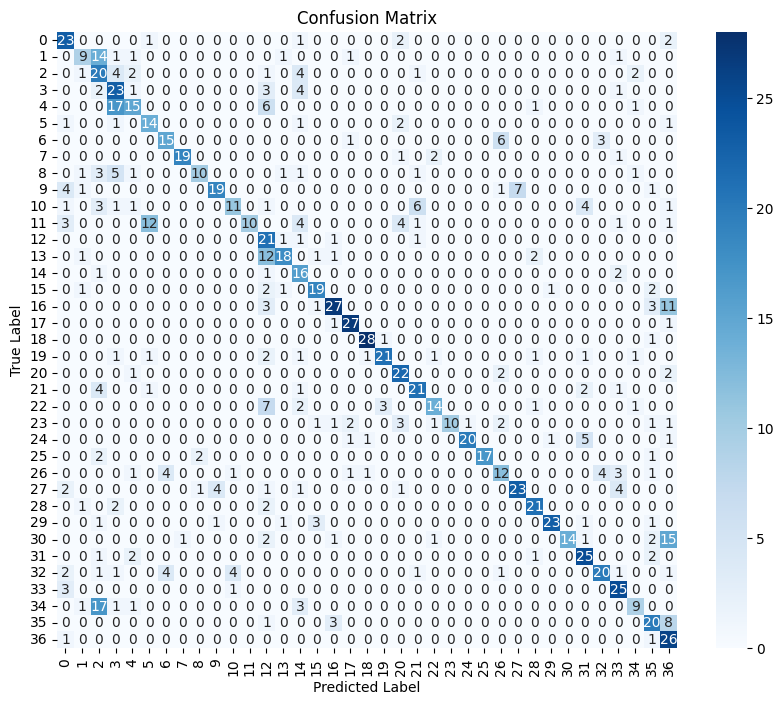

In [ ]:


# Final evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    # Unification of all labels and predictions
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = running_corrects.double() / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classificaiton report
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(37)], output_dict=True)

    # Convert the report into a pandas DataFrame and transpose it
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:\n", report_df)

    # Calculation of confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(37)], yticklabels=[str(i) for i in range(37)])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Final Evaluation
evaluate_model(model_trained, test_loader)

In [ ]:
# Path of the ZIP file and destination directory
zip_file_path = "/content/saved_images (2).zip"
extract_to_path = "/content/saved_images"

# Create the destination directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files successfully extracted to: {extract_to_path}")

File estratti con successo in: /content/saved_images


In [ ]:
# Extract generated_images.zip to /content/generated_images
with zipfile.ZipFile("/content/generated_images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/generated_images")

print("Extraction completed!")

Estrazione completata!


In [ ]:
# Load the existing JSON file
json_file = '/content/augmented_captions_dataset.json'

# Read the dataset from the JSON file
with open(json_file, 'r') as file:
    data_list = json.load(file)

# Create a dictionary to map labels to a numeric index
label_to_index = {}
current_index = 0

# Populate the dictionary with unique labels
for entry in data_list:
    label_name = entry['label']  # Label name
    if label_name not in label_to_index:
        label_to_index[label_name] = current_index
        current_index += 1

# Add the numeric index to each entry in the dataset
for entry in data_list:
    label_name = entry['label']
    entry['label_idx'] = label_to_index[label_name]  # Add the numeric index

# Save the updated JSON file
with open(json_file, 'w') as file:
    json.dump(data_list, file, indent=4)

# Print some control information
print(f"Number of unique labels: {len(label_to_index)}")
print(f"Labels to numeric index: {label_to_index}")

Numero di etichette uniche: 36
Label a indice numerico: {'Abyssinian': 0, 'American Bulldog': 1, 'American Pit Bull Terrier': 2, 'Basset Hound': 3, 'Beagle': 4, 'Birman': 5, 'Bombay': 6, 'Boxer': 7, 'British Shorthair': 8, 'Chihuahua': 9, 'Egyptian Mau': 10, 'English Cocker Spaniel': 11, 'English Setter': 12, 'German Shorthaired': 13, 'Great Pyrenees': 14, 'Havanese': 15, 'Japanese Chin': 16, 'Keeshond': 17, 'Leonberger': 18, 'Maine Coon': 19, 'Miniature Pinscher': 20, 'Newfoundland': 21, 'Persian': 22, 'Pomeranian': 23, 'Pug': 24, 'Ragdoll': 25, 'Russian Blue': 26, 'Saint Bernard': 27, 'Samoyed': 28, 'Scottish Terrier': 29, 'Shiba Inu': 30, 'Siamese': 31, 'Sphynx': 32, 'Staffordshire Bull Terrier': 33, 'Wheaten Terrier': 34, 'Yorkshire Terrier': 35}


In [ ]:
# Percorsi dei file di input
file1_path = "/content/augmented_captions_dataset.json"
file2_path = "/content/captions_dataset_blip.json"
output_path = "/content/overall_dataset_augmented.json"

# Carica il primo file JSON
with open(file1_path, 'r') as file1:
    data1 = json.load(file1)

# Carica il secondo file JSON
with open(file2_path, 'r') as file2:
    data2 = json.load(file2)

# Fondi i due dataset (puoi personalizzare la logica se necessario)
merged_data = data1 + data2 if isinstance(data1, list) and isinstance(data2, list) else {**data1, **data2}

# Salva il file JSON fuso
with open(output_path, 'w') as output_file:
    json.dump(merged_data, output_file, indent=4)

print(f"Dataset fuso salvato in: {output_path}")

Dataset fuso salvato in: /content/overall_dataset_augmented.json


In [ ]:
# Percorso del file da scaricare
files.download("/content/overall_dataset_augmented.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Define the device for processing (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the JSON file
json_file = '/content/overall_dataset_augmented.json'

with open(json_file, 'r') as f:
    data = json.load(f)

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item["image"]
        label = item["label_idx"]

        # Load image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Create the dataset
dataset = CustomImageDataset(data, transform=transform)

# Calculate the sizes for training, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for batches
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to show the distribution of categories
def show_category_distribution(dataloader, label_map, set_name="Dataset"):
    label_counts = Counter()

    for images, labels in dataloader:
        label_counts.update(labels.cpu().numpy())  # Count the labels in the batch

    print(f"Category distribution in {set_name}:")
    for label_idx, count in label_counts.items():
        print(f"Category: {label_map[label_idx]} | Number of images: {count}")

# Create a dictionary that maps indices to labels
label_map = {idx: label for idx, label in enumerate(set(item['label'] for item in data))}

# Verify the category distribution for each set
show_category_distribution(train_loader, label_map, "Training Set")
show_category_distribution(val_loader, label_map, "Validation Set")
show_category_distribution(test_loader, label_map, "Test Set")

# Verify the total sizes of the sets
print(f"Training Set size: {len(train_loader.dataset)}")
print(f"Validation Set size: {len(val_loader.dataset)}")
print(f"Test Set size: {len(test_loader.dataset)}")

Utilizzando il dispositivo: cuda
Distribuzione delle categorie nel Training Set:
Categoria: Wheaten Terrier | Numero di immagini: 135
Categoria: English Cocker Spaniel | Numero di immagini: 143
Categoria: Chihuahua | Numero di immagini: 152
Categoria: Ragdoll | Numero di immagini: 154
Categoria: Siamese | Numero di immagini: 133
Categoria: Leonberger | Numero di immagini: 149
Categoria: Russian Blue | Numero di immagini: 156
Categoria: Abyssinian | Numero di immagini: 126
Categoria: Pug | Numero di immagini: 144
Categoria: Samoyed | Numero di immagini: 153
Categoria: Yorkshire Terrier | Numero di immagini: 144
Categoria: Miniature Pinscher | Numero di immagini: 157
Categoria: Bombay | Numero di immagini: 138
Categoria: Scottish Terrier | Numero di immagini: 142
Categoria: Shiba Inu | Numero di immagini: 169
Categoria: British Shorthair | Numero di immagini: 158
Categoria: Maine Coon | Numero di immagini: 139
Categoria: Keeshond | Numero di immagini: 141
Categoria: American Bulldog | Nu

In [ ]:
def check_tensor_values(dataloader):
    image_min = float('inf')
    image_max = float('-inf')
    label_min = float('inf')
    label_max = float('-inf')
    label_set = set()

    # Iteration on all batches
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Verification of maximum and minimum values for images
        image_min = min(image_min, images.min().item())
        image_max = max(image_max, images.max().item())

        # Verification of maximum and minimum values for labels
        label_min = min(label_min, labels.min().item())
        label_max = max(label_max, labels.max().item())

        # Gathering of all labels
        label_set.update(labels.cpu().numpy())

    # Print the results
    print(f"Image values: Min = {image_min}, Max = {image_max}")
    print(f"Label values: Min = {label_min}, Max = {label_max}")
    print(f"Number of unique labels: {len(label_set)}")
    print(f"Unique labels: {sorted(label_set)}")

# Perform the check for the training set, validation set, and test set
print("Verification of values for the Training Set:")
check_tensor_values(train_loader)

print("\nVerification of values for the Validation Set:")
check_tensor_values(val_loader)

print("\nVerification of values for the Test Set:")
check_tensor_values(test_loader)

Verifica dei valori per il Training Set:
Valori immagini: Min = -2.1179039478302, Max = 2.640000104904175
Valori etichette: Min = 0, Max = 36
Numero di etichette uniche: 37
Etichette uniche: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Verifica dei valori per il Validation Set:
Valori immagini: Min = -2.1179039478302, Max = 2.640000104904175
Valori etichette: Min = 0, Max = 36
Numero di etichette uniche: 37
Etichette uniche: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Verifica dei valori per il Test Set:
Valori immagini: Min = -2.1179039478302, Max = 2.640000104904175
Valori etichette: Min = 0, Max = 36
Numero di etichette uniche: 37
Etichette uniche: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [ ]:

# Define the device for training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando il dispositivo: {device}")

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the last layer to fit all the 37 classes
model.fc = nn.Linear(model.fc.in_features, 37)

# Move the model to the device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Early Stopping
class EarlyStopping:
    def __init__(self, patience=2, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

early_stopping = EarlyStopping(patience=2, delta=0.01)

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)


        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)


            optimizer.zero_grad()


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculation of loss and for hte beckprepagions
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # running loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Part of the code for the evalutation fase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Updating of the chscduler
        scheduler.step()

        # Early stopping
        if early_stopping(epoch_loss):
            print("Early stopping attivato")
            break

        # part for saving the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_val_loss = epoch_loss
            best_model_wts = model.state_dict()

        print()

    # Part for loading the best weights for the model
    model.load_state_dict(best_model_wts)
    return model

#Training of the model
num_epochs = 15
model_trained = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs
)

# Saving of the model
torch.save(model_trained.state_dict(), 'resnet50_trained_model_agumented.pth')


Epoch 0/14
----------
Training Loss: 1.0152 Acc: 0.7224
Validation Loss: 1.0550 Acc: 0.6983
Early stopping attivato


Test Accuracy: 0.7255
Classification Report:
               precision    recall  f1-score      support
0              0.602564  0.940000  0.734375    50.000000
1              0.947368  0.666667  0.782609    27.000000
2              0.812500  0.520000  0.634146    25.000000
3              0.600000  0.777778  0.677419    27.000000
4              0.538462  0.482759  0.509091    29.000000
5              0.763158  0.805556  0.783784    36.000000
6              0.608696  0.500000  0.549020    28.000000
7              0.627907  0.870968  0.729730    31.000000
8              0.740741  0.571429  0.645161    35.000000
9              0.491228  0.903226  0.636364    31.000000
10             0.722222  0.520000  0.604651    25.000000
11             0.925926  0.714286  0.806452    35.000000
12             0.777778  0.518519  0.622222    27.000000
13             0.666667  0.800000  0.727273    30.000000
14             0.687500  0.785714  0.733333    28.000000
15             0.909091  0.833333  0.86956

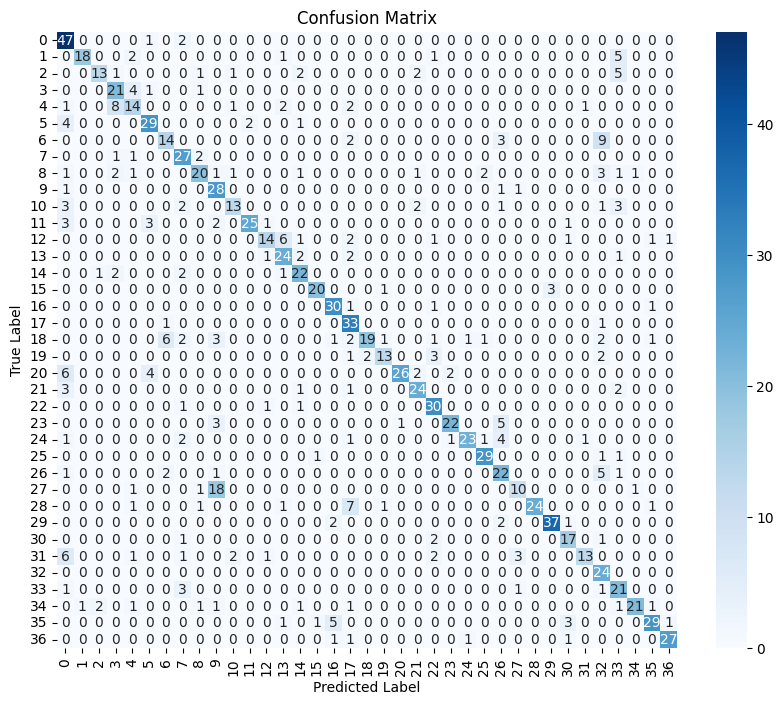

In [ ]:
# Final evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    # Unification of all labels and predictions
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = running_corrects.double() / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classificaiton report
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(37)], output_dict=True)

    # Convert the report into a pandas DataFrame and transpose it
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:\n", report_df)

    # Calculation of confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(37)], yticklabels=[str(i) for i in range(37)])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Final Evaluation
evaluate_model(model_trained, test_loader)

###CONCLUSIONS

Comparison of Results Between Original and Augmented Dataset
Model Accuracy:

Without artificially generated images: 62.28%
With artificially generated images: 72.55%
Improvement: +10.27%
General Classification Report Metrics:

Macro Avg (Precision):
Without: 0.696
With: 0.759
Macro Avg (Recall):
Without: 0.635
With: 0.720
Macro Avg (F1-Score):
Without: 0.631
With: 0.719
These improvements indicate that the model has gained better ability to distinguish between classes, leading to overall stronger performance.

Support Analysis:

The total number of test samples increased from 1103 to 1162 images, which may have contributed to stabilizing the model's performance.
Impact of Artificial Images
Increased Precision and Recall:
Artificial images provided better generalization, contributing to a more balanced performance across many classes.

Improved Classes:
Classes 0, 1, 9, 15, 22, and 36 show significant improvements in both recall and F1-score.

Negative Performance Trends:
Some classes experienced marginal or slight declines, but most showed a clear positive trend.

Conclusion
Integrating artificially generated images significantly improved the model's performance, suggesting that dataset augmentation through the use of artificial images helped enhance the model's ability to recognize and classify images more accurately in the critical context of the project.